## Replace Bellow cells 1 by 1 with exp

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from typing import Dict, List, Callable

# Reset random seed for repeatability
np.random.seed(2025)

# ======================================================
# 1. CORE REGISTRIES (The 4-Node Service Journey)
# ======================================================
# The farmer's journey is mapped as a service blueprint with 4 distinct stages.
TOUCHPOINTS = [
    "Resource_Acquisition",  # Buying stocks, finding land
    "Cultivation_Process",   # Crops, supplements, land usage
    "Harvest_Operations",    # Yield processing, spoilage management
    "Market_Distribution"    # Getting a seller, logistics
]

METRIC_KEYS = [
    "Resource_Efficiency",   # Metric for Acquisition (Cost/Quality balance)
    "Growth_Rate",           # Metric for Cultivation (Speed/Health)
    "Yield_Volume",          # Metric for Harvest (Tonnage/Spoilage)
    "Market_Penetration"     # Metric for Distribution (Price/Speed)
]
# Features representing the Service Design inputs
FEATURE_KEYS = [
    'land_arability_index', 'seed_stock_cost',     # Acquisition
    'soil_nitrogen_level', 'supplement_ph_bal',    # Cultivation
    'crop_yield_tonnage', 'spoilage_rate',         # Harvest
    'market_spot_price', 'logistics_overhead'      # Distribution
]

# ======================================================
# 2. MAPPING & TARGET MATRICES
# ======================================================
# Mapping specific features to the service stages
metric_feature_map = {
    "Resource_Acquisition": ['land_arability_index', 'seed_stock_cost'],
    "Cultivation_Process":  ['soil_nitrogen_level', 'supplement_ph_bal'],
    "Harvest_Operations":   ['crop_yield_tonnage', 'spoilage_rate'],
    "Market_Distribution":  ['market_spot_price', 'logistics_overhead']
}

# The Target Influence Matrix (4x4)
# Defines which stage targets affect others (1 = influence, 0 = independent)
METRIC_TARGET = np.array([
    [1, 1, 0, 1],  # Acquisition impacts Cultivation & Distribution (capital)
    [0, 1, 1, 0],  # Cultivation impacts Harvest directly
    [0, 0, 1, 1],  # Harvest impacts Distribution
    [0, 0, 0, 1]   # Distribution is the final sink
])

# Service Transformation Formulas (Non-linear service transfer functions)
METRIC_FORMULAS = [
    lambda x: np.log(x + 10),      # Diminishing returns on Land
    lambda x: np.tanh(x) * 3.5,    # Saturation point for Supplements
    lambda x: np.exp(x * 0.1),     # Exponential growth potential in Harvest
    lambda x: 1.0 / (x + 0.5)      # Inverse elasticity in Distribution
]

# Design Structure Matrix (DSM) - 4x4
# Represents the physical flow of goods/service
DSM = np.array([
    [0, 1, 0, 0],  # Acquisition -> Cultivation
    [0, 0, 1, 0],  # Cultivation -> Harvest
    [0, 0.4, 0, 1],# Feedback loop from Harvest to Cultivation (seeds), flow to Market
    [0, 0, 0, 0]   # Market
])

# Node Dimensionality (The "Hubs")
# Acquisition/Market are lower dim (4), Cultivation/Harvest are high complexity hubs (16)
candidate_dims = [[4], [16], [16], [4]]
D_graph = len(candidate_dims) # 4 Nodes

# ======================================================
# 3. GENERATOR ENGINE (Agricultural Physics)
# ======================================================
GENERATOR_MAP = {
    "Resource_Acquisition": lambda: {
        "land_arability_index": np.random.beta(7, 2) * 100, # 0-100 score
        "seed_stock_cost": np.random.normal(5000, 1200)     # Currency
    },
    "Cultivation_Process": lambda: {
        "soil_nitrogen_level": np.random.uniform(20, 80),   # ppm
        "supplement_ph_bal": np.random.normal(6.5, 0.4)     # pH level
    },
    "Harvest_Operations": lambda: {
        "crop_yield_tonnage": np.random.gamma(5, 2.0),      # Tons
        "spoilage_rate": np.random.exponential(0.05)        # % lost
    },
    "Market_Distribution": lambda: {
        "market_spot_price": np.random.uniform(1.2, 3.5),   # Price per unit
        "logistics_overhead": np.random.poisson(150)        # Cost index
    }
}

# ======================================================
# 4. DATA PROCESSING & ASSEMBLY
# ======================================================
num_samples = 150 # Increased sample size for better training
feature_list = []

for tp in TOUCHPOINTS:
    samples = [GENERATOR_MAP[tp]() for _ in range(num_samples)]
    df = pd.DataFrame(samples)
    feature_list.append(df)

DATA_MATRIX_RAW = pd.concat(feature_list, axis=1).to_numpy()

# Normalization (Min-Max scaling for optimization stability)
DATA_MATRIX = (DATA_MATRIX_RAW - DATA_MATRIX_RAW.min(axis=0)) / (np.ptp(DATA_MATRIX_RAW, axis=0) + 1e-8)
# Dependency Graph Initialization
G = nx.DiGraph(METRIC_TARGET)
mapping = {i: name for i, name in enumerate(TOUCHPOINTS)}
nx.relabel_nodes(G, mapping, copy=False)

print(f"Service Matrix Initialized: {DATA_MATRIX.shape}")
print(f"Service Nodes: {list(G.nodes)}")

# ======================================================
# 5. HIGH-FIDELITY SYNTHETIC TARGET GENERATOR
# ======================================================
def generate_targets(DATA_MATRIX, candidate_dims):
    dims_flat = [i[0] for i in candidate_dims]
    num_nodes = len(dims_flat)
    targets = []
    current_col = 0

    # Total features available
    total_feats = DATA_MATRIX.shape[1]

    for node_idx in range(num_nodes):
        dim = dims_flat[node_idx]

        # Row selection: Modular index to ensure we use all data
        row_idx = node_idx % DATA_MATRIX.shape[0]
        row = DATA_MATRIX[row_idx]

        # Slicing the contiguous block for target signature
        # We wrap around columns if the dimension requirement exceeds remaining features
        start = current_col % total_feats
        end = start + dim

        if end > total_feats:
            # Wrap around logic
            part1 = row[start:]
            part2 = row[:end - total_feats]
            block = np.concatenate([part1, part2])
        else:
            block = row[start:end]

        # HUB LOGIC: If still smaller (e.g., dim=16 but features=8), pad reflectively
        if len(block) < dim:
            pad_needed = dim - len(block)
            block = np.pad(block, (0, pad_needed), mode='reflect')
        elif len(block) > dim:
            block = block[:dim]

        targets.append({
            'node_id': node_idx,
            'touchpoint': TOUCHPOINTS[node_idx],
            'dim_required': dim,
            'target': np.round(block, 4)
        })

        # Shift column pointer for next node to create variance
        current_col = (current_col + 2) % total_feats

    return targets

# Execute generation
synthetic_targets = generate_targets(DATA_MATRIX, candidate_dims)

# ======================================================
# 6. DIAGNOSTIC REPORT
# ======================================================
print(f"\n--- Farmer Cultivation Service Optimization (4-Node) ---")
print(f"Total Service Features Analyzed: {DATA_MATRIX.shape[1]}")
print("-" * 80)
print(f"{'ID':<3} | {'Service Touchpoint':<25} | {'Type':<12} | {'Target Signature (Head)'}")
print("-" * 80)

for t in synthetic_targets:
    # Identify "Hubs" (Complex nodes) vs "Spokes" (Simple nodes)
    node_type = "[COMPLEX]" if t['dim_required'] >= 16 else "[SIMPLE]"

    # Format the signature for display
    sig_preview = str(t['target'][:4]).replace('\n', '') + "..."

    print(f"{t['node_id']:02d}  | {t['touchpoint']:<25} | {node_type:<12} | {sig_preview}")

print("-" * 80)

Service Matrix Initialized: (150, 8)
Service Nodes: ['Resource_Acquisition', 'Cultivation_Process', 'Harvest_Operations', 'Market_Distribution']

--- Farmer Cultivation Service Optimization (4-Node) ---
Total Service Features Analyzed: 8
--------------------------------------------------------------------------------
ID  | Service Touchpoint        | Type         | Target Signature (Head)
--------------------------------------------------------------------------------
00  | Resource_Acquisition      | [SIMPLE]     | [0.5171 0.4728 0.6905 0.6582]...
01  | Cultivation_Process       | [COMPLEX]    | [0.034  0.5431 0.4241 1.    ]...
02  | Harvest_Operations        | [COMPLEX]    | [0.8032 0.6503 0.3624 0.2361]...
03  | Market_Distribution       | [SIMPLE]     | [0.8639 0.3889 0.6891 0.5119]...
--------------------------------------------------------------------------------


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from typing import Dict, List, Any

# Reset random seed for reproducibility
np.random.seed(2025)

# ======================================================
# 1. CORE REGISTRIES (12 TOUCHPOINTS)
# ======================================================
METRIC_KEYS = [
    "ClinicalProgramming",   # 0
    "SiteLogistics",         # 1
    "MedicalEquipPlanning",  # 2
    "ArchitecturalLayout",   # 3
    "InfectionControl",      # 4
    "StructuralSeismic",     # 5
    "SpecializedMEP",        # 6
    "ICT_SmartHospital",     # 7
    "Regulatory_Accred",     # 8
    "ValueEngineering",      # 9: NEW - Cost vs. Scope balance
    "BIM_DigitalTwin",       # 10: NEW - Clash detection/Data integrity
    "Aggregate_Safety"       # 11: Summary Index
]

TOUCHPOINTS = [
    "ClinicalProgramming",   # 0: Input
    "SiteLogistics",         # 1: Input
    "MedicalEquipPlanning",  # 2: HUB (High Complexity)
    "ArchitecturalLayout",   # 3: Core
    "InfectionControl",      # 4: Core
    "StructuralSeismic",     # 5: Core
    "SpecializedMEP",        # 6: HUB (The Engine)
    "ICT_SmartHospital",     # 7: Support
    "Regulatory_Accred",     # 8: Constraint
    "ValueEngineering",      # 9: Optimization
    "BIM_DigitalTwin",       # 10: Integration
    "Aggregate_Safety"       # 11: Output
]

# Feature keys for reference (2 per node for compact simulation)
FEATURE_KEYS = [
    'icu_bed_count', 'case_mix_index',
    'ambulance_turn_radius', 'hazmat_access_score',
    'mri_weight_kg', 'linac_shielding_mm',
    'grid_efficiency', 'daylight_factor',
    'ach_operating_room', 'neg_pressure_delta',
    'vibration_vc_rating', 'live_load_capacity',
    'medgas_flow_lpm', 'ups_redundancy_tier',
    'data_points_per_bed', 'latency_ms',
    'fgi_compliance_score', 'fire_safety_rating',
    'capex_reduction_pct', 'lifecycle_cost_gap',
    'clash_count_meq', 'lod_level',
    'patient_fall_risk', 'infection_rate_sim'
]

# ======================================================
# 2. MAPPING & TARGET MATRICES
# ======================================================
# Mapping features to specific nodes
metric_feature_map = {
    "ClinicalProgramming":  ['icu_bed_count', 'case_mix_index'],
    "SiteLogistics":        ['ambulance_turn_radius', 'hazmat_access_score'],
    "MedicalEquipPlanning": ['mri_weight_kg', 'linac_shielding_mm'],
    "ArchitecturalLayout":  ['grid_efficiency', 'daylight_factor'],
    "InfectionControl":     ['ach_operating_room', 'neg_pressure_delta'],
    "StructuralSeismic":    ['vibration_vc_rating', 'live_load_capacity'],
    "SpecializedMEP":       ['medgas_flow_lpm', 'ups_redundancy_tier'],
    "ICT_SmartHospital":    ['data_points_per_bed', 'latency_ms'],
    "Regulatory_Accred":    ['fgi_compliance_score', 'fire_safety_rating'],
    "ValueEngineering":     ['capex_reduction_pct', 'lifecycle_cost_gap'],
    "BIM_DigitalTwin":      ['clash_count_meq', 'lod_level'],
    "Aggregate_Safety":     ['patient_fall_risk', 'infection_rate_sim']
}

# 12x12 Dependency/Influence Matrix (Simplified for visualization)
# 1 = Influence exists, 0 = No direct influence
METRIC_TARGET = np.eye(12) # Start with identity
# Add the "Gordian Knot" complexity (Equip <-> Struct <-> MEP)
METRIC_TARGET[2, 5] = 1 # Equip -> Struct
METRIC_TARGET[2, 6] = 1 # Equip -> MEP
METRIC_TARGET[5, 4] = 1 # Struct -> Infection (via physical constraints)
METRIC_TARGET[6, 4] = 1 # MEP -> Infection (Airflow)
METRIC_TARGET[9, 0] = 1 # VE -> Clinical (Feedback loop)

# Mathematical transfer functions for the 12 nodes
METRIC_FORMULAS = [
    lambda x: np.log(x + 1),               # 0
    lambda x: 1.0 / (x + 0.1),             # 1
    lambda x: x**1.5,                      # 2 (Non-linear growth for Equip)
    lambda x: np.tanh(x),                  # 3
    lambda x: np.exp(x * 0.5),             # 4
    lambda x: x * 2.5,                     # 5
    lambda x: np.sin(x) * x,               # 6 (Oscillating load for MEP)
    lambda x: np.sqrt(x),                  # 7
    lambda x: 1.0 - np.exp(-x),            # 8
    lambda x: np.abs(np.log(x)),           # 9
    lambda x: (np.arctan(x) * 2)/np.pi,    # 10
    lambda x: np.mean(x)                   # 11
]

DSM = np.array([
    #0    1    2    3    4    5    6    7    8    9    10   11
    [0,   1,   1,   0.5, 0,   0,   0,   0,   0,   0.2, 0,   0],   # 0 ClinicalStrategy
    [0,   0,   0.5, 0,   0.8, 0,   0,   0,   0,   0,   0.5, 0],   # 1 SiteLogistics
    [0,   0,   0,   1.0, 1.0, 0.5, 0.8, 0.6, 0.9, 0,   0,   0],   # 2 MedicalPlanning (Feeds EVERYONE)
    [0,   0,   0.9, 0,   0.5, 1.0, 1.0, 0.4, 0,   0,   0,   0],   # 3 EquipmentPlanning (Feeds Structure/MEP heavily)
    [0,   0,   0.4, 0,   0,   1.0, 0.5, 0,   0.3, 0,   0,   0],   # 4 ArchitecturalShell
    [0,   0,   0,   0.2, 0.6, 0,   0.4, 0,   0,   0,   0,   0],   # 5 StructuralSeismic
    [0,   0,   0.3, 0.5, 0.4, 0.2, 0,   0.5, 0.8, 0,   0,   0],   # 6 MEP_Specialized (Feeds Infection Control)
    [0,   0,   0.2, 0.3, 0,   0,   0.4, 0,   0,   0,   0,   0],   # 7 ICT_SmartHospital
    [0,   0,   0.8, 0,   0.5, 0,   0.9, 0,   0,   0,   0,   0],   # 8 InfectionControl (Can reject MEP/Arch designs)
    [0.8, 0,   0.9, 0.9, 0.7, 0.6, 0.8, 0.5, 0.5, 0,   0,   0],   # 9 CostEngineering (The "Gatekeeper" - Rejects back to Strategy/Plan)
    [0,   0.4, 0.8, 0,   0.5, 0.5, 0.8, 0,   1.0, 0.5, 0,   1],   # 10 Regulatory_JCI (Must approve everything)
    [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],   # 11 BIM_Integration
])
# Dimensionality Assignments:
# 16 = High Complexity Hubs (Equip, MEP)
# 12 = Standard Engineering
# 4  = Inputs/Outputs
candidate_dims = [
    [4],  # 0: Clinical
    [4],  # 1: Site
    [16], # 2: MedicalEquip (HUB)
    [12], # 3: Arch
    [12], # 4: Infection
    [12], # 5: Structural
    [16], # 6: MEP (HUB)
    [8],  # 7: ICT
    [8],  # 8: Regulatory
    [8],  # 9: ValueEng
    [12], # 10: BIM
    [4]   # 11: Safety
]

D_graph = len(candidate_dims)

# ======================================================
# 3. GENERATOR ENGINE
# ======================================================
GENERATOR_MAP = {
    "ClinicalProgramming": lambda: {
        "icu_bed_count": np.random.poisson(25),
        "case_mix_index": np.random.normal(1.2, 0.1)
    },
    "SiteLogistics": lambda: {
        "ambulance_turn_radius": np.random.choice([0, 1]), # Fail/Pass
        "hazmat_access_score": np.random.uniform(0, 10)
    },
    "MedicalEquipPlanning": lambda: {
        "mri_weight_kg": np.random.uniform(3000, 7000),
        "linac_shielding_mm": np.random.uniform(100, 2500)
    },
    "ArchitecturalLayout": lambda: {
        "grid_efficiency": np.random.beta(5, 2),
        "daylight_factor": np.random.uniform(0.2, 0.6)
    },
    "InfectionControl": lambda: {
        "ach_operating_room": np.random.randint(15, 30),
        "neg_pressure_delta": np.random.normal(0.03, 0.005)
    },
    "StructuralSeismic": lambda: {
        "vibration_vc_rating": np.random.randint(1, 5),
        "live_load_capacity": np.random.uniform(80, 150)
    },
    "SpecializedMEP": lambda: {
        "medgas_flow_lpm": np.random.uniform(500, 2000),
        "ups_redundancy_tier": np.random.randint(1, 4)
    },
    "ICT_SmartHospital": lambda: {
        "data_points_per_bed": np.random.randint(8, 24),
        "latency_ms": np.random.exponential(5)
    },
    "Regulatory_Accred": lambda: {
        "fgi_compliance_score": np.random.uniform(0.85, 1.0),
        "fire_safety_rating": np.random.randint(1, 10)
    },
    "ValueEngineering": lambda: {
        "capex_reduction_pct": np.random.uniform(0.05, 0.15),
        "lifecycle_cost_gap": np.random.normal(100000, 20000)
    },
    "BIM_DigitalTwin": lambda: {
        "clash_count_meq": np.random.poisson(50),
        "lod_level": 400
    },
    "Aggregate_Safety": lambda: {
        "patient_fall_risk": np.random.beta(2, 8),
        "infection_rate_sim": np.random.uniform(0.01, 0.05)
    }
}
GENERATOR_MAP = {
    "ClinicalProgramming": lambda: {
        "icu_bed_count": np.random.poisson(25),
        "case_mix_index": np.random.normal(1.2, 0.1),
        "p1": np.random.rand(), "p2": np.random.rand() # Total 4
    },
    "SiteLogistics": lambda: {
        "ambulance_turn_radius": np.random.choice([0, 1]),
        "hazmat_access_score": np.random.uniform(0, 10),
        "p1": np.random.rand(), "p2": np.random.rand() # Total 4
    },
    "MedicalEquipPlanning": lambda: {
        "mri_weight_kg": np.random.uniform(3000, 7000),
        "linac_shielding_mm": np.random.uniform(100, 2500),
        **{f"p{i}": np.random.randn() for i in range(14)} # Total 16 (HUB)
    },
    "ArchitecturalLayout": lambda: {
        "grid_efficiency": np.random.beta(5, 2),
        "daylight_factor": np.random.uniform(0.2, 0.6),
        **{f"p{i}": np.random.randn() for i in range(10)} # Total 12
    },
    "InfectionControl": lambda: {
        "ach_operating_room": np.random.randint(15, 30),
        "neg_pressure_delta": np.random.normal(0.03, 0.005),
        **{f"p{i}": np.random.randn() for i in range(10)} # Total 12
    },
    "StructuralSeismic": lambda: {
        "vibration_vc_rating": np.random.randint(1, 5),
        "live_load_capacity": np.random.uniform(80, 150),
        **{f"p{i}": np.random.randn() for i in range(10)} # Total 12
    },
    "SpecializedMEP": lambda: {
        "medgas_flow_lpm": np.random.uniform(500, 2000),
        "ups_redundancy_tier": np.random.randint(1, 4),
        **{f"p{i}": np.random.randn() for i in range(14)} # Total 16 (HUB)
    },
    "ICT_SmartHospital": lambda: {
        "data_points_per_bed": np.random.randint(8, 24),
        "latency_ms": np.random.exponential(5),
        **{f"p{i}": np.random.randn() for i in range(6)} # Total 8
    },
    "Regulatory_Accred": lambda: {
        "fgi_compliance_score": np.random.uniform(0.85, 1.0),
        "fire_safety_rating": np.random.randint(1, 10),
        **{f"p{i}": np.random.randn() for i in range(6)} # Total 8
    },
    "ValueEngineering": lambda: {
        "capex_reduction_pct": np.random.uniform(0.05, 0.15),
        "lifecycle_cost_gap": np.random.normal(100000, 20000),
        **{f"p{i}": np.random.randn() for i in range(6)} # Total 8
    },
    "BIM_DigitalTwin": lambda: {
        "clash_count_meq": np.random.poisson(50),
        "lod_level": np.random.normal(400, 10),
        **{f"p{i}": np.random.randn() for i in range(10)} # Total 12
    },
    "Aggregate_Safety": lambda: {
        "patient_fall_risk": np.random.beta(2, 8),
        "infection_rate_sim": np.random.uniform(0.01, 0.05),
        "p1": np.random.rand(), "p2": np.random.rand() # Total 4
    }
}

# ======================================================
# 4. DATA PROCESSING & ASSEMBLY
# ======================================================
num_samples = 150
feature_list = []

for tp in TOUCHPOINTS:
    samples = [GENERATOR_MAP[tp]() for _ in range(num_samples)]
    df = pd.DataFrame(samples)
    feature_list.append(df)

DATA_MATRIX_RAW = pd.concat(feature_list, axis=1).to_numpy()

# Min-Max Normalization with stability epsilon
DATA_MATRIX = (DATA_MATRIX_RAW - DATA_MATRIX_RAW.min(axis=0)) / (np.ptp(DATA_MATRIX_RAW, axis=0) + 1e-8)

# Dependency Graph (Visualization Object)
G = nx.DiGraph(METRIC_TARGET)
mapping = {i: name for i, name in enumerate(TOUCHPOINTS)}
nx.relabel_nodes(G, mapping, copy=False)

print(f"Hospital Matrix Initialized: {DATA_MATRIX.shape}")
print(f"Nodes in Graph: {len(G.nodes)}")

# ======================================================
# 5. HIGH-FIDELITY SYNTHETIC TARGET GENERATOR
# ======================================================
def generate_hospital_targets(DATA_MATRIX, candidate_dims):
    dims_flat = [i[0] for i in candidate_dims]
    num_nodes = len(dims_flat)
    targets = []
    current_col = 0

    for node_idx in range(num_nodes):
        dim = dims_flat[node_idx]

        # Row selection: use the specific row index for the touchpoint
        # Modulo ensures we wrap around samples if needed
        row = DATA_MATRIX[node_idx % DATA_MATRIX.shape[0]]

        # Slicing the contiguous block for target signature
        block = row[current_col : current_col + dim]

        # RECURSIVE PADDING:
        # If the node (e.g., MEP) requires 16 dims but we are at the edge
        # of the matrix or features are sparse, we use reflective padding
        # to preserve statistical variance (critical for risk modeling).
        if len(block) < dim:
            block = np.pad(block, (0, dim - len(block)), mode='reflect')

        targets.append({
            'node_id': node_idx,
            'touchpoint': TOUCHPOINTS[node_idx],
            'dim_required': dim,
            'target': np.round(block, 4)
        })

        # Modular wrap for feature variance recycling
        current_col = (current_col + dim) % DATA_MATRIX.shape[1]

    return targets

# Execute generation
synthetic_targets = generate_hospital_targets(DATA_MATRIX, candidate_dims)

# ======================================================
# 6. DIAGNOSTIC REPORT
# ======================================================
print(f"\n--- Tier-1 Hospital Optimization Matrix (12-Node) ---")
print(f"Total Design Features Analyzed: {DATA_MATRIX.shape[1]}")
print("-" * 80)

for t in synthetic_targets:
    # Identify "Knot" nodes visually
    is_hub = "[HUB/KNOT]" if t['dim_required'] >= 16 else "          "
    node_desc = f"{t['node_id']:02d} | {t['touchpoint']:<22} | {is_hub}"

    # Print the first few elements of the signature to show data density
    sig_preview = str(t['target'][:3])[:-1] + "...]"
    print(f"Node {node_desc} | Dims: {t['dim_required']:02d} | Sig: {sig_preview}")

print("-" * 80)
print("Analysis: Nodes 02 (MedEquip) and 06 (MEP) identified as high-dimensionality")
print("hubs, requiring 16-dim embeddings due to dense downstream coupling.")

Hospital Matrix Initialized: (150, 116)
Nodes in Graph: 12

--- Tier-1 Hospital Optimization Matrix (12-Node) ---
Total Design Features Analyzed: 116
--------------------------------------------------------------------------------
Node 00 | ClinicalProgramming    |            | Dims: 04 | Sig: [0.7241 0.3155 0.6532...]
Node 01 | SiteLogistics          |            | Dims: 04 | Sig: [1.     0.8191 0.7893...]
Node 02 | MedicalEquipPlanning   | [HUB/KNOT] | Dims: 16 | Sig: [0.8844 0.8612 0.3838...]
Node 03 | ArchitecturalLayout    |            | Dims: 12 | Sig: [0.9711 0.002  0.2384...]
Node 04 | InfectionControl       |            | Dims: 12 | Sig: [0.0714 0.4093 0.5578...]
Node 05 | StructuralSeismic      |            | Dims: 12 | Sig: [1.     0.3106 0.2652...]
Node 06 | SpecializedMEP         | [HUB/KNOT] | Dims: 16 | Sig: [0.756  1.     0.6769...]
Node 07 | ICT_SmartHospital      |            | Dims: 08 | Sig: [0.2    0.0393 0.6118...]
Node 08 | Regulatory_Accred      |            | D

In [27]:
import numpy as np
import pandas as pd
import networkx as nx

# Reset random seed for reproducibility
np.random.seed(2025)

# ======================================================
# 1. CORE REGISTRIES (7-NODE PINPOINT CONFIG)
# ======================================================
TOUCHPOINTS = [
    "Client_Intake",          # 0: Input (Linear)
    "Document_Triage",        # 1: Input (Linear)
    "Identity_Credentialing", # 2: HUB (High Risk / Fraud Vector)
    "Legal_Scrutiny",         # 3: Core (Clause Analysis)
    "The_Notarial_Act",       # 4: Core (Execution)
    "Compliance_Audit",       # 5: HUB (System of Record)
    "Journal_Archiving"       # 6: Output (Linear)
]

# METRIC KEYS (Aligns with Touchpoints for Node-Level Scoring)
METRIC_KEYS = TOUCHPOINTS

# ======================================================
# 2. FEATURE REGISTRY (FLAT LIST OF MATRIX COLUMNS)
# ======================================================
# This list corresponds exactly to the columns in the generated DATA_MATRIX
FEATURE_KEYS = [
    # 0: Client_Intake
    'wait_time_mins', 'client_sentiment',
    # 1: Document_Triage
    'page_count', 'doc_complexity_score',
    # 2: Identity_Credentialing (HUB)
    'biometric_confidence', 'fraud_risk_flag',
    # 3: Legal_Scrutiny
    'clauses_flagged', 'readability_index',
    # 4: The_Notarial_Act
    'ceremony_duration_sec', 'stamp_clarity_score',
    # 5: Compliance_Audit (HUB)
    'violation_severity', 'data_integrity_score',
    # 6: Journal_Archiving
    'upload_latency_ms', 'chain_hash_valid'
]

# Mapping specific features to their parent Node/Metric
metric_feature_map = {
    "Client_Intake":          ['wait_time_mins', 'client_sentiment'],
    "Document_Triage":        ['page_count', 'doc_complexity_score'],
    "Identity_Credentialing": ['biometric_confidence', 'fraud_risk_flag'],
    "Legal_Scrutiny":         ['clauses_flagged', 'readability_index'],
    "The_Notarial_Act":       ['ceremony_duration_sec', 'stamp_clarity_score'],
    "Compliance_Audit":       ['violation_severity', 'data_integrity_score'],
    "Journal_Archiving":      ['upload_latency_ms', 'chain_hash_valid']
}

# ======================================================
# 3. INTERACTION MATRIX & FORMULAS (7x7 KNOT LOGIC)
# ======================================================

# 7x7 DSM (Dependency Structure Matrix)
# Defines the critical rework loops:
# - Identity (2) -> Legal (3) -> Act (4)
# - Audit (5) -> Feedback Loop to Identity (2) & Legal (3)
METRIC_TARGET = np.array([
    #0  1  2  3  4  5  6
    [1, 1, 0, 0, 0, 0, 0], # 0: Intake -> Triage
    [0, 1, 1, 1, 0, 0, 0], # 1: Triage -> ID, Legal
    [0, 0, 1, 1, 1, 0, 0], # 2: ID -> Legal, Act (CRITICAL PATH)
    [0, 0, 0, 1, 1, 0, 0], # 3: Legal -> Act
    [0, 0, 0, 0, 1, 1, 0], # 4: Act -> Audit
    [0, 0, 1, 1, 0, 1, 1], # 5: Audit -> FEEDBACK LOOP (ID, Legal), Archive
    [0, 0, 0, 0, 0, 0, 1]  # 6: Archive
])

# Scoring Formulas (Transfer Functions 0.0 - 1.0)
METRIC_FORMULAS = [
    lambda x: np.exp(-x / 15.0),           # 0: Intake (Minimize wait)
    lambda x: 1.0 / (1.0 + x),             # 1: Triage (Handle complexity)
    lambda x: x**3,                        # 2: Identity (Confidence must be high)
    lambda x: np.exp(-x * 0.5),            # 3: Legal (Minimize flagged clauses)
    lambda x: np.exp(-(x-300)**2 / 1e4),   # 4: Act (Target 5 min duration)
    lambda x: 1.0 / (1.0 + x*2),           # 5: Audit (Zero violations target)
    lambda x: 1.0 / (1.0 + x/200)          # 6: Archive (Minimize latency)
]

# ======================================================
# 4. DIMENSIONALITY CONFIGURATION
# ======================================================
# 16 Dims for Hubs (ID, Audit)
# 12 Dims for Core (Legal, Act)
# 4-8 Dims for Linear
candidate_dims = [
    [4],  # 0: Client_Intake
    [8],  # 1: Document_Triage
    [16], # 2: Identity_Credentialing (HUB)
    [12], # 3: Legal_Scrutiny
    [12], # 4: The_Notarial_Act
    [16], # 5: Compliance_Audit (HUB)
    [4]   # 6: Journal_Archiving
]

D_graph = len(candidate_dims)

# ======================================================
# 5. GENERATOR ENGINE
# ======================================================
GENERATOR_MAP = {
    "Client_Intake": lambda: {
        "wait_time_mins": np.random.exponential(12),
        "client_sentiment": np.random.beta(5, 2)
    },
    "Document_Triage": lambda: {
        "page_count": np.random.randint(1, 50),
        "doc_complexity_score": np.random.choice([0.2, 0.5, 0.9])
    },
    "Identity_Credentialing": lambda: {
        "biometric_confidence": np.random.uniform(0.85, 0.999),
        "fraud_risk_flag": np.random.binomial(1, 0.02)
    },
    "Legal_Scrutiny": lambda: {
        "clauses_flagged": np.random.poisson(2),
        "readability_index": np.random.uniform(30, 80)
    },
    "The_Notarial_Act": lambda: {
        "ceremony_duration_sec": np.random.normal(300, 60),
        "stamp_clarity_score": np.random.uniform(0.9, 1.0)
    },
    "Compliance_Audit": lambda: {
        "violation_severity": np.random.exponential(0.5),
        "data_integrity_score": np.random.beta(9, 1)
    },
    "Journal_Archiving": lambda: {
        "upload_latency_ms": np.random.uniform(100, 500),
        "chain_hash_valid": 1.0
    }
}

GENERATOR_MAP = {
    "Client_Intake": lambda: {
        # Lognormal captures the 'Bureaucratic Drag' better than Exponential
        "wait_time_mins": np.random.lognormal(2.4, 0.5), 
        "client_sentiment": np.random.beta(5, 2)
    },
    "Document_Triage": lambda: {
        "page_count": np.random.negative_binomial(20, 0.5), # Models 'clumpy' paperwork
        "doc_complexity_score": np.random.beta(2, 5) # Continuous 0-1 scale
    },
    "Identity_Credentialing": lambda: {
        # Introduce 'Bimodal' risk: It's either very sure or completely confused
        "biometric_confidence": np.random.choice([
            np.random.uniform(0.95, 1.0), 
            np.random.uniform(0.6, 0.8)
        ], p=[0.9, 0.1]),
        "fraud_risk_flag": np.random.binomial(1, 0.05)
    },
    "Legal_Scrutiny": lambda: {
        # Poisson is good, but let's make it 'bursty'
        "clauses_flagged": np.random.poisson(lam=1.5 if np.random.random() > 0.2 else 8.0),
        "readability_index": np.random.triangular(20, 50, 90) # Better than Uniform
    },
    "The_Notarial_Act": lambda: {
        # Variance increases as duration increases (Heteroskedasticity)
        "ceremony_duration_sec": np.random.normal(400, 100),
        "stamp_clarity_score": 1.0 - np.random.weibull(1.5) * 0.1 # Real-world wear-and-tear
    },
    "Compliance_Audit": lambda: {
        # This is the 'Minimax Nightmare' distribution
        "violation_severity": np.random.pareto(2.0), 
        "data_integrity_score": np.random.power(5) # Skewed toward 1.0, but sensitive to drops
    },
    "Journal_Archiving": lambda: {
        "upload_latency_ms": np.random.gamma(shape=2, scale=100), # More realistic network lag
        "chain_hash_valid": np.random.choice([1.0, 0.0], p=[0.9999, 0.0001]) # Rare failure
    }
}
# ======================================================
# 6. MATRIX BUILDER
# ======================================================
def build_data_matrix(num_samples=200):
    feature_list = []
    for tp in TOUCHPOINTS:
        samples = [GENERATOR_MAP[tp]() for _ in range(num_samples)]
        df = pd.DataFrame(samples)
        feature_list.append(df)

    raw_matrix = pd.concat(feature_list, axis=1).to_numpy()

    # Robust Normalization
    ptp = np.ptp(raw_matrix, axis=0)
    ptp[ptp == 0] = 1.0
    norm_matrix = (raw_matrix - raw_matrix.min(axis=0)) / ptp
    return norm_matrix

DATA_MATRIX = build_data_matrix()

# ======================================================
# 7. SYNTHETIC TARGET GENERATOR (HUB/KNOT LOGIC)
# ======================================================
def generate_notary_targets(DATA_MATRIX, candidate_dims):
    dims_flat = [i[0] for i in candidate_dims]
    num_nodes = len(dims_flat)
    targets = []
    current_col = 0



    print(f"{'ID':<3} | {'Touchpoint Name':<24} | {'Role':<12} | {'Dims'} | {'Signature Sample'}")
    print("-" * 85)

    for node_idx in range(num_nodes):
        dim_required = dims_flat[node_idx]

        # Row selection & Feature Slicing
        row = DATA_MATRIX[node_idx % DATA_MATRIX.shape[0]]
        block = row[current_col : current_col + dim_required]

        # REFLECTIVE PADDING
        if len(block) < dim_required:
            pad_width = dim_required - len(block)
            block = np.pad(block, (0, pad_width), mode='reflect')

        targets.append({
            'node_id': node_idx,
            'name': TOUCHPOINTS[node_idx],
            'dim': dim_required,
            'target': np.round(block, 4)
        })

        current_col = (current_col + dim_required) % DATA_MATRIX.shape[1]

        # Output
        role = "HUB/KNOT" if dim_required >= 16 else ("Core" if dim_required >= 12 else "Linear")
        sig_str = str(block[:3])[:-1] + "...]"
        print(f"{node_idx:<3} | {TOUCHPOINTS[node_idx]:<24} | {role:<12} | {dim_required:<4} | {sig_str}")

    return targets
DSM = np.array([
    [0, 1, 0, 0, 0, 0, 0], # 0
    [0, 0, 1, 1, 0, 0, 0], # 1
    [0, 0, 0, 1, 1, 0, 0], # 2
    [0, 0, 0, 0, 1, 0, 0], # 3
    [0, 0, 0, 0, 0, 1, 0], # 4
    [0, 0, 1, 1, 0, 0, 1], # 5 -> The Feedback Loop (The "Knot")
    [0, 0, 0, 0, 0, 0, 0]  # 6
])
# ======================================================
# 8. EXECUTION
# ======================================================
print("\n--- Notary Service Infrastructure Optimization (7-Node Pinpoint) ---")
print(f"Matrix Shape: {DATA_MATRIX.shape} (Samples x Features)")
print(f"Total Features Registered: {len(FEATURE_KEYS)}")
print("-" * 85)

synthetic_targets = generate_notary_targets(DATA_MATRIX, candidate_dims)

print("-" * 85)
print("Analysis: Graph reduced to 7 critical nodes. 'Identity_Credentialing' and")
print("'Compliance_Audit' remain the high-dimensional Hubs driving the system.")


--- Notary Service Infrastructure Optimization (7-Node Pinpoint) ---
Matrix Shape: (200, 14) (Samples x Features)
Total Features Registered: 14
-------------------------------------------------------------------------------------
ID  | Touchpoint Name          | Role         | Dims | Signature Sample
-------------------------------------------------------------------------------------
0   | Client_Intake            | Linear       | 4    | [0.19848453 0.60869917 0.55882353...]
1   | Document_Triage          | Linear       | 8    | [0.9023344  0.         0.06666667...]
2   | Identity_Credentialing   | HUB/KNOT     | 16   | [0.17435973 0.         0.17435973...]
3   | Legal_Scrutiny           | Core         | 12   | [0.07957076 0.54775336 0.02941176...]
4   | The_Notarial_Act         | Core         | 12   | [0.11213946 0.         0.11213946...]
5   | Compliance_Audit         | HUB/KNOT     | 16   | [0.23262742 0.76334137 0.24683867...]
6   | Journal_Archiving        | Linear       | 4    

In [28]:

# ======================================================
# 6. OPTIMIZER (Branch & Bound)
# ======================================================
class BranchBoundOptimizer:
    def __init__(self, tol=1e-3, max_depth=20, minimize=True, value_range=(0.0, 10.0)):
        self.tol = tol
        self.max_depth = max_depth
        self.minimize = minimize
        self.value_range = value_range

    def optimize(self, features, y=None, metric_mask=None):
        y = np.zeros(3) if y is None else np.array(y[:3])
        base = np.mean(list(features.values())) + np.mean(y)

        a0, b0 = self.value_range
        a0 += base
        b0 += base

        work = [(a0, b0, 0)]
        best_x = None
        best_score = np.inf if self.minimize else -np.inf

        def better(s1, s2):
            return s1 < s2 if self.minimize else s1 > s2

        while work:
            a, b, depth = work.pop()
            mid = 0.5 * (a + b)

            # Apply Formula if mask is active
            mv = [f(mid) if m else 0.0 for f, m in zip(METRIC_FORMULAS, metric_mask)]
            score = sum(mv)

            if best_x is None or better(score, best_score):
                best_x = mid
                best_score = score

            if depth >= self.max_depth or (b - a) < self.tol:
                continue

            work.append((a, mid, depth + 1))
            work.append((mid, b, depth + 1))

        return best_x

# ======================================================
# 8. EVALUATOR
# ======================================================
class MetricsEvaluator:
    def __init__(
        self,
        data_matrix,
        metric_formulas=METRIC_FORMULAS,
        metric_feature_map=metric_feature_map,
        feature_keys=FEATURE_KEYS,
        feature_target=None,
        metric_target=None,
        tol=1e-3,
        max_depth=20,
        minimize=False,
        value_range=(0.0, 5.0)
    ):
        self.data_matrix = data_matrix
        self.metric_formulas = metric_formulas
        self.metric_feature_map = metric_feature_map
        self.feature_keys = feature_keys

        # Defaults
        self.feature_target = feature_target or [[1]*len(feature_keys) for _ in range(data_matrix.shape[0])]
        self.metric_target = metric_target or METRIC_TARGET
        self.num_nodes = data_matrix.shape[0]

        self.optimizer = BranchBoundOptimizer(
            tol=tol,
            max_depth=max_depth,
            minimize=minimize,
            value_range=value_range
        )

    def extract_features(self, node_idx):
        if node_idx >= len(self.data_matrix): return {}
        row = self.data_matrix[node_idx]
        mask = self.feature_target[node_idx]
        features = {k: v for k, v, m in zip(self.feature_keys, row, mask) if m}
        return features

    def compute_node_metrics(self, node_idx, y=None):
        features = self.extract_features(node_idx)
        metric_mask = self.metric_target[node_idx] if node_idx < len(self.metric_target) else [0]*len(METRIC_KEYS)
        metric_values = {}

        for key, formula, mask in zip(METRIC_KEYS, self.metric_formulas, metric_mask):
            if mask and key in self.metric_feature_map:
                relevant_keys = self.metric_feature_map[key]
                relevant_features = [features[f] for f in relevant_keys if f in features]
                x = np.mean(relevant_features) if relevant_features else 0.0

                # Optimize
                opt_value = self.optimizer.optimize(features={key: x}, y=y, metric_mask=[1])
                metric_values[key] = formula(opt_value)
            else:
                metric_values[key] = 0.0

        metric_values['score'] = sum(metric_values.values())
        return metric_values
# ======================================================
# 8. EXECUTION
# ======================================================

# Generate Mock Data (15 Nodes x 25 Features)
# ======================================================
# 9. DIMENSIONALITY CONFIGURATION (15 Nodes)
# ======================================================

# Dimensions assigned based on node complexity and coupling depth.
# "Hub" nodes and Financial nodes get higher dimensions.


__Replace above cells with Expert knowledge__
# Service Design Generator Simulation

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
# Target Mask (which metrics apply to which node)

def top_k_masked_probs(weights, k):
    """
    Keep only top-k weights, zero out the rest, renormalize.
    """
    if k >= len(weights):
        return weights / (weights.sum() + 1e-12)

    idx = np.argpartition(weights, -k)[-k:]
    mask = np.zeros_like(weights)
    mask[idx] = weights[idx]

    s = mask.sum()
    if s > 0:
        mask /= s
    return mask
def get_all_paths(G, C, node_types, start=0, end=None):
    """
    Return all simple paths that respect coupling constraints.
    """
    if end is None:
        end = G.shape[0] - 1

    D = G.shape[0]
    paths = []

    def coupling_ok(i, j):
        label = C[i, j]

        # Default direct coupling
        if "->" in label and "->C" not in label:
            src, dst = label.split("->")
            return src == node_types[i] and dst == node_types[j]

        # Escalation case (B->B->C)
        if label == "B->B->C":
            return node_types[i] == "B" and node_types[j] == "B"

        return False

    def dfs(node, path, visited):
        if node == end:
            paths.append(path.copy())
            return

        for nxt in range(D):
            if G[node, nxt] > 0 and nxt not in visited:
                if not coupling_ok(node, nxt):
                    continue

                visited.add(nxt)
                dfs(nxt, path + [nxt], visited)
                visited.remove(nxt)

    dfs(start, [start], {start})
    return paths



# =============================================================================
# EXTERNAL DEPENDENCIES & CONFIGURATION
# =============================================================================
# These variables are referenced in the original code but not defined.
# Assumed to be present in the execution environment.
# -----------------------------------------------------------------------------
# D_graph = ...
# DATA_MATRIX = ...
# METRIC_KEYS = [...]
# METRIC_TARGET = [...]
# METRIC_FORMULAS = [...]
# METRIC_INVERSES = {...}
# synthetic_targets = ...
# MetricsEvaluator = ... (Class)
# -----------------------------------------------------------------------------
# =============================================================================
# NEW: DETERMINISTIC DFS & PATH EVALUATOR
# =============================================================================


def evaluate_fixed_paths(paths, node_metrics, beta=0.3):
    """
    Replaces collect_and_select_best_walks.
    Scores the specific paths found by DFS.
    """
    walks = []
    best = None

    for path in paths:
        cost = 0.0
        quality = 0.0

        # Calculate Path Metrics
        for node_idx in path:
            m = node_metrics[node_idx]
            cost += m.get("cost", 0.0)
            quality += m.get("quality", 0.0)

        score = quality - 1.0 * cost # using default lambda_cost=1.0

        # DFS paths are unique, so count is always 1
        count = 1
        adjusted_score = score / (1 + beta * count)

        record = {
            "path": path,
            "score": score,
            "adjusted_score": adjusted_score,
            "cost": cost,
            "quality": quality,
            "count": count
        }
        walks.append(record)

        if best is None or adjusted_score > best["adjusted_score"]:
            best = record

    return walks, best

def dsm_walk(G, node_metrics, start=0, max_steps=50, lambda_cost=1.0):
    D = G.shape[0]
    target_node = D - 1  # Define Nlast

    # Force start at 0 if not provided
    current = start
    path = [current]
    visited = {current}

    cost = 0.0
    quality = 0.0

    # Metrics for the start node
    m_start = node_metrics[current]
    cost += m_start.get("cost", 0.0)
    quality += m_start.get("quality", 0.0)

    reached_target = False

    for _ in range(max_steps):
        # If we reached the last node, stop successfully
        if current == target_node:
            reached_target = True
            break

        weights = np.zeros(D)

        for j in range(D):
            # Allow visiting the target even if visited (though unlikely to revisit in DAG)
            # But generally prevent cycles
            if j == 0:
                continue
            if j in visited:
                continue

            q = node_metrics[j].get("quality", 0.0)
            c = node_metrics[j].get("cost", 0.0)

            # Standard probability weight
            weights[j] = G[current, j] * (q / (1 + c))

        if weights.sum() == 0:
            break

        weights /= weights.sum()
        nxt = np.random.choice(D, p=weights)

        m = node_metrics[nxt]
        cost += m.get("cost", 0.0)
        quality += m.get("quality", 0.0)

        path.append(nxt)
        visited.add(nxt)
        current = nxt

    # Recalculate score based on success
    score = quality - lambda_cost * cost

    # Heavy penalty if the walk did not reach Nlast
    if not reached_target:
        score = -1e9

    return path, score, cost, quality

from collections import defaultdict

def collect_and_select_best_walks(G, node_metrics, n_walks=300, beta=0.3):
    walks = []
    best = None
    path_counts = defaultdict(int)
    D = G.shape[0]

    for _ in range(n_walks):
        # Force start at 0
        start = 0
        path, score, cost, quality = dsm_walk(
            G, node_metrics, start
        )

        # Only record if it successfully reached the last node
        # (Score is -1e9 if it failed, per updated dsm_walk)
        if path[-1] != (D - 1):
            continue

        key = tuple(path)
        path_counts[key] += 1

        # novelty penalty
        adjusted_score = score / (1 + beta * path_counts[key])

        record = {
            "path": path,
            "score": score,
            "adjusted_score": adjusted_score,
            "cost": cost,
            "quality": quality,
            "count": path_counts[key]
        }
        walks.append(record)

        if best is None or adjusted_score > best["adjusted_score"]:
            best = record

    return walks, best


# Configuration
#candidate_dims = [[2], [2], [2], [2], [2], [2], [2], [2], [1]]
outer_generations = 1
inner_learning = 0.1
gamma_interlayer = 1
top_k = 21

# Initialize random state
np.random.seed()
seed = None  # Placeholder as per original logic

# Placeholder for Data Matrix generation (from original snippet)
# new_DATA_MATRIX = np.random.rand(D_graph, DATA_MATRIX.shape[1])


# =============================================================================
# HELPER CLASSES
# =============================================================================
class DSM_Tracker:
    """
    Tracks a DSM (Design Structure Matrix) layer and its residual.
    """
    def __init__(self, multiplex_layer):
        self.layer = multiplex_layer
        self.primary_dsm = None
        self.residual_dsm = None
        self.update_dsms()

    def update_dsms(self):
        if self.primary_dsm is None:
            # First time: store current DSM as reference
            self.primary_dsm = self.layer.chosen_Gmat.copy()
            self.residual_dsm = np.zeros_like(self.primary_dsm)
        else:
            # Update residual: current DSM minus primary
            current = self.layer.chosen_Gmat
            self.residual_dsm = current - self.primary_dsm

    def get_matrices(self):
        return self.primary_dsm, self.residual_dsm

    def print_matrices(self):
        print("\n--- Primary DSM ---")
        print(self.primary_dsm)
        print("\n--- Residual DSM ---")
        print(self.residual_dsm)


class DSM_Layer_Decomposer:
    """
    Manages the additive decomposition of DSM layers.
    """
    def __init__(self, baseline_matrix, mode='additive'):
        self.baseline_matrix = baseline_matrix.copy()
        self.current_total = baseline_matrix.copy()
        self.mode = mode
        self.layers = []
        self.residuals = []

    def add_snapshot(self, new_total_matrix):
        """
        Calculates the DELTA (change) between the new state and the previous state,
        stores that delta as a layer.
        """
        delta = new_total_matrix - self.current_total
        self.layers.append(delta.copy())

        # Update current tracker
        self.current_total = new_total_matrix.copy()

        # Calculate residual (Difference from the baseline)
        residual = self.current_total - self.baseline_matrix
        self.residuals.append(residual)

        layer_id = len(self.layers) - 1
        print(f"\n=== DSM LAYER {layer_id} CAPTURED ===")
        print(f"Layer Contribution (Delta):\n{np.round(delta, 3)}")

        return delta

    def get_reconstruction(self):
        return np.sum(self.layers, axis=0)


class SVM:
    """
    Metric-inverse multi-output SVM with epsilon-insensitive loss.
    """
    def __init__(self, input_dim, output_dim=None, metric_keys=None, lr=0.001, epsilon=0.1):
        self.input_dim = input_dim
        self.metric_keys = metric_keys

        if metric_keys is not None:
            self.output_dim = len(metric_keys)
        elif output_dim is not None:
            self.output_dim = output_dim
        else:
            self.output_dim = 1

        self.lr = lr
        self.epsilon = epsilon

        # Lazy initialization
        self.X_train = None
        self.y_train = None
        self.alpha = None
        self.b = None

    def train_step(self, X, y_true):
        X = np.array(X)
        y_true = np.array(y_true)
        n_samples = X.shape[0]

        if self.X_train is None:
            self.X_train = X.copy()
            self.y_train = y_true.copy()
            self.alpha = np.zeros((X.shape[1], self.output_dim))
            self.b = np.zeros(self.output_dim)

        # Linear kernel
        y_pred = X.dot(self.alpha) + self.b

        # Epsilon-insensitive loss
        diff = y_pred - y_true
        mask = np.abs(diff) > self.epsilon
        diff *= mask

        grad_alpha = X.T.dot(diff) / n_samples
        grad_b = diff.mean(axis=0)

        self.alpha -= self.lr * grad_alpha
        self.b -= self.lr * grad_b

        loss = np.mean(np.maximum(0, np.abs(y_pred - y_true) - self.epsilon))
        return loss

    def predict(self, X):
        X = np.array(X)
        y_pred = X.dot(self.alpha) + self.b

        if self.metric_keys is None:
            return y_pred

        # Apply metric inverses
        y_transformed = np.zeros_like(y_pred)
        for i, key in enumerate(self.metric_keys):
            inverse_fn = METRIC_INVERSES[key]
            # Handle potential list return from inverse_fn
            val_func = lambda y: inverse_fn(y)[0] if isinstance(inverse_fn(y), list) else inverse_fn(y)
            y_transformed[:, i] = np.array([val_func(y) for y in y_pred[:, i]])

        return y_transformed


class InterLayer:
    def __init__(self, D_graph, max_inner_dim, inter_dim=None, edge_threshold=0.02, gamma=1.0, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.D_graph = D_graph
        self.edge_threshold = edge_threshold
        self.gamma = gamma

        # Handle list vs int inputs for dimensions
        m_dim = max_inner_dim[0] if isinstance(max_inner_dim, list) else max_inner_dim

        if inter_dim is not None:
            self.inter_dim = inter_dim[0] if isinstance(inter_dim, list) else inter_dim
        else:
            self.inter_dim = m_dim

        self.max_input = 2 * m_dim

        # Initialize weights
        self.weights = {}
        self.bias = {}
        for i in range(D_graph):
            for j in range(D_graph):
                if i != j:
                    w_init = np.random.uniform(-0.1, 0.1, (self.inter_dim, self.max_input))
                    self.weights[(i, j)] = w_init
                    self.bias[(i, j)] = np.zeros(self.inter_dim)

    def compute_edge_activation(self, i, j, nested_reps):
        concat = np.concatenate([nested_reps[i], nested_reps[j]])
        # Pad or truncation
        if len(concat) < self.max_input:
            concat = np.pad(concat, (0, self.max_input - len(concat)))
        else:
            concat = concat[:self.max_input]

        # Normalize
        concat = (concat - np.mean(concat)) / (np.std(concat) + 1e-12)

        # Activation
        v = self.weights[(i, j)].dot(concat) + self.bias[(i, j)]
        input_strength = np.clip(np.mean(np.abs(concat)), 0, 1)
        v = v * input_strength

        return 1 / (1 + np.exp(-v))

    def build_activations(self, Gmat, nested_reps):
        acts = {}
        for i in range(self.D_graph):
            for j in range(self.D_graph):
                if i == j:
                    continue
                if abs(Gmat[i, j]) > self.edge_threshold:
                    acts[(i, j)] = self.compute_edge_activation(i, j, nested_reps)
        return acts

    @staticmethod
    def pairwise_squared_corr(acts):
        if len(acts) < 2:
            return 0.0
        A = np.stack(list(acts.values()))
        A_centered = A - A.mean(axis=1, keepdims=True)
        stds = np.sqrt(np.sum(A_centered**2, axis=1) / (A.shape[1]-1) + 1e-12)
        cov = A_centered @ A_centered.T / (A.shape[1]-1)
        corr = cov / (np.outer(stds, stds) + 1e-12)
        np.fill_diagonal(corr, 0)
        return float((corr**2).sum())

    def mi_for_graph(self, Gmat, nested_reps):
        acts = self.build_activations(Gmat, nested_reps)
        if not acts:
            return 0.0
        return self.gamma * self.pairwise_squared_corr(acts)

def build_dsm_from_walks(D, paths):
    """
    Constructs a DSM where entry [i,j] is the probability
    that a successful process moves from i to j.
    """
    flow = np.zeros((D, D))

    # Count transitions
    for path in paths:
        for k in range(len(path) - 1):
            u, v = path[k], path[k+1]
            flow[u, v] += 1

    # Normalize by the total number of successful walks.
    # This prevents 'saturation'—if an edge is rarely used, it stays small.
    n_paths = len(paths)
    if n_paths > 0:
        flow = flow / n_paths

    np.fill_diagonal(flow, 0.0)
    return flow




__________________________________________________ 0 -------------------------------------------------- 5 ==================================================
Starting Optimization: 1 Layers x 1 Gens

>>> COMPILING LAYER 1: STRUCTURE <<<
Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
 [Gen 1] Score: 0.0000

=== DSM

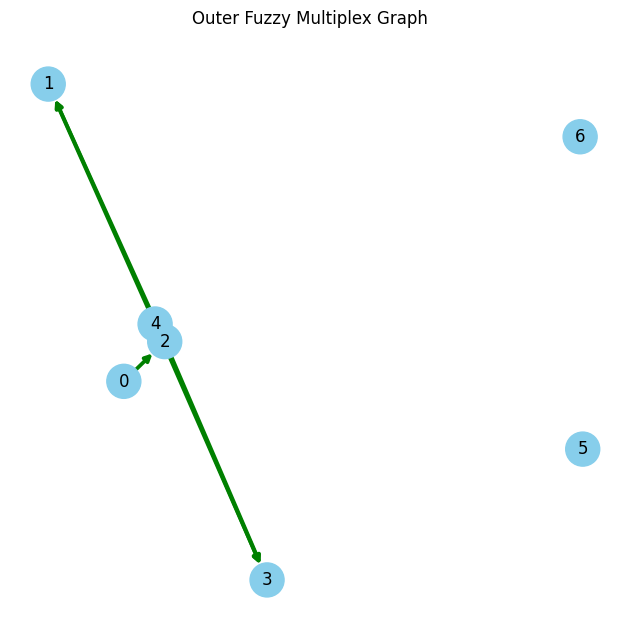

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

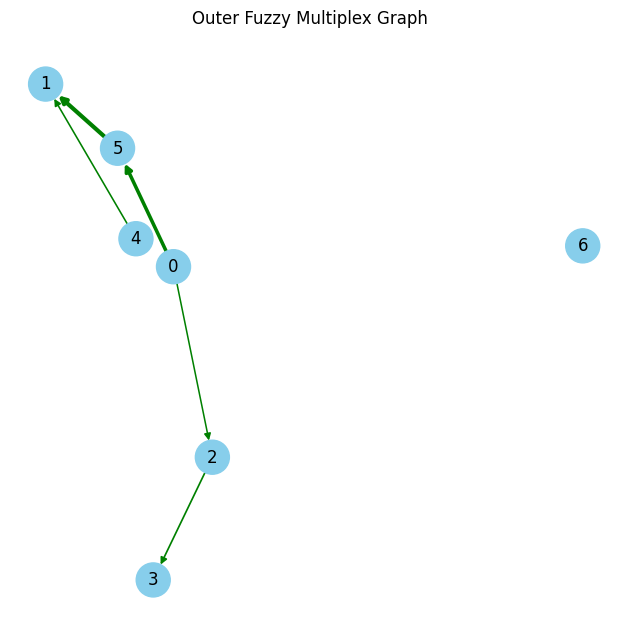

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.90  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

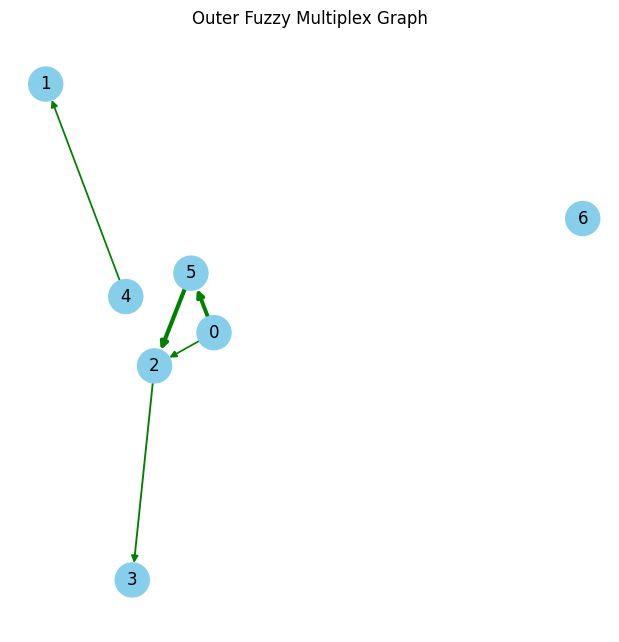

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.96  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

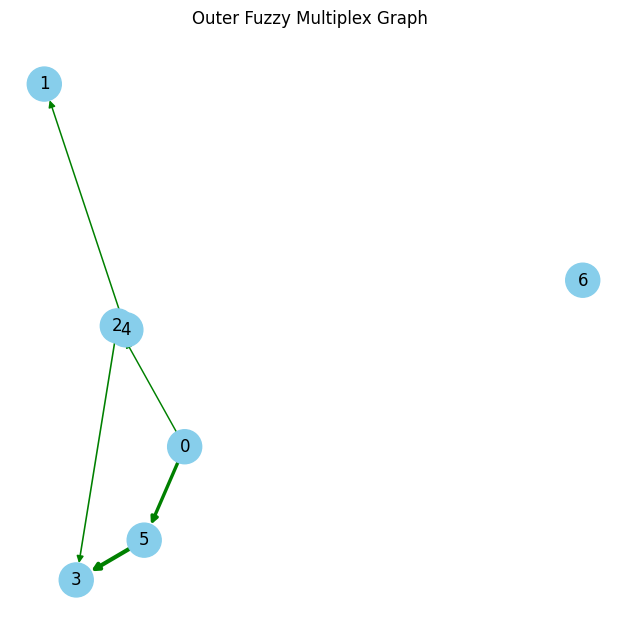

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

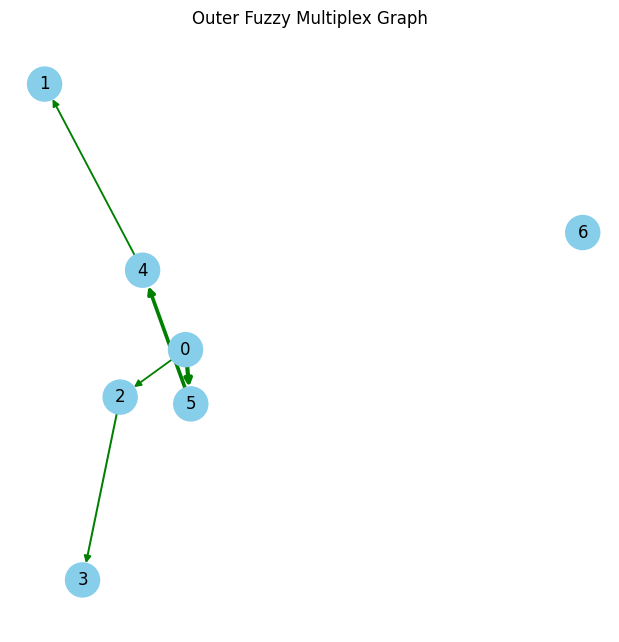

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  1.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.92  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

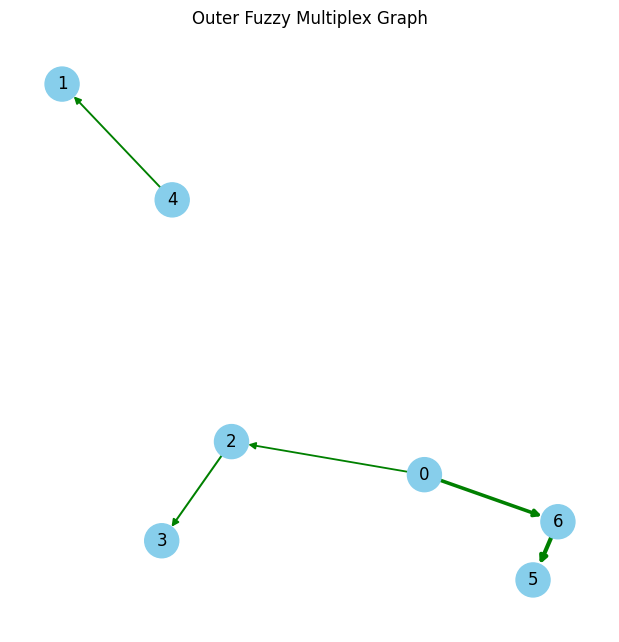

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.90 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

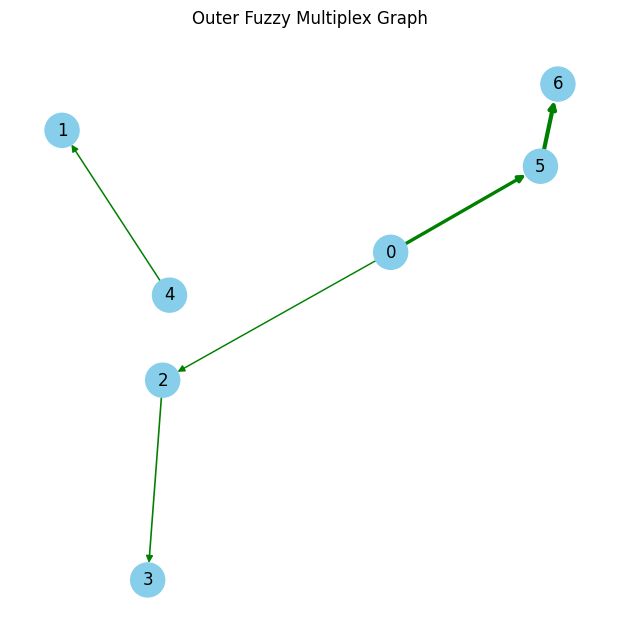

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

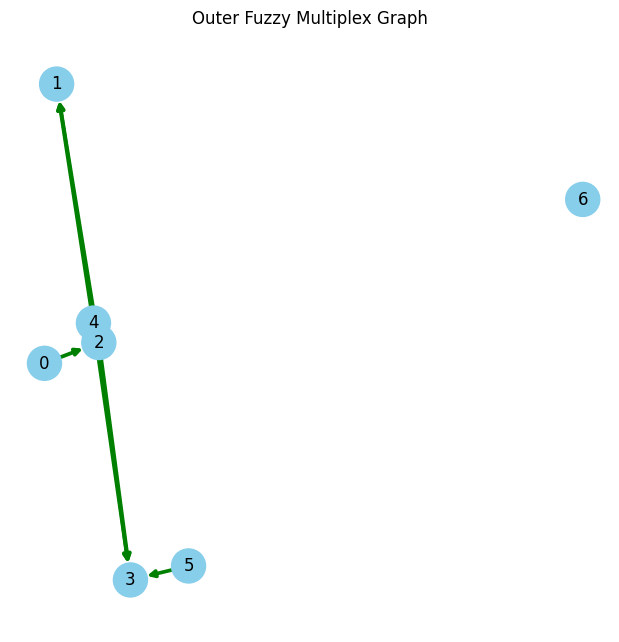

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

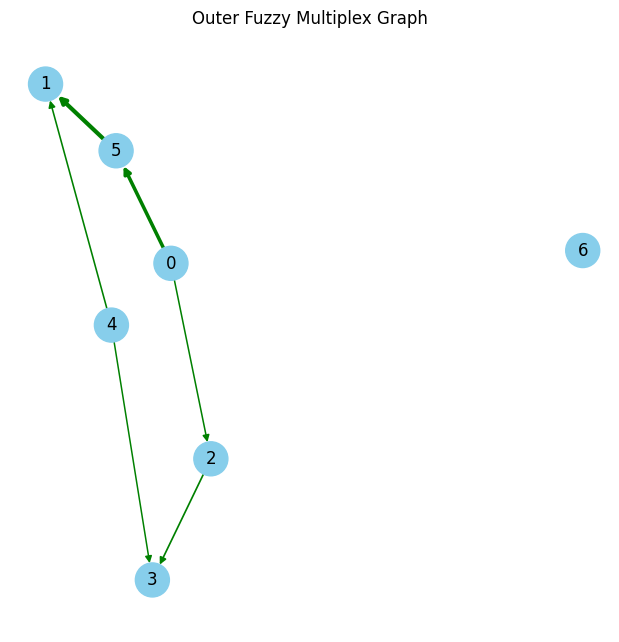

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.90  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

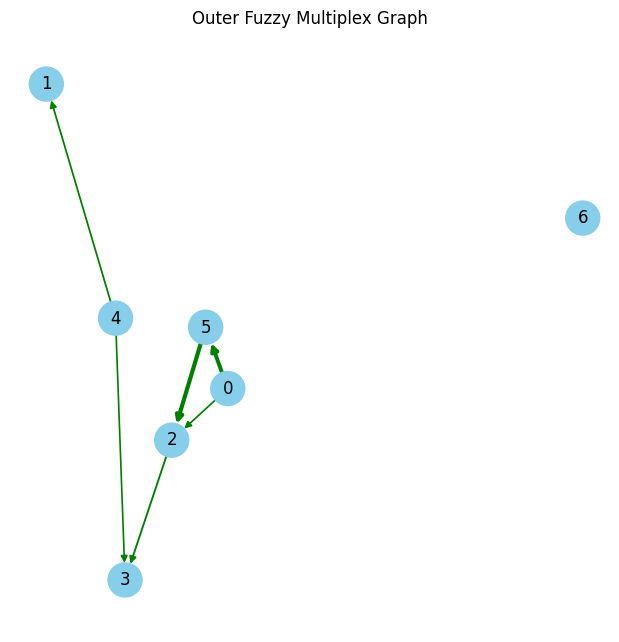

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.96  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

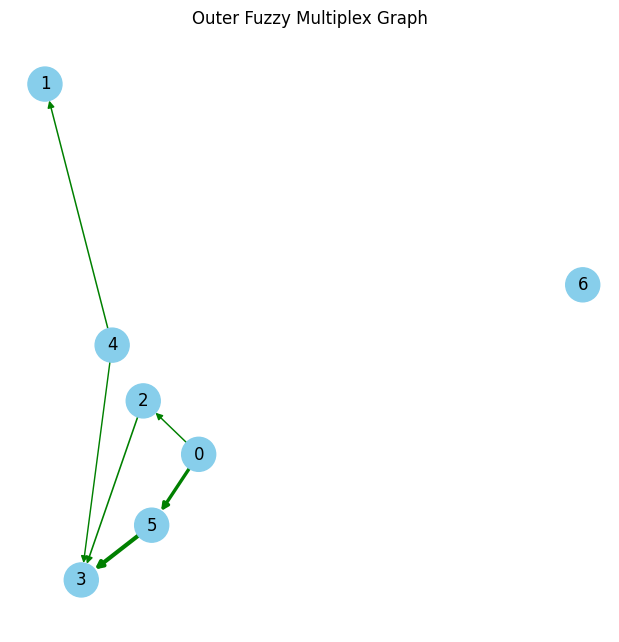

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

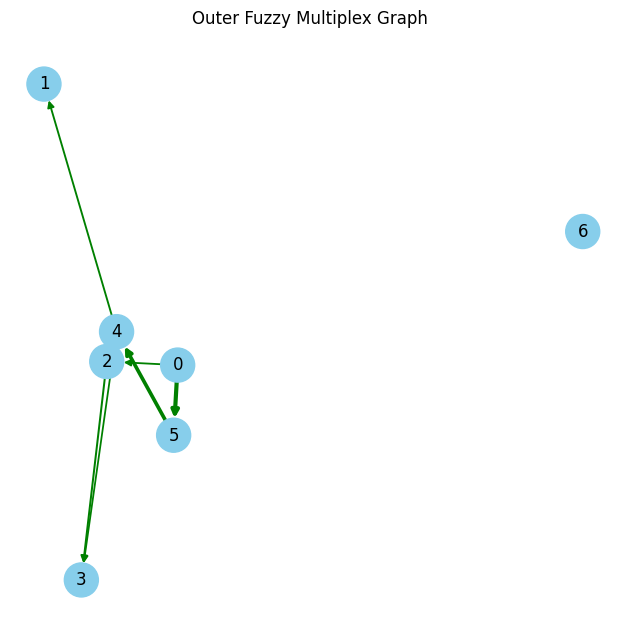

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  1.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.28  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.92  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

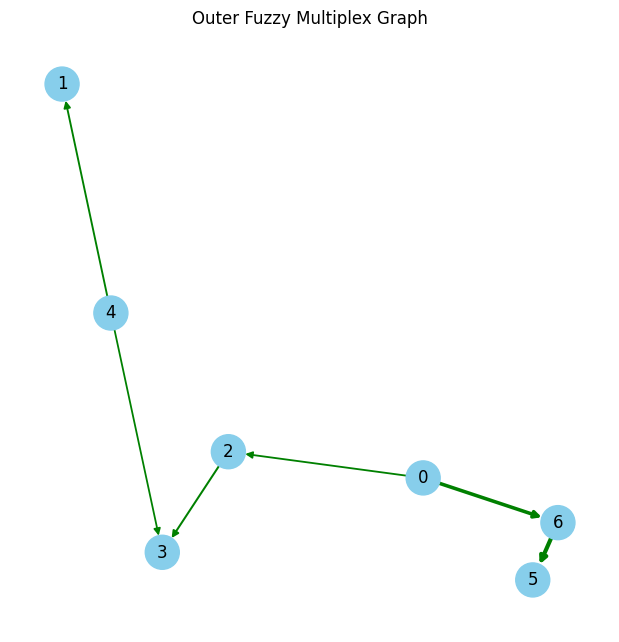

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.90 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

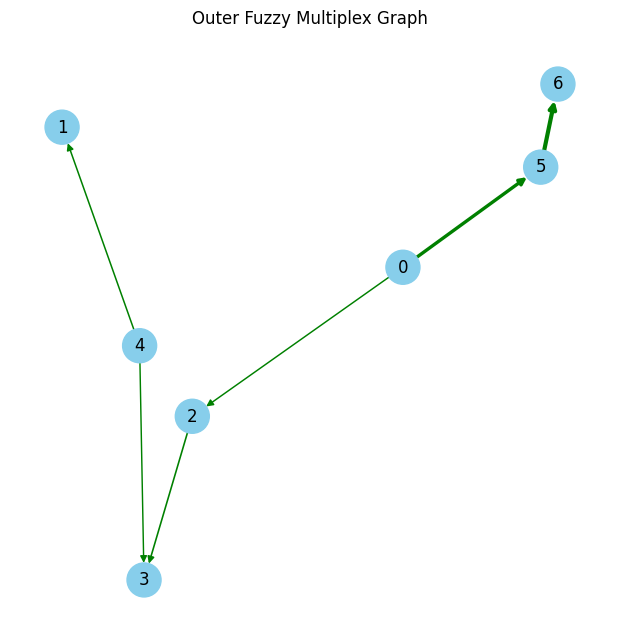

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

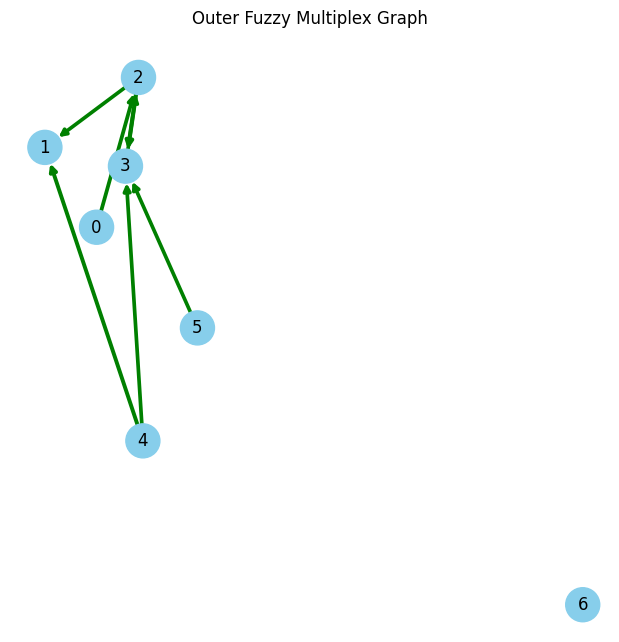

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

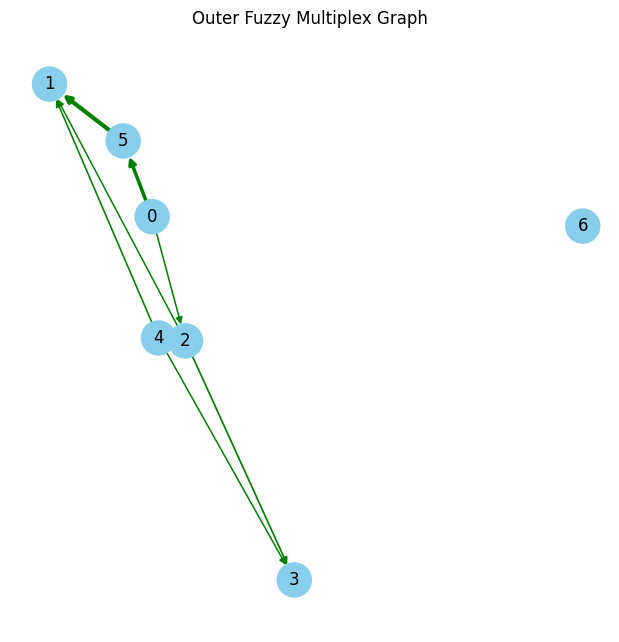

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.90  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.24  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

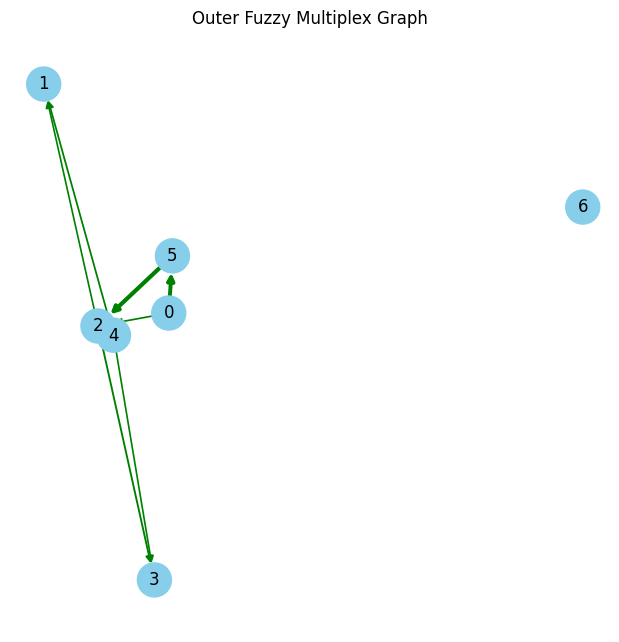

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.96  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.27  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

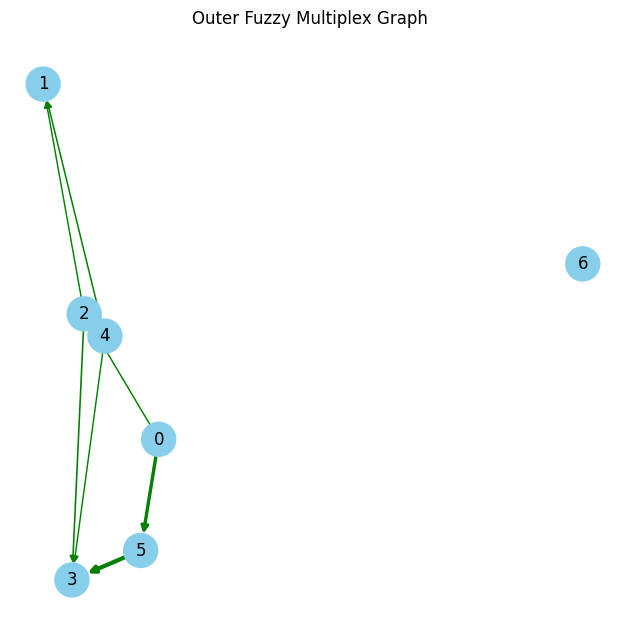

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

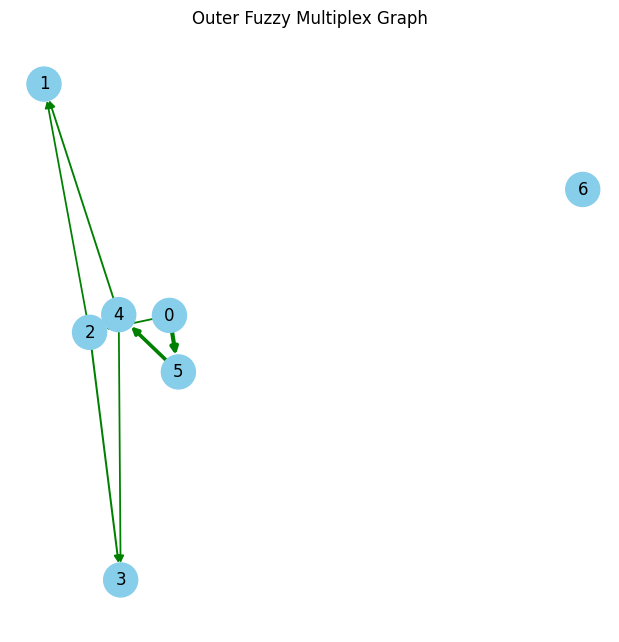

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  1.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.28  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.92  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

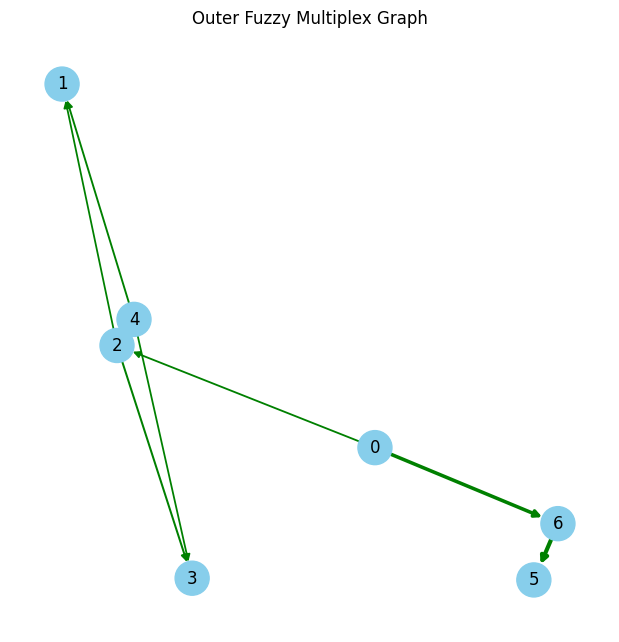

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.90 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

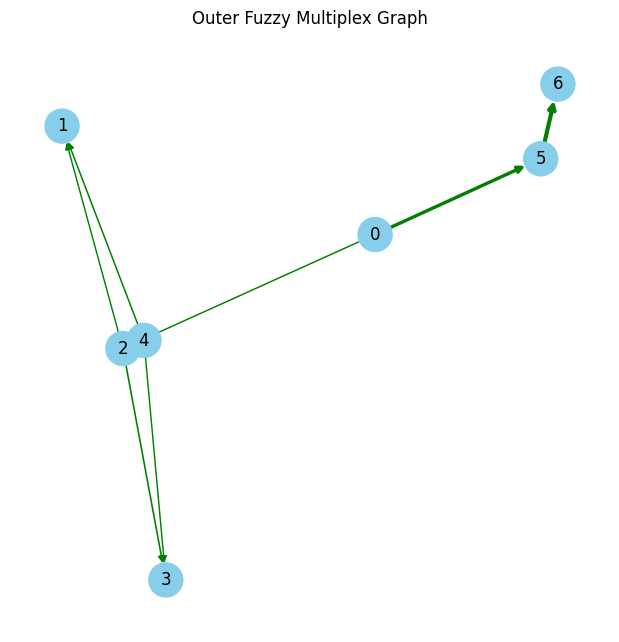

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

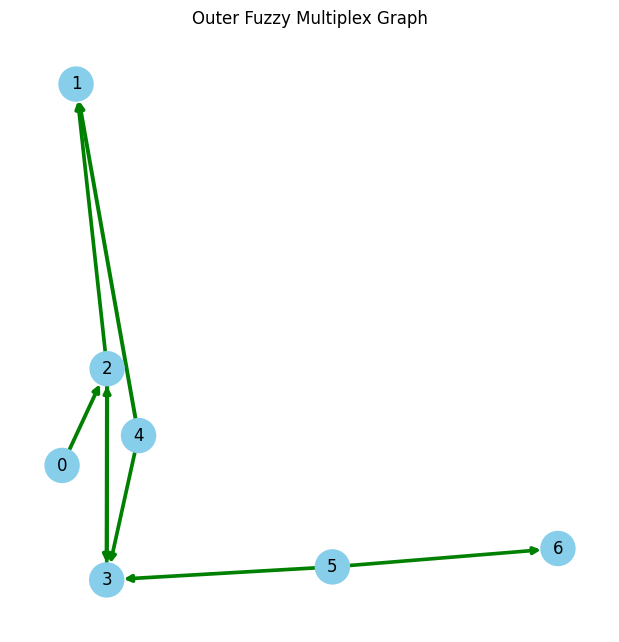

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.87 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

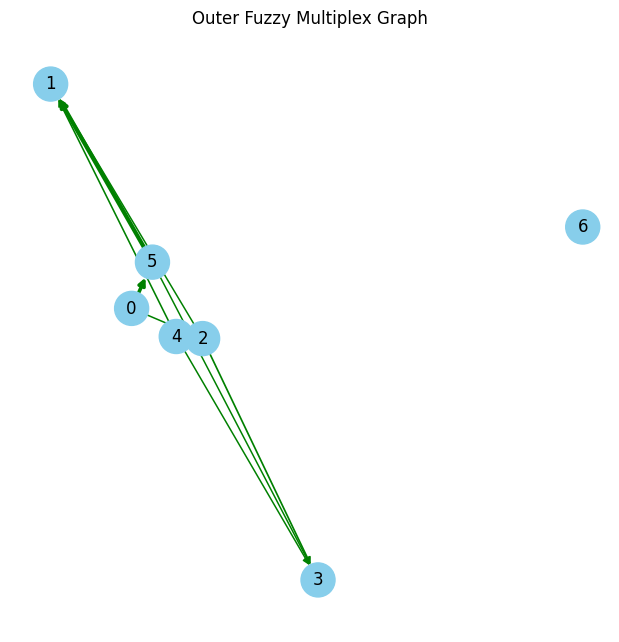

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.90  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.24  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.24  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

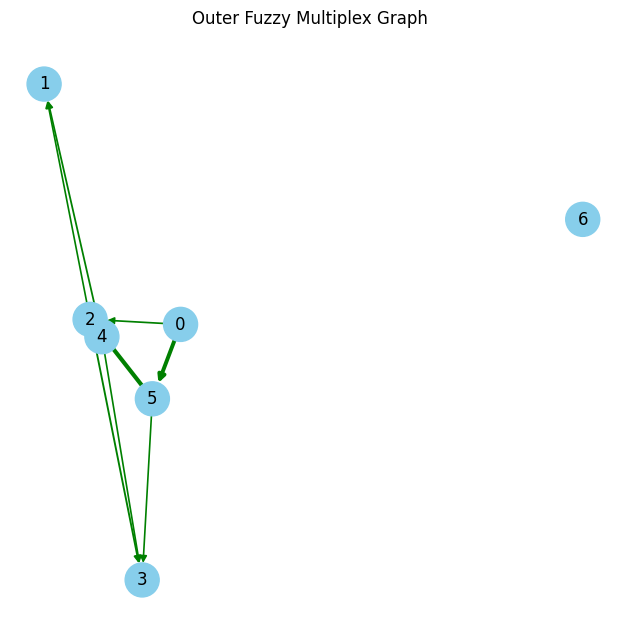

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.96  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.27  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.27  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

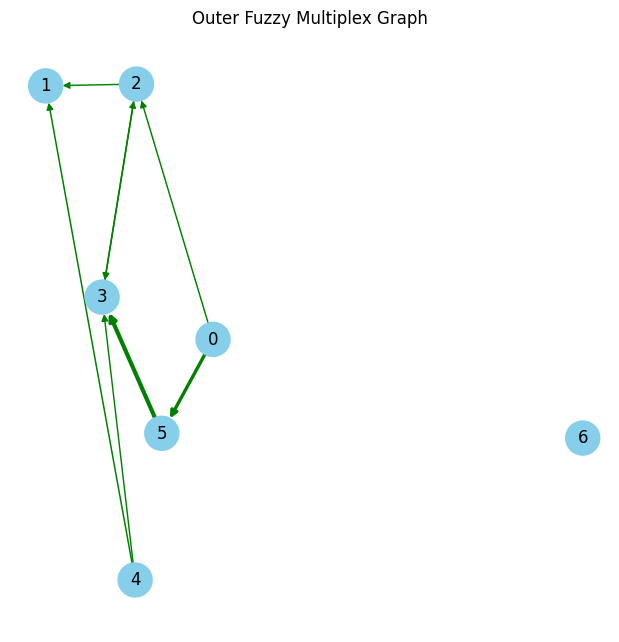

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.22  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

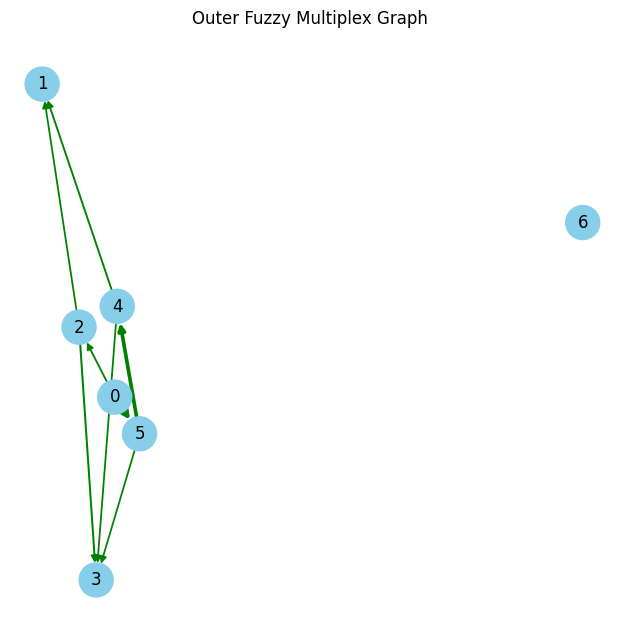

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  1.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.28  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.92  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

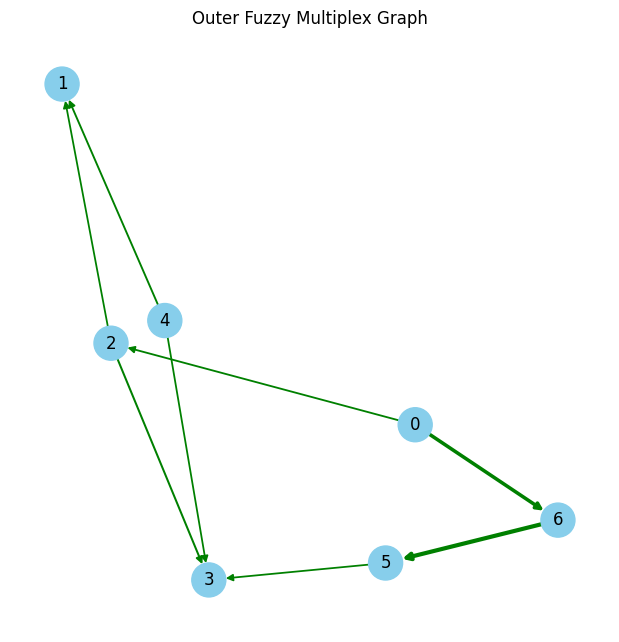

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.90 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

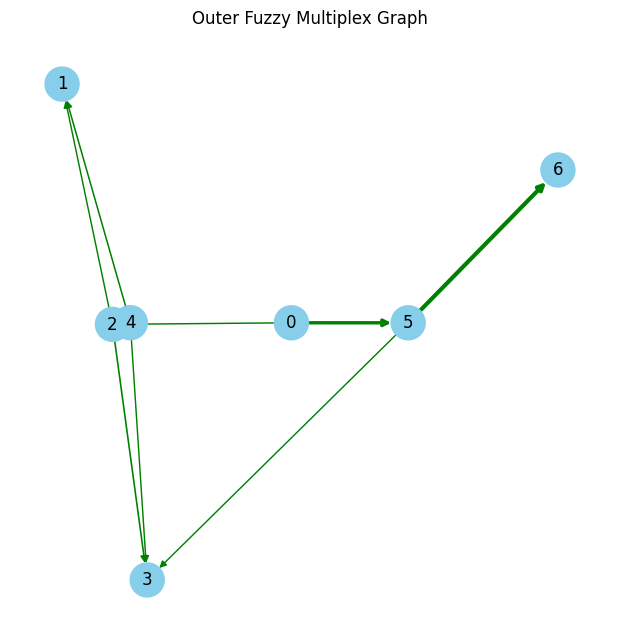

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.23  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

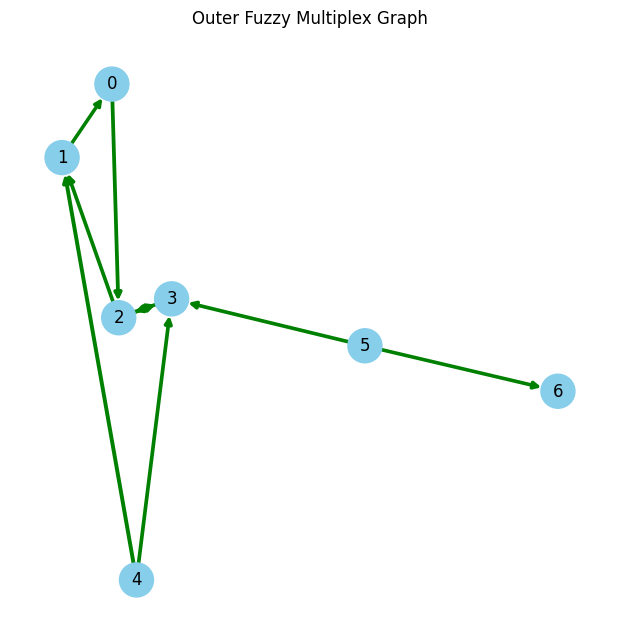

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.85  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.87 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

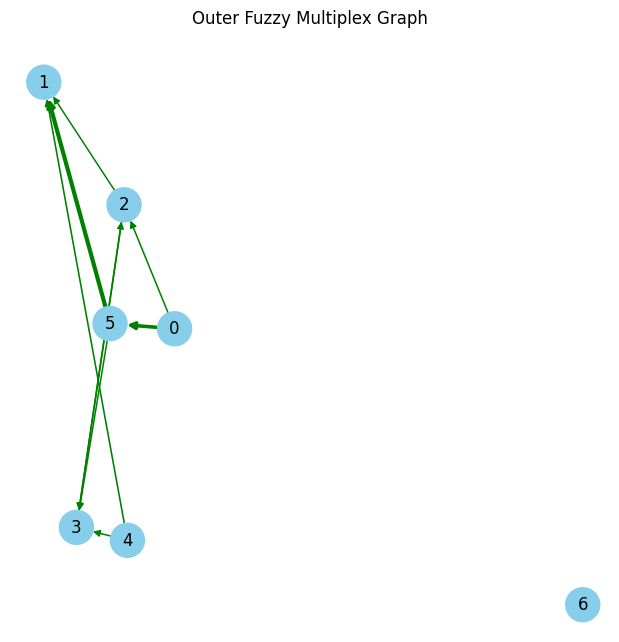

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.90  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.24  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.24  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

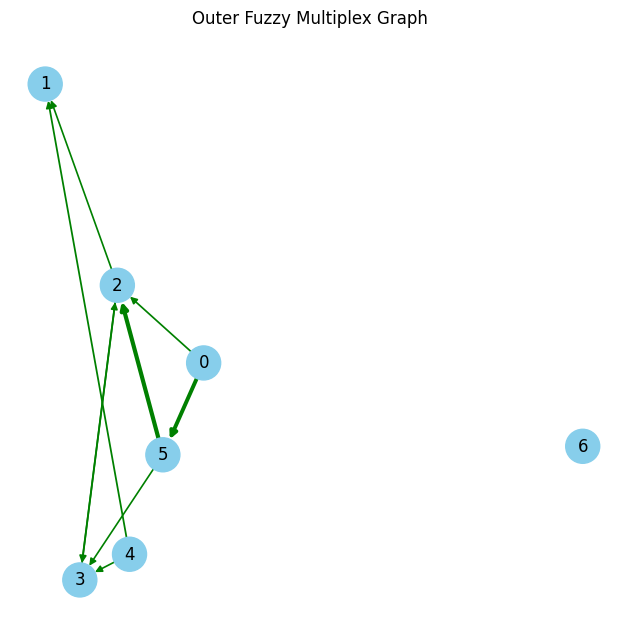

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.96  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.27  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.26  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.27  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

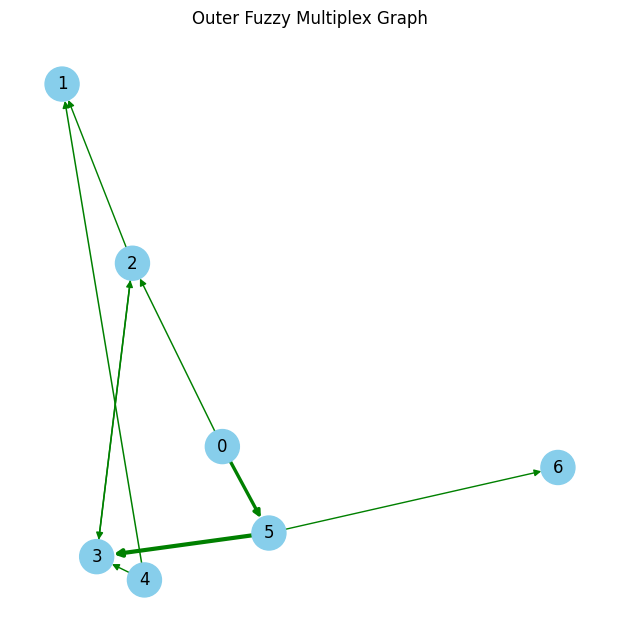

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.22  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.22 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

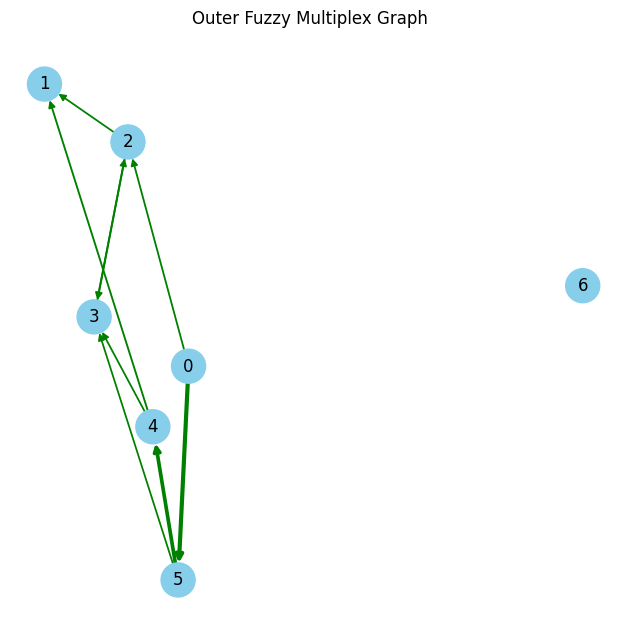

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  1.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.28  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.28  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.92  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

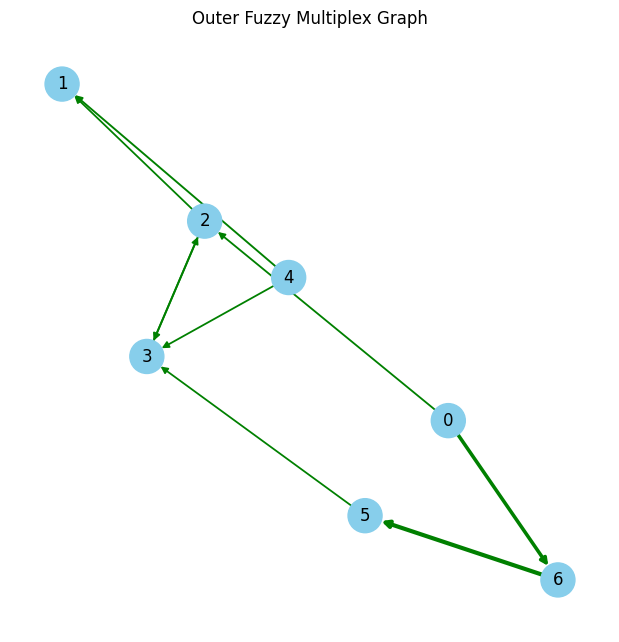

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.90 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.28  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

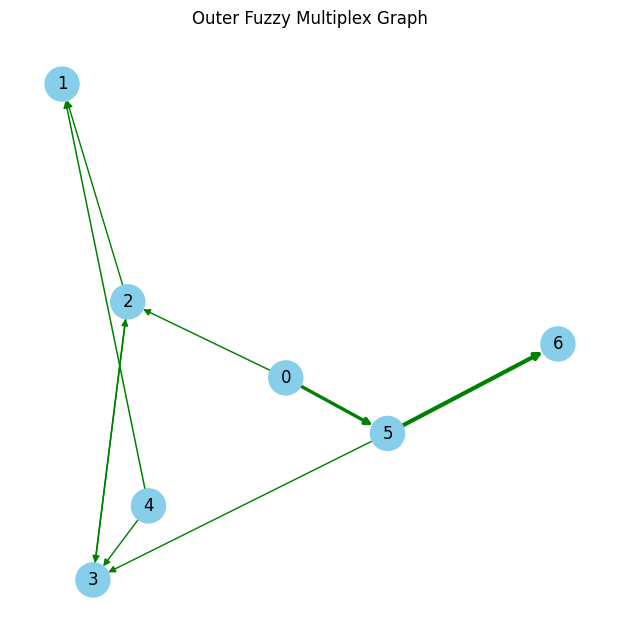

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.87  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.23  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

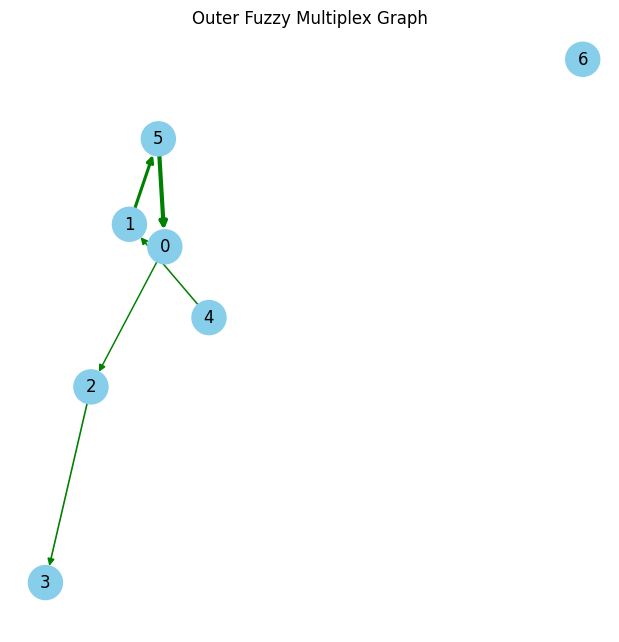

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.00  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

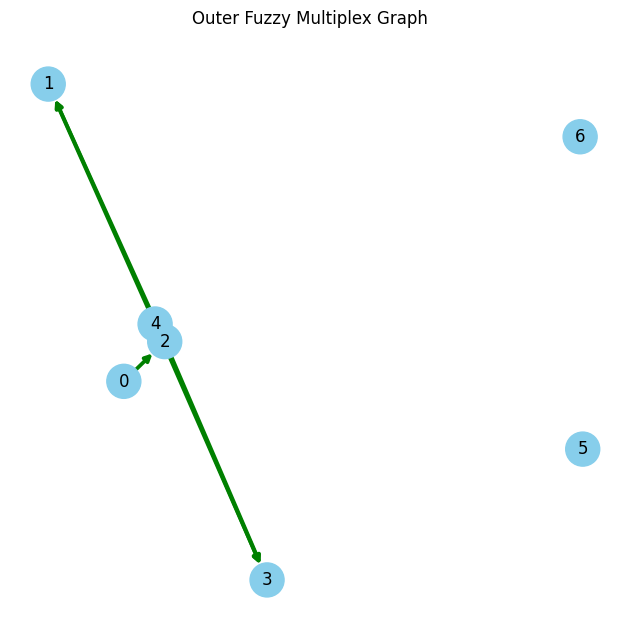

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

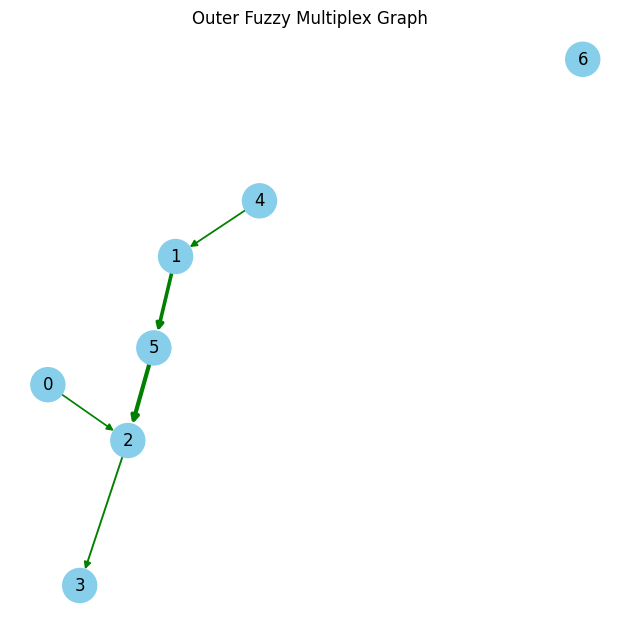

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.91  0.00 
N 2 |  0.00  0.00  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

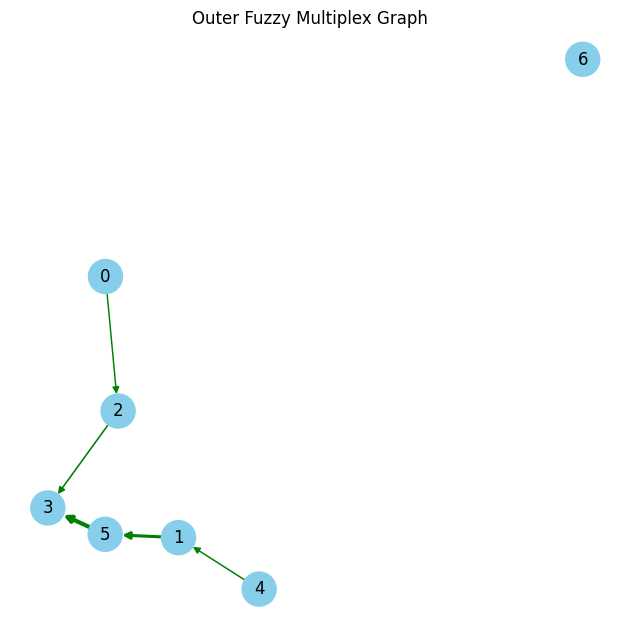

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

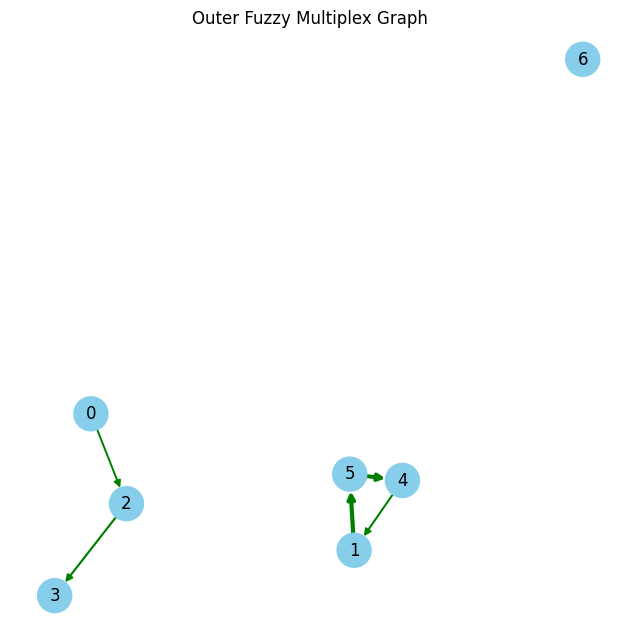

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.32  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 
N 2 |  0.00  0.00  0.00  0.35  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.33  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.97  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

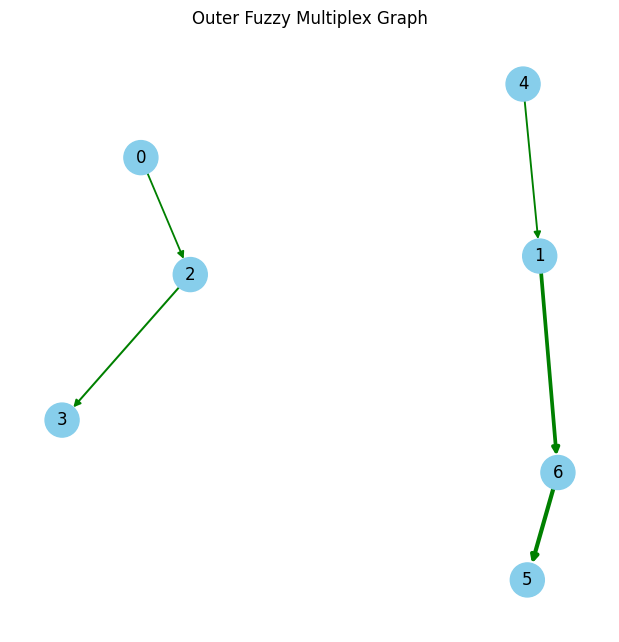

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.93 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

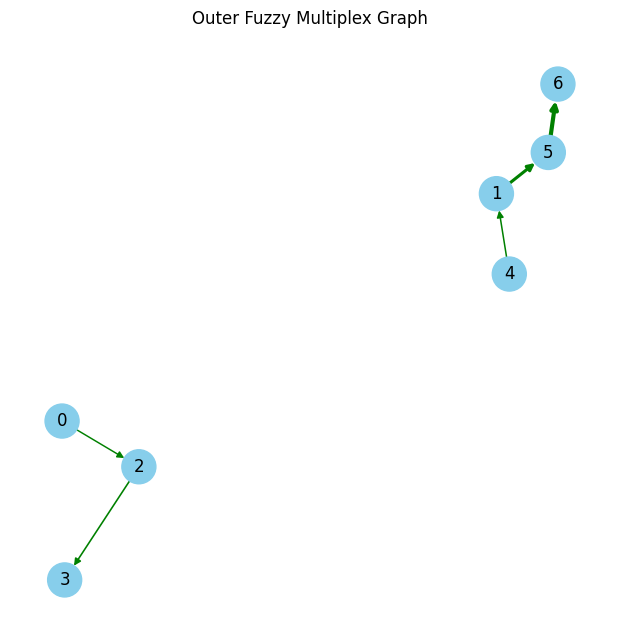

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

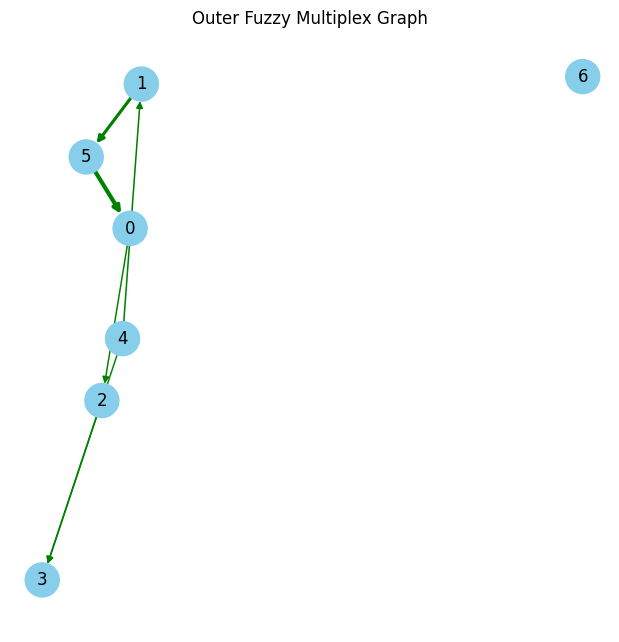

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

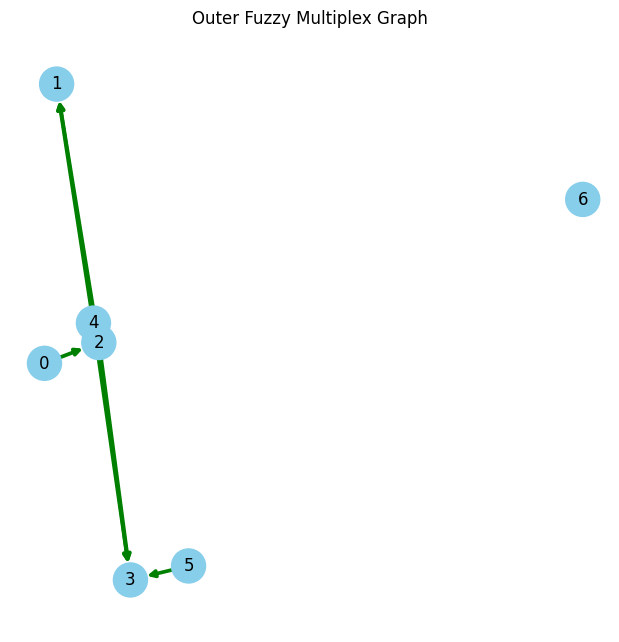

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

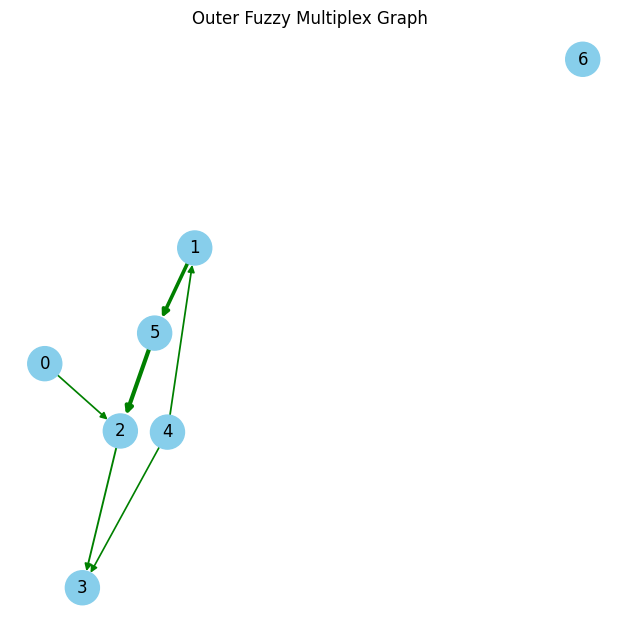

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.91  0.00 
N 2 |  0.00  0.00  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

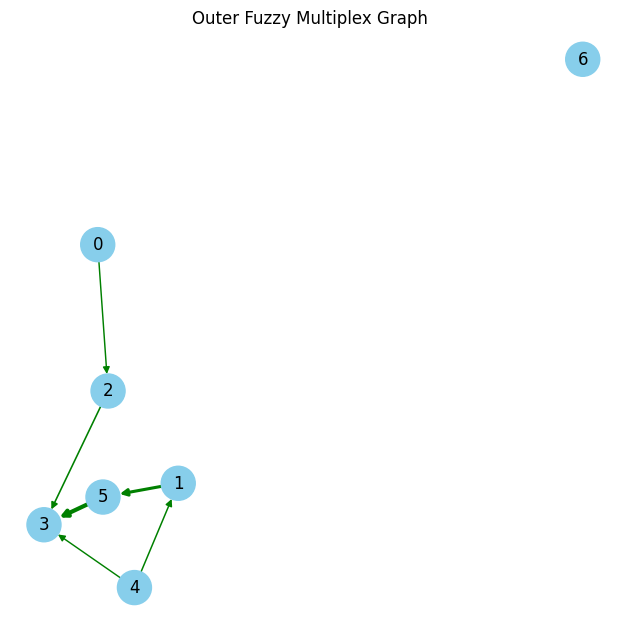

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

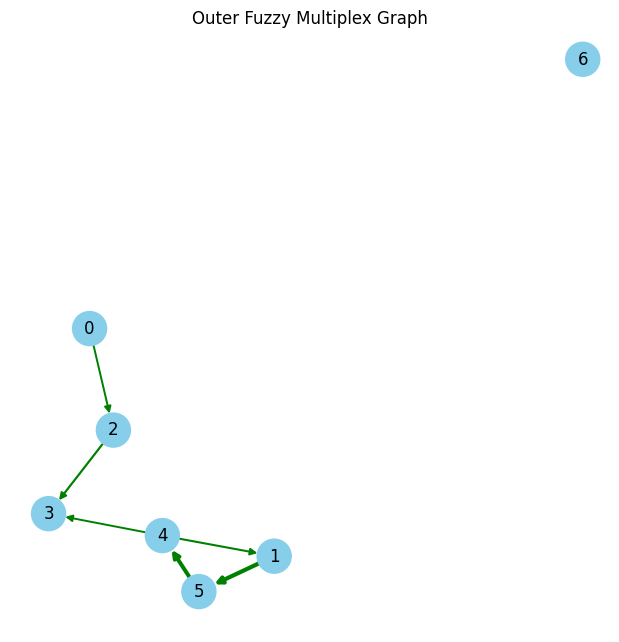

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.32  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 
N 2 |  0.00  0.00  0.00  0.35  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.33  0.00  0.31  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.97  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

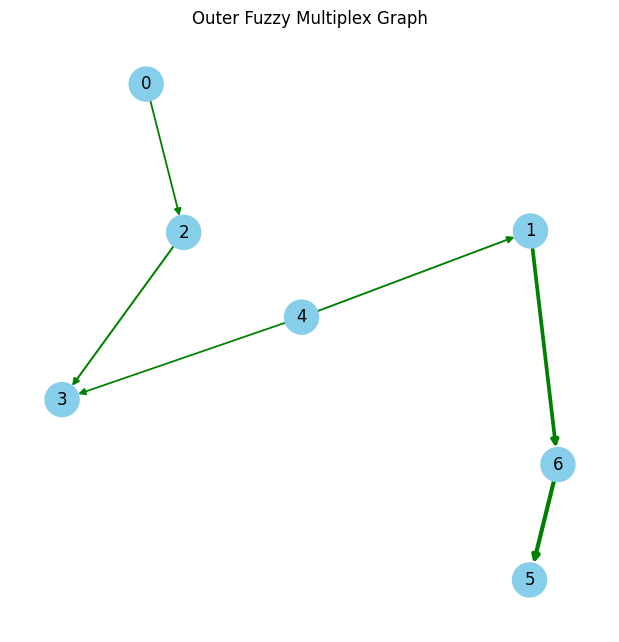

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.93 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

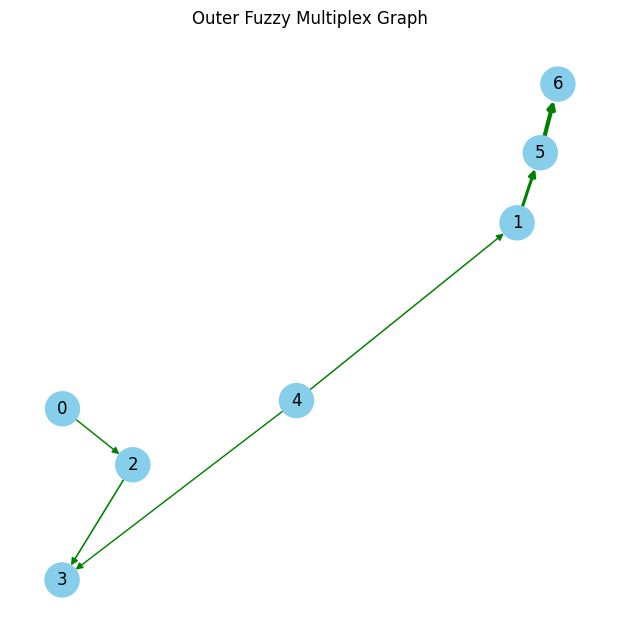

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

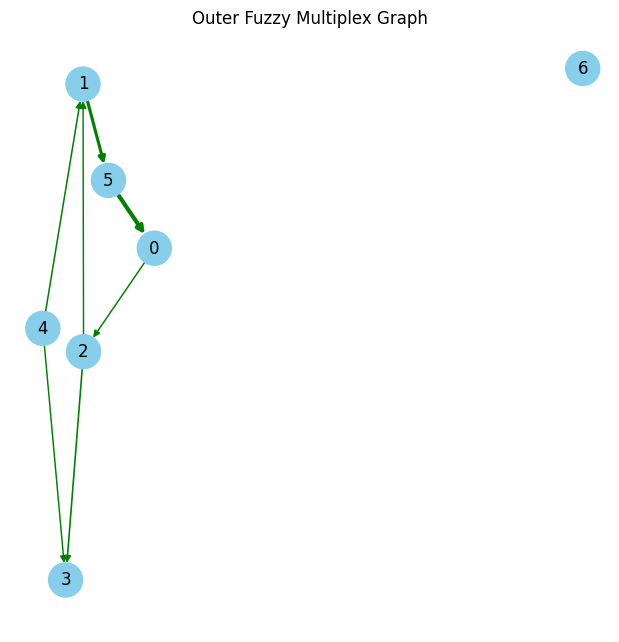

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

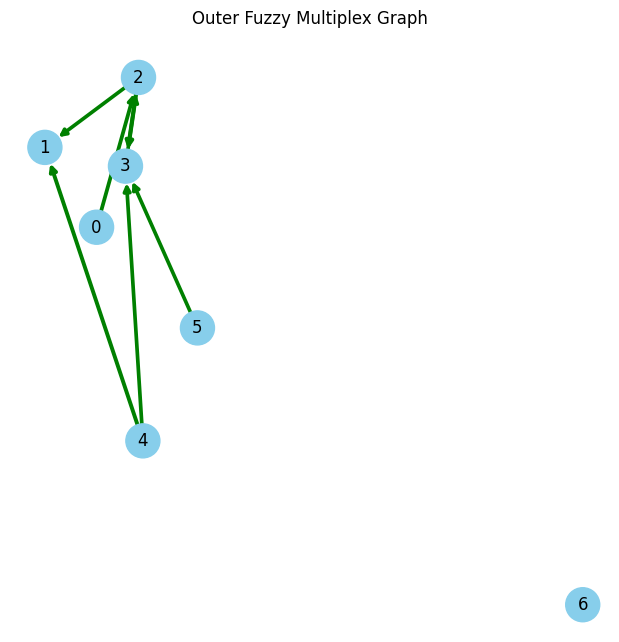

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

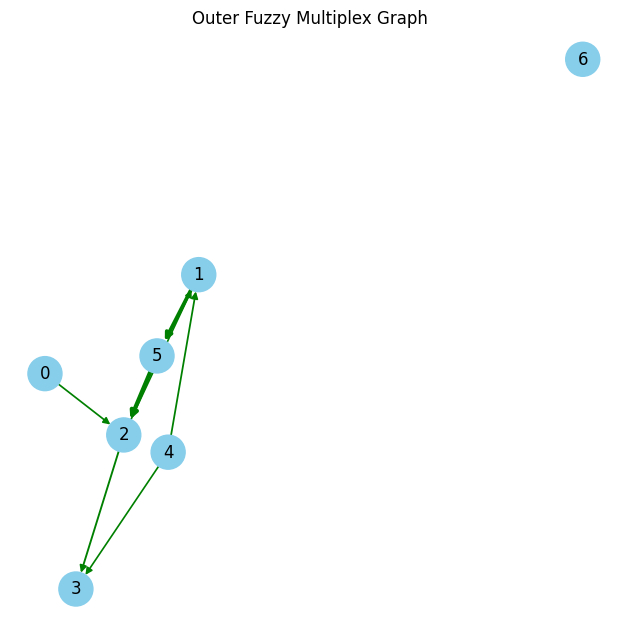

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.91  0.00 
N 2 |  0.00  0.27  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

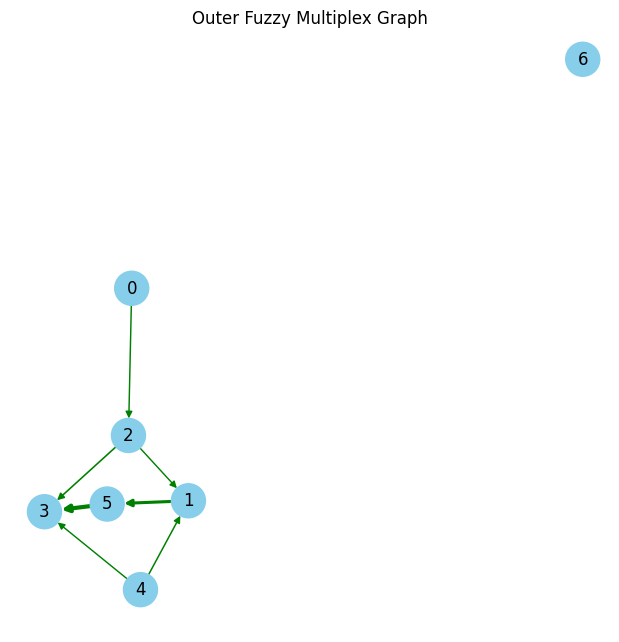

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

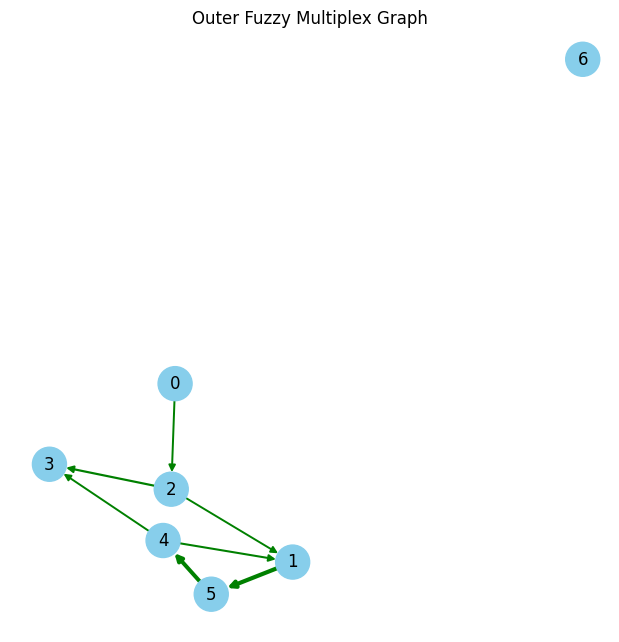

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.32  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 
N 2 |  0.00  0.31  0.00  0.35  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.33  0.00  0.31  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.97  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

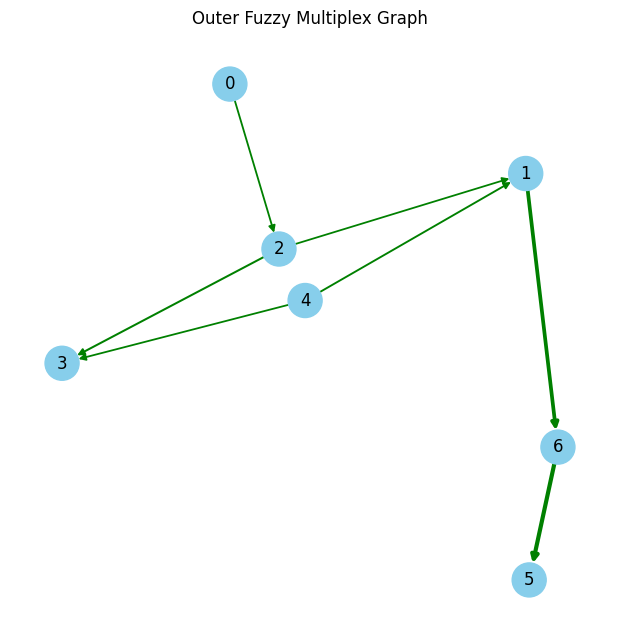

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.93 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

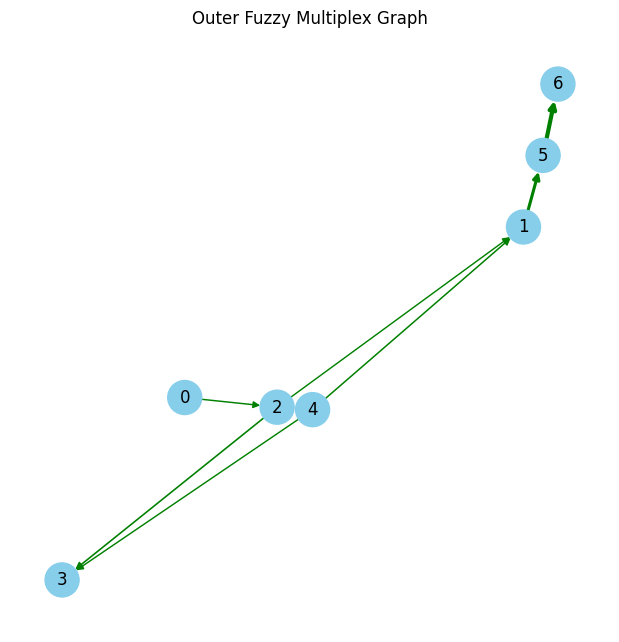

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

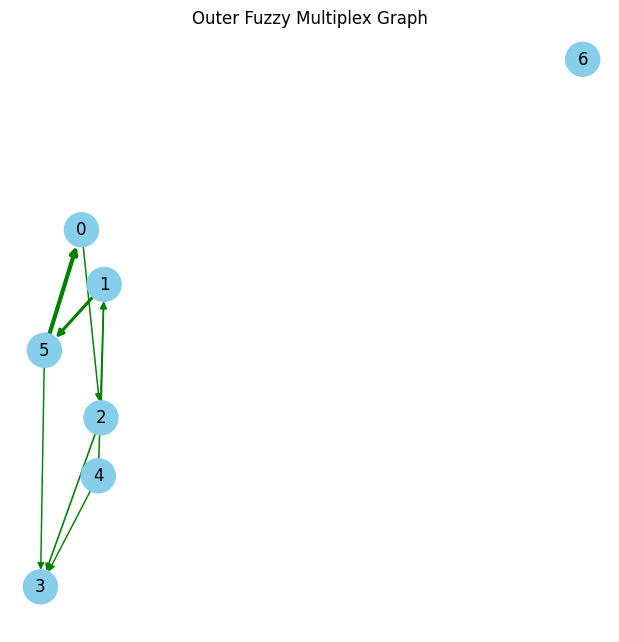

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.23  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

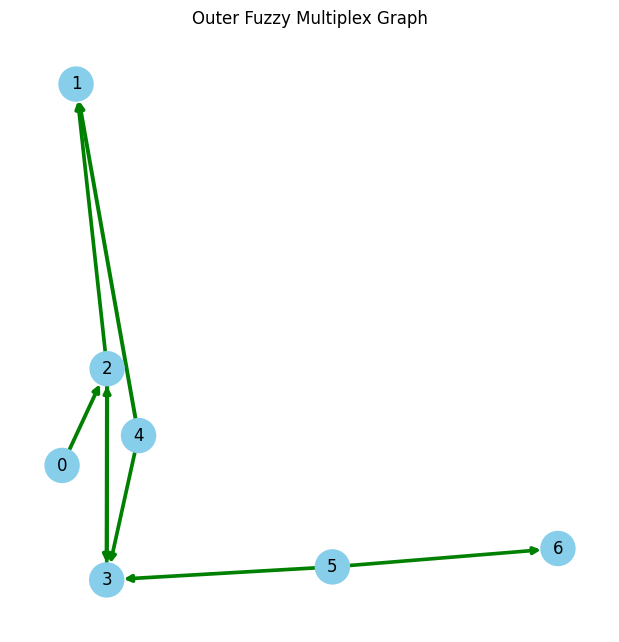

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.87 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

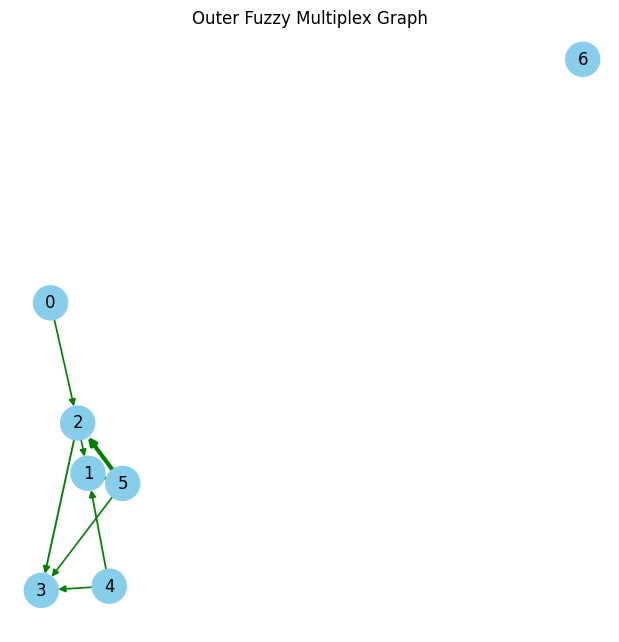

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.91  0.00 
N 2 |  0.00  0.27  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.27  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

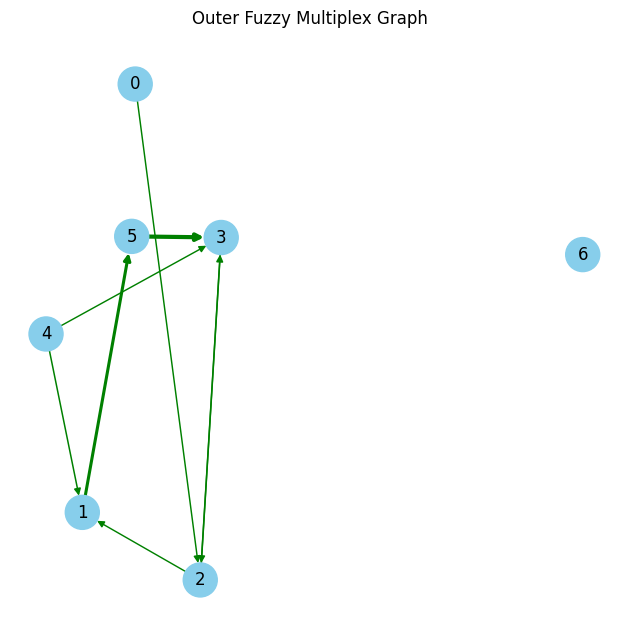

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.22  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

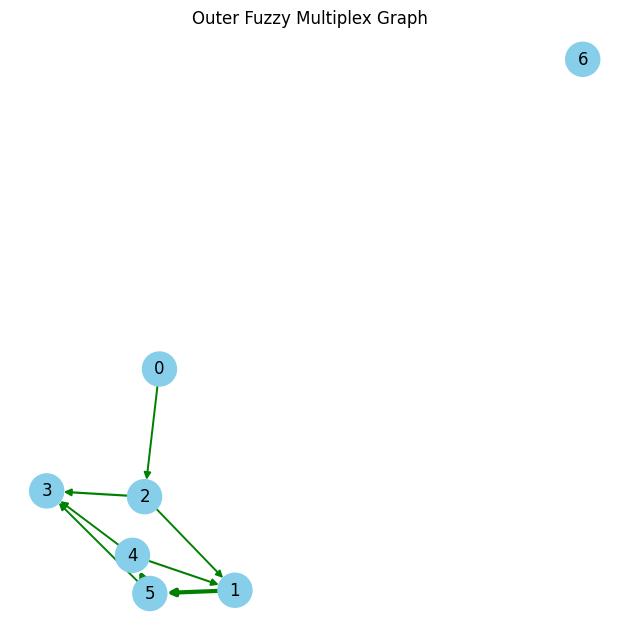

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.32  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 
N 2 |  0.00  0.31  0.00  0.35  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.33  0.00  0.31  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.31  0.97  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

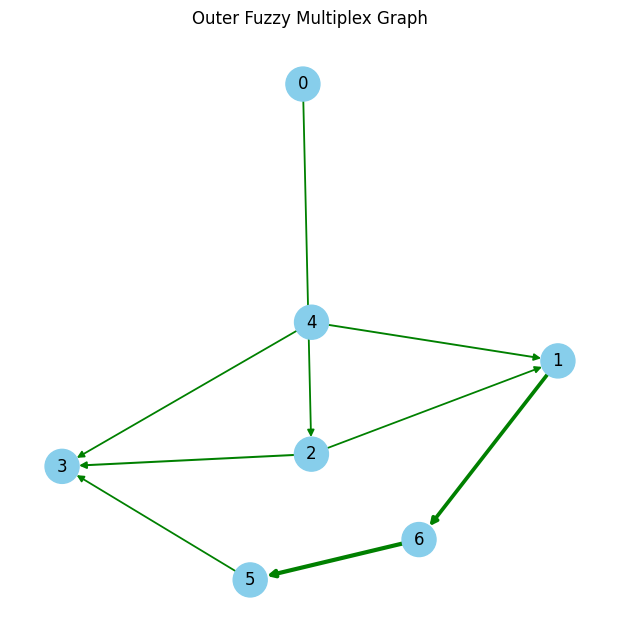

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.93 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

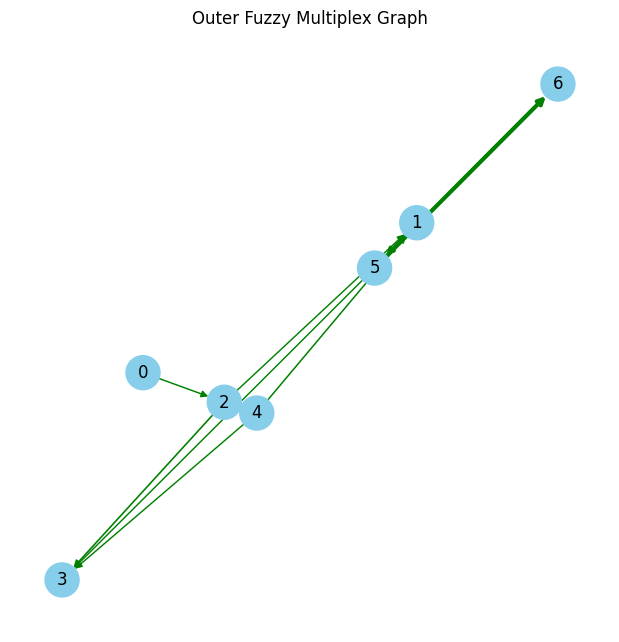

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.23  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

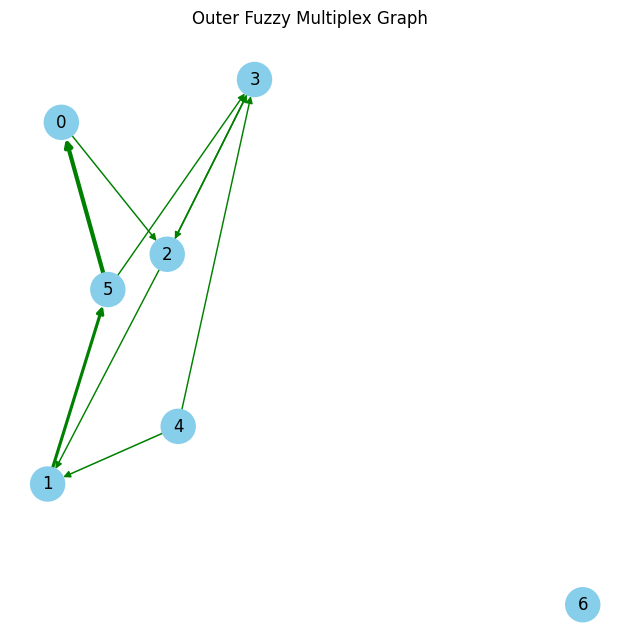

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.23  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

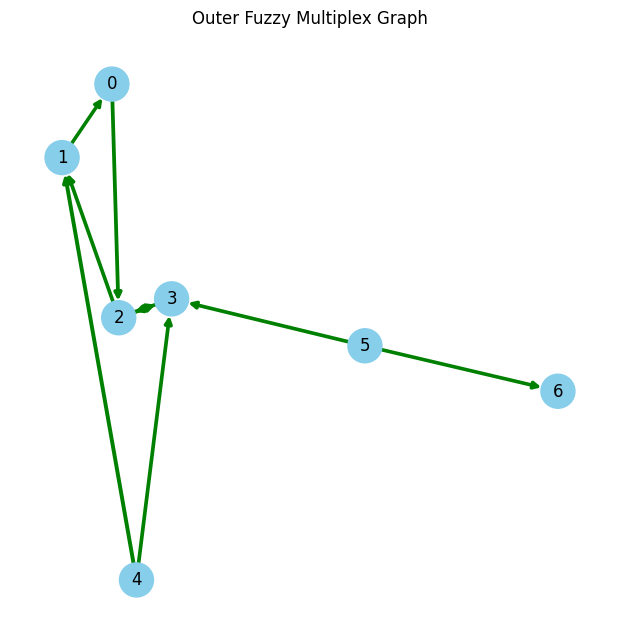

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.85  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.87 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

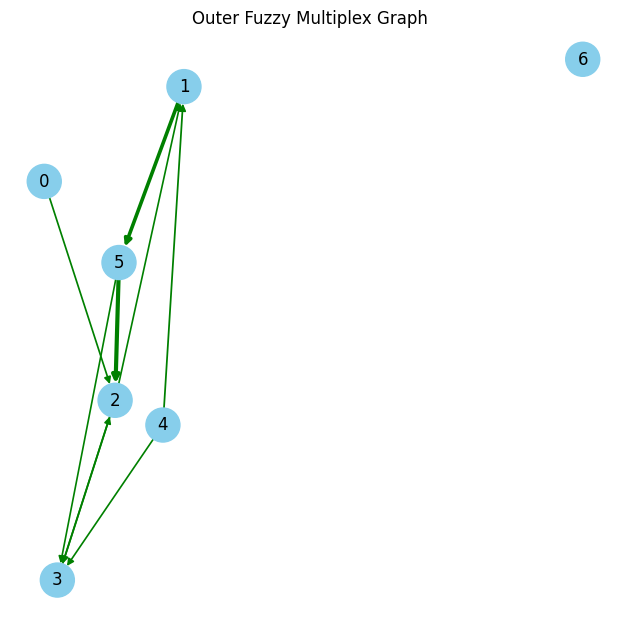

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.91  0.00 
N 2 |  0.00  0.27  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.26  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.27  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

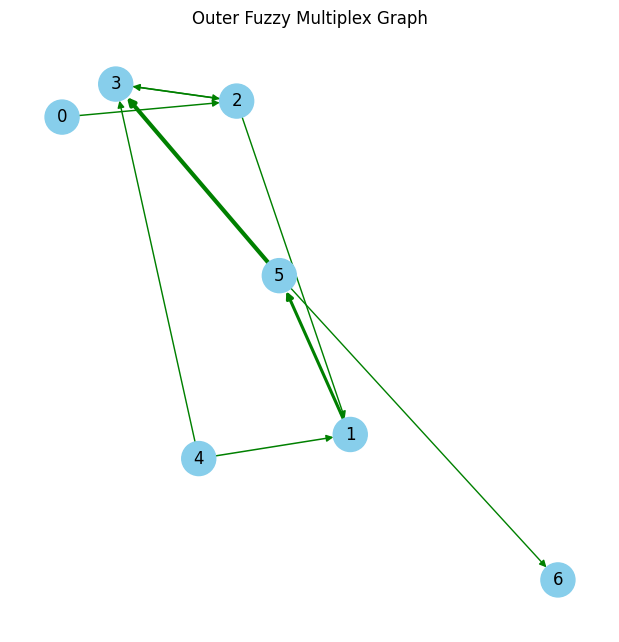

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.22  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.22 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

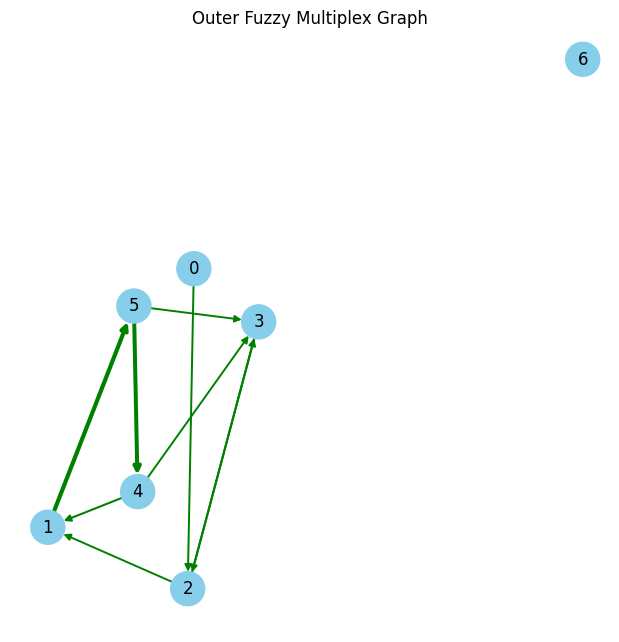

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.32  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 
N 2 |  0.00  0.31  0.00  0.35  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.30  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.33  0.00  0.31  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.31  0.97  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

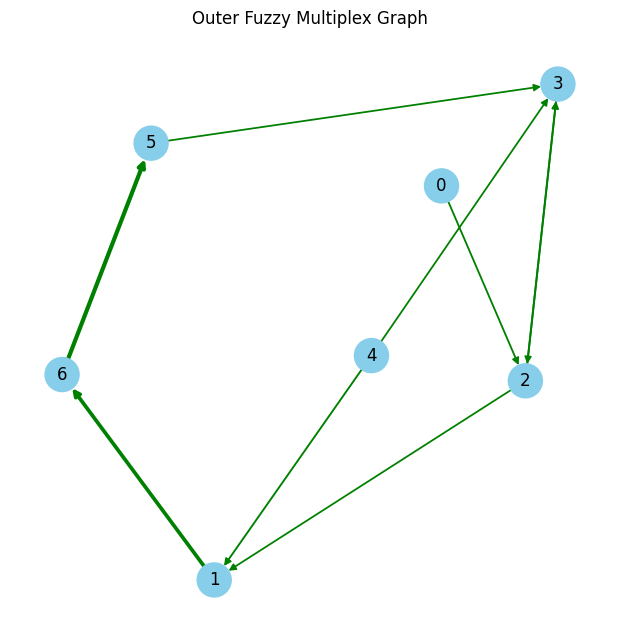

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.93 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.28  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

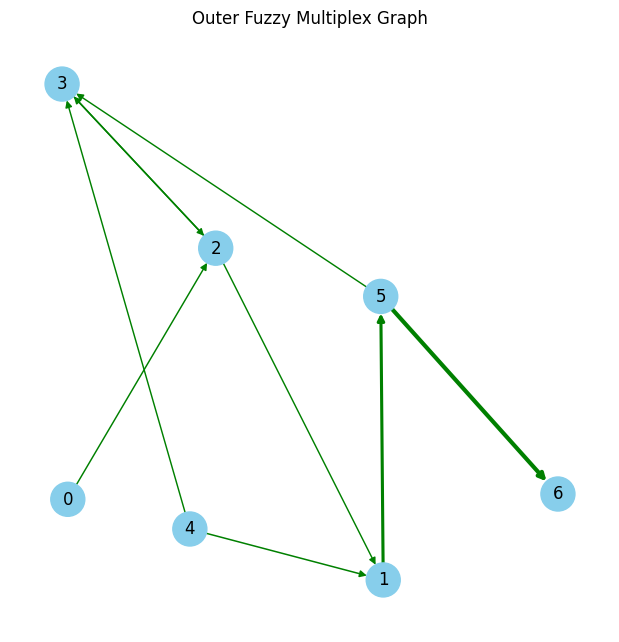

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.83  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.23  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

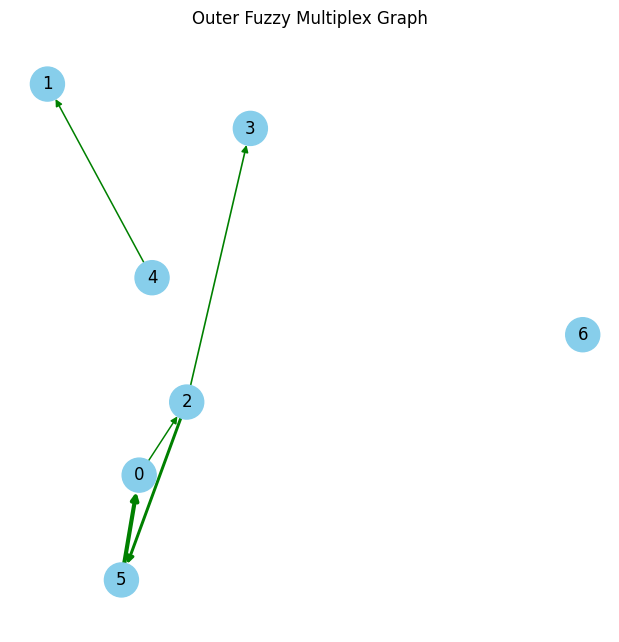

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.81  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.00  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

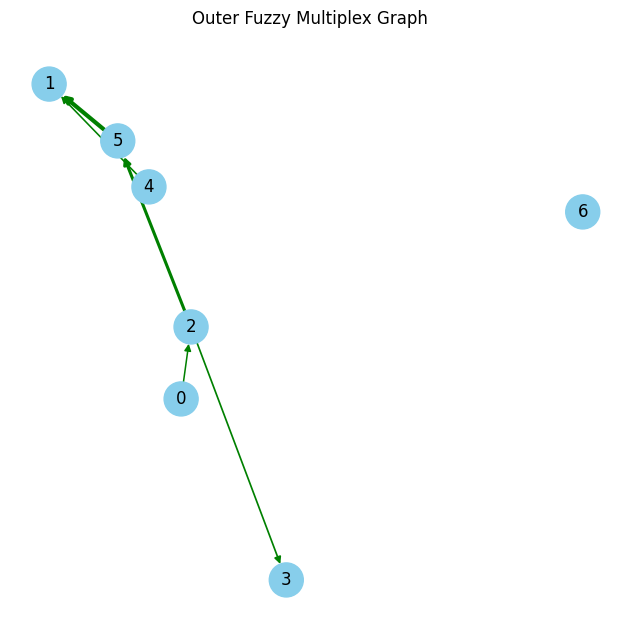

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.27  0.00  0.83  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

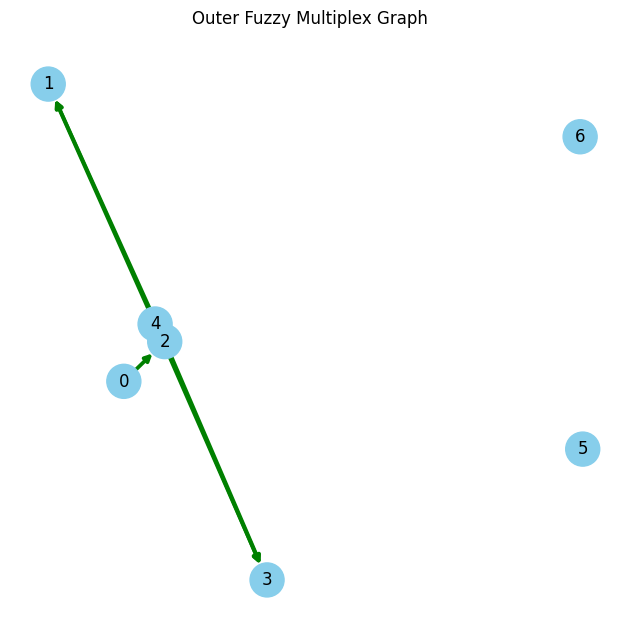

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

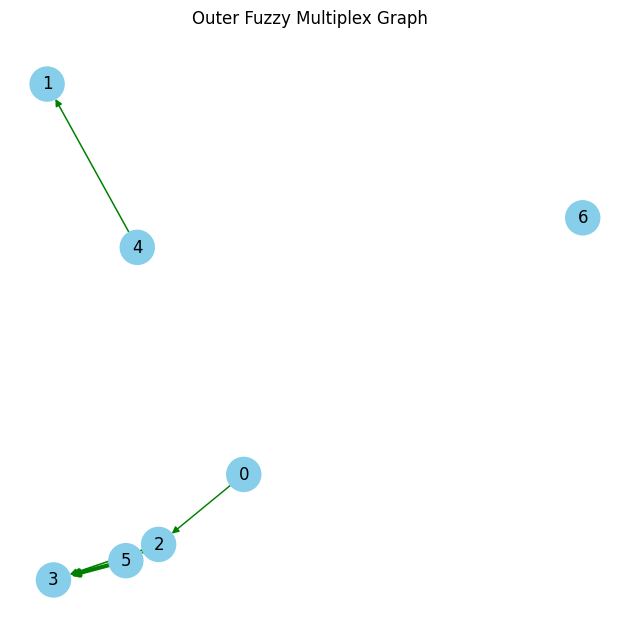

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

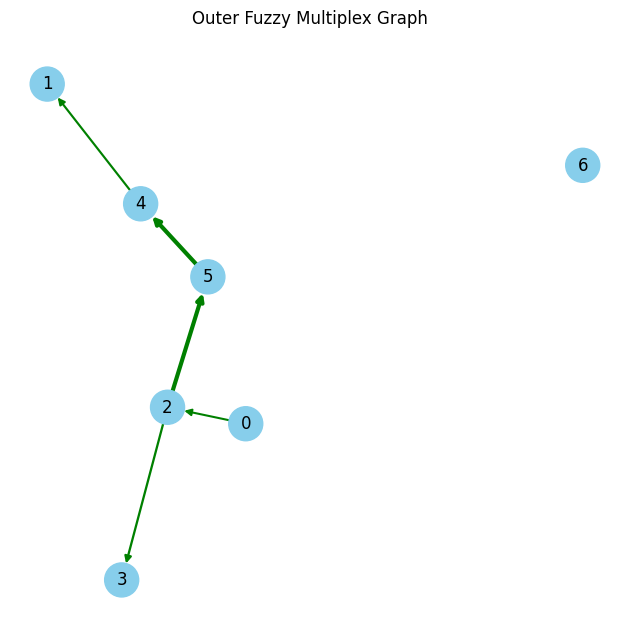

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.33  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.36  0.00  1.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.34  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  1.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

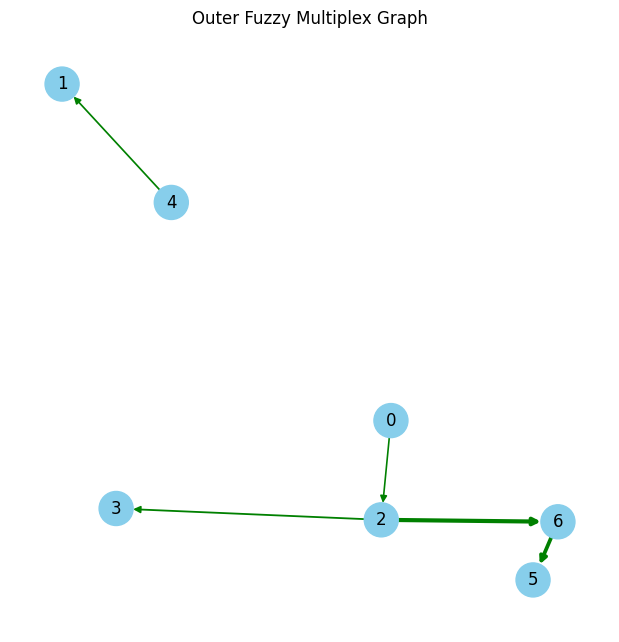

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.26  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.29  0.00  0.00  1.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.27  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.93  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

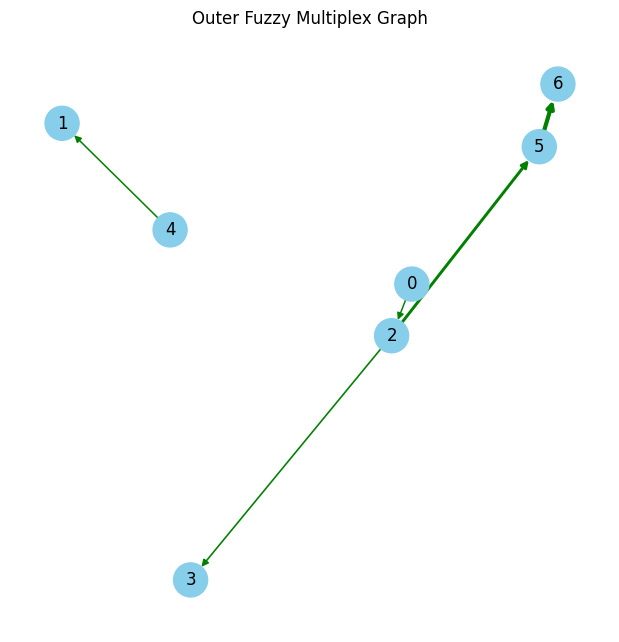

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

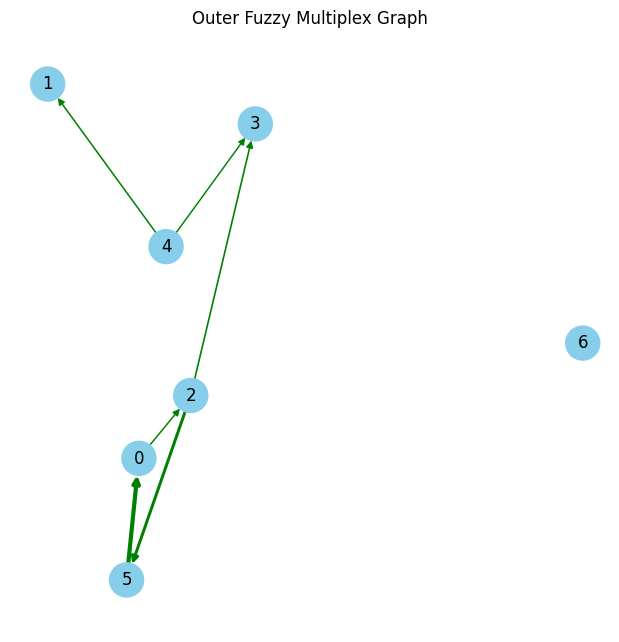

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.81  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

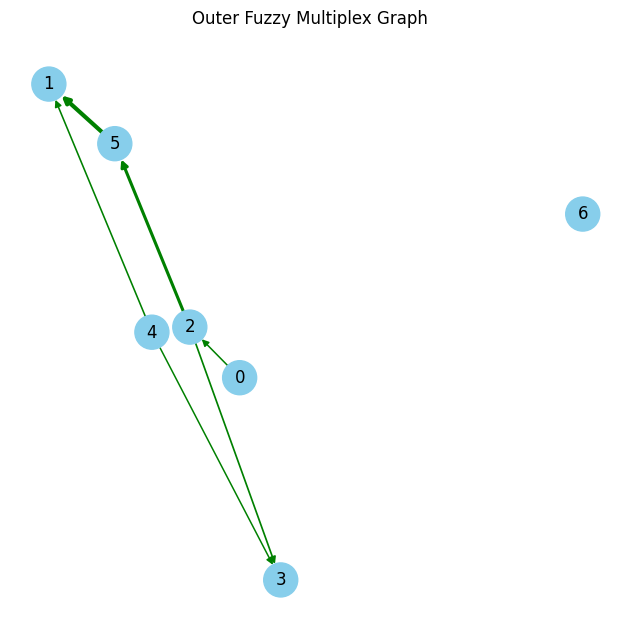

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.27  0.00  0.83  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

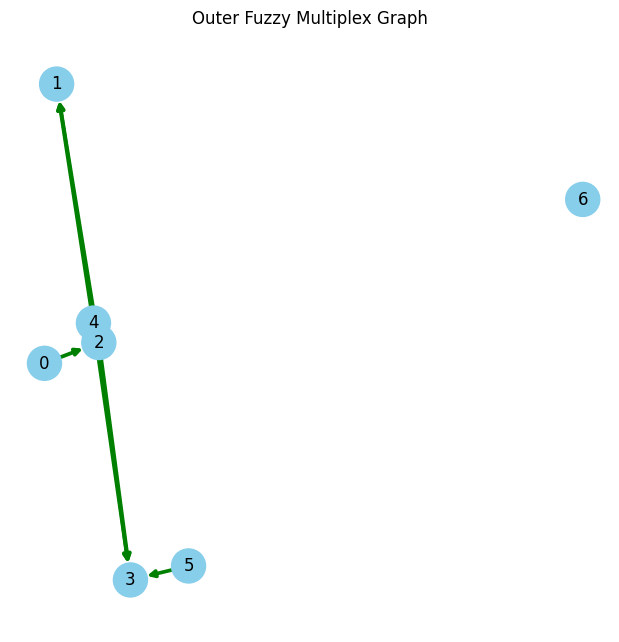

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

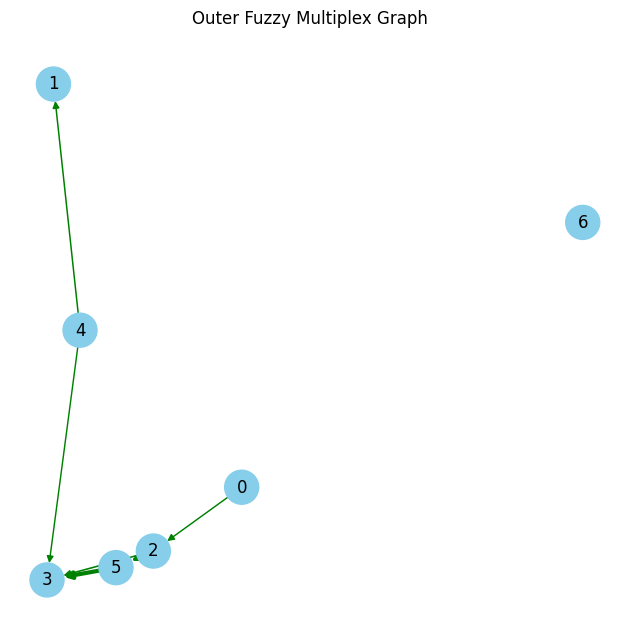

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

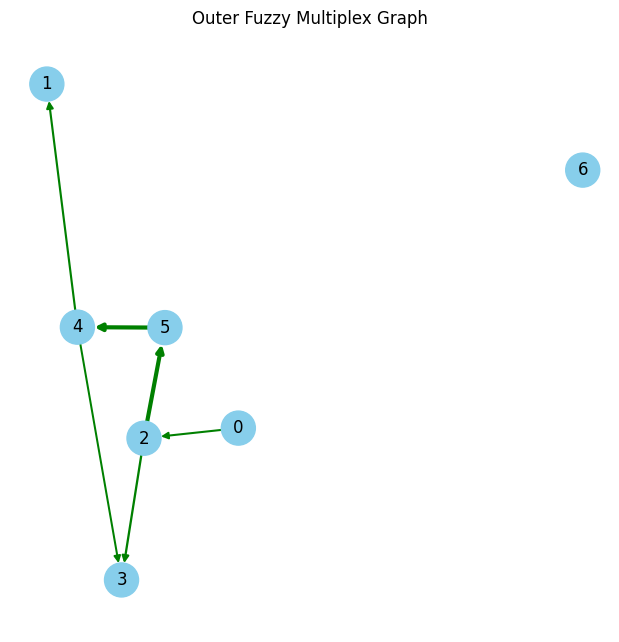

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.33  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.36  0.00  1.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.34  0.00  0.32  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  1.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

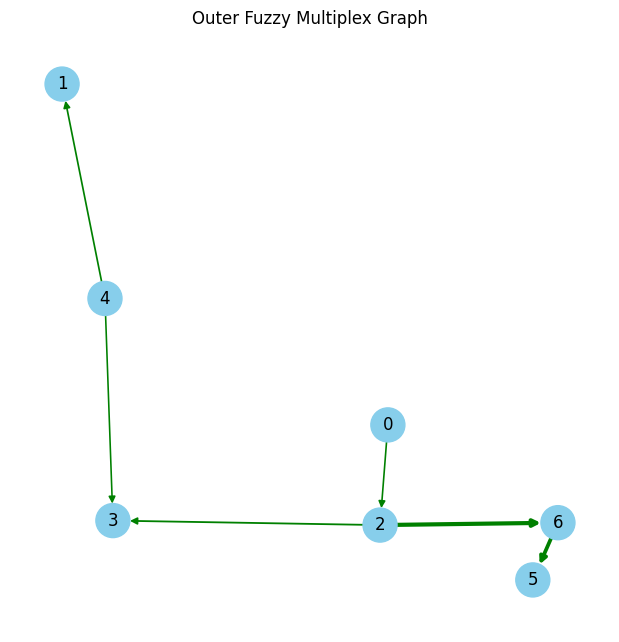

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.26  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.29  0.00  0.00  1.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.27  0.00  0.26  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.93  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

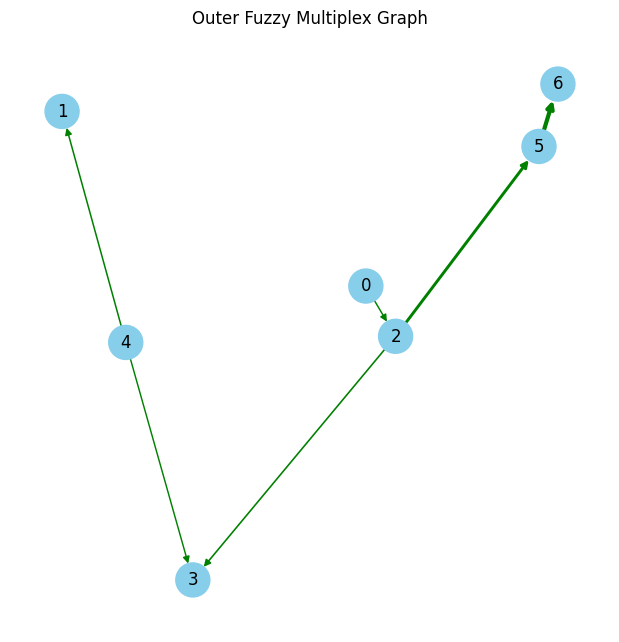

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

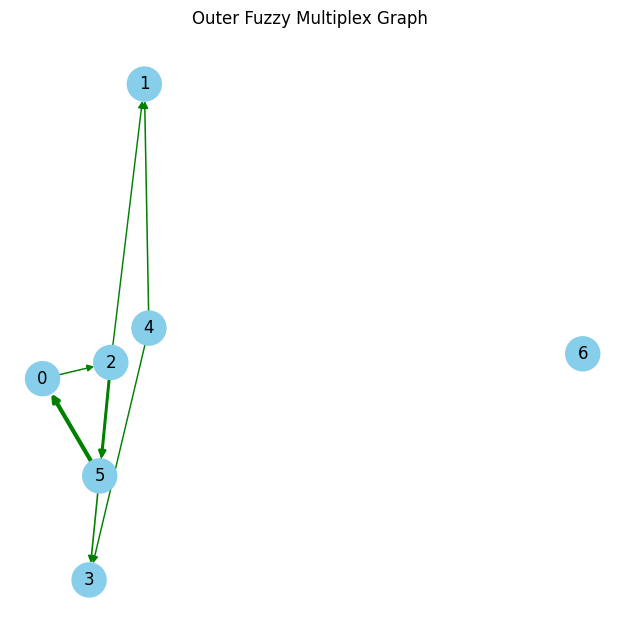

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.81  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

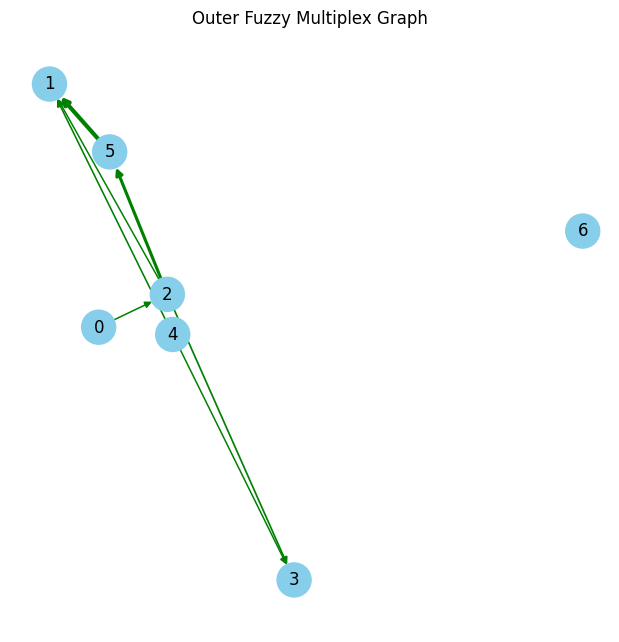

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.24  0.00  0.27  0.00  0.83  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

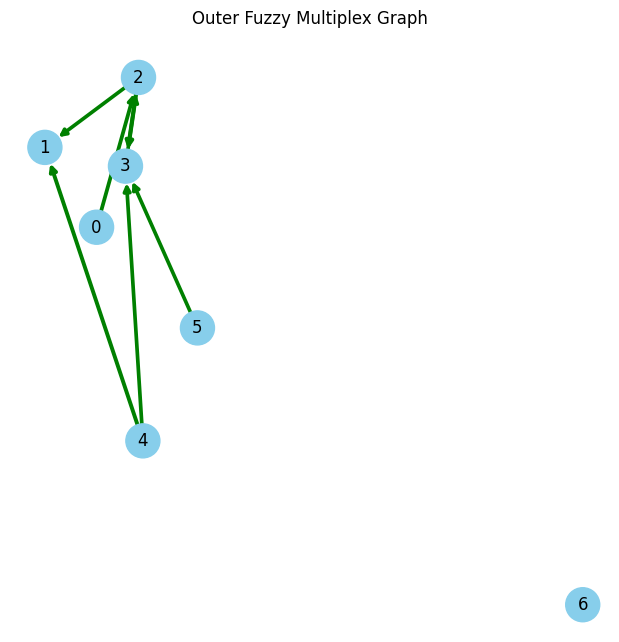

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

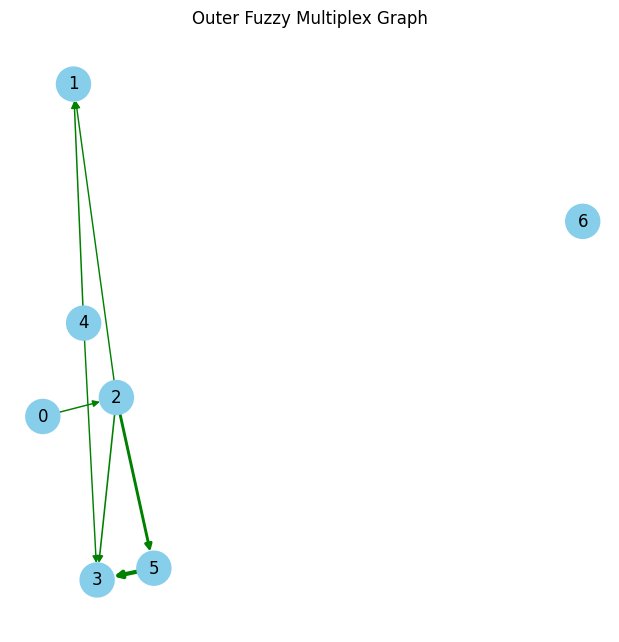

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

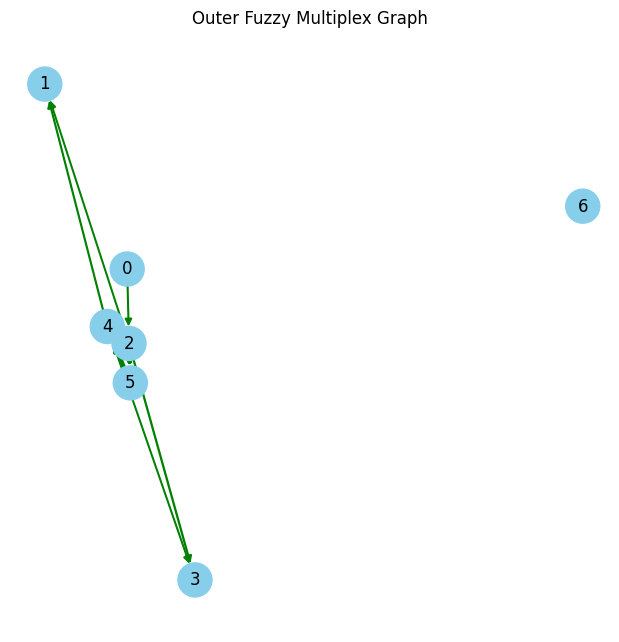

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.33  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.32  0.00  0.36  0.00  1.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.34  0.00  0.32  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  1.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

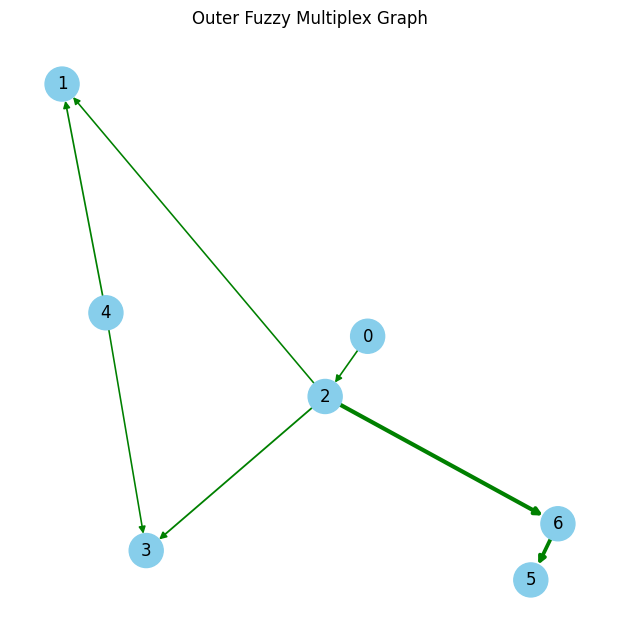

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.26  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.26  0.00  0.29  0.00  0.00  1.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.27  0.00  0.26  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.93  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

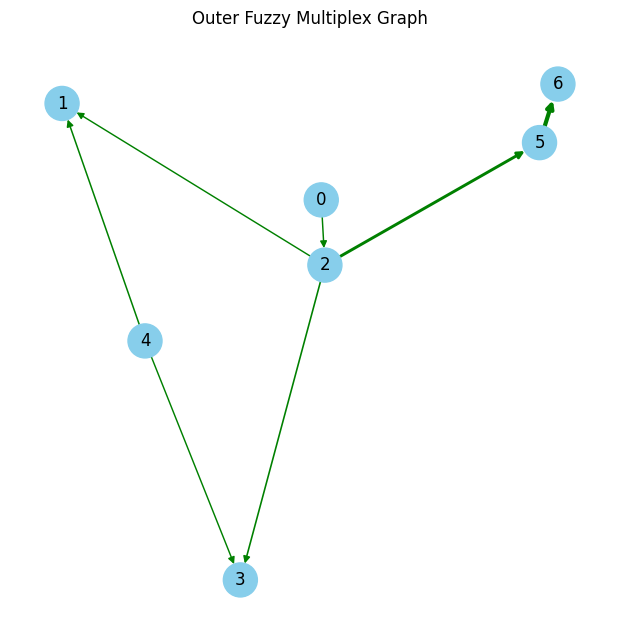

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

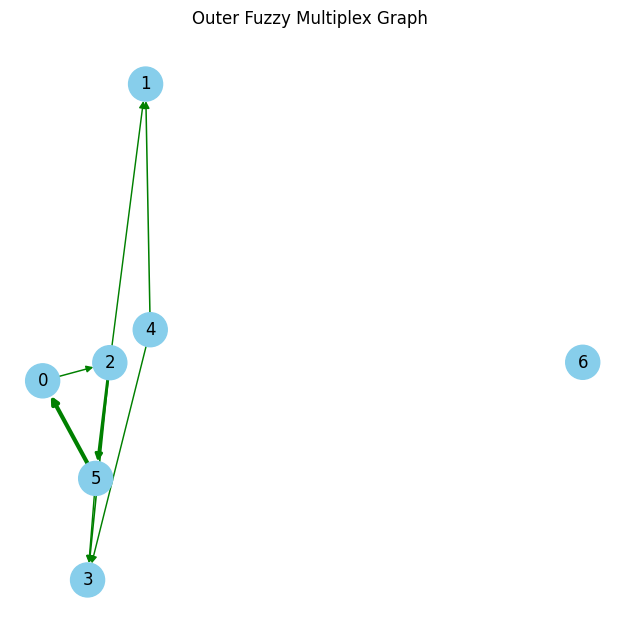

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.81  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.23  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

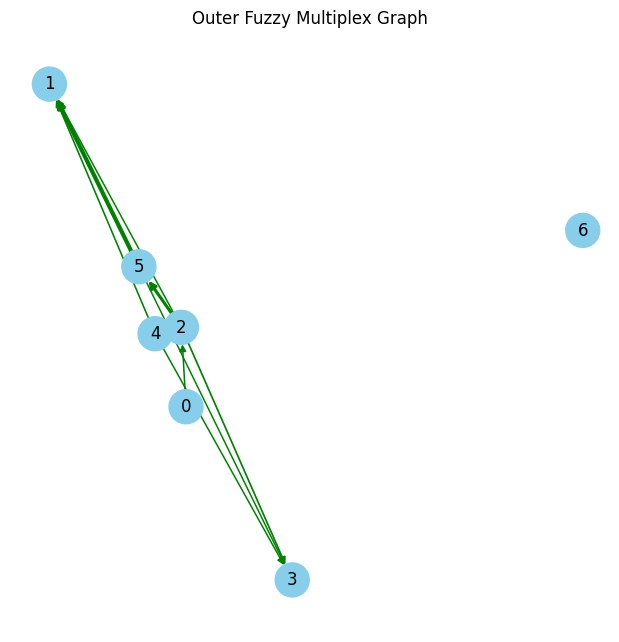

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.24  0.00  0.27  0.00  0.83  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.24  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

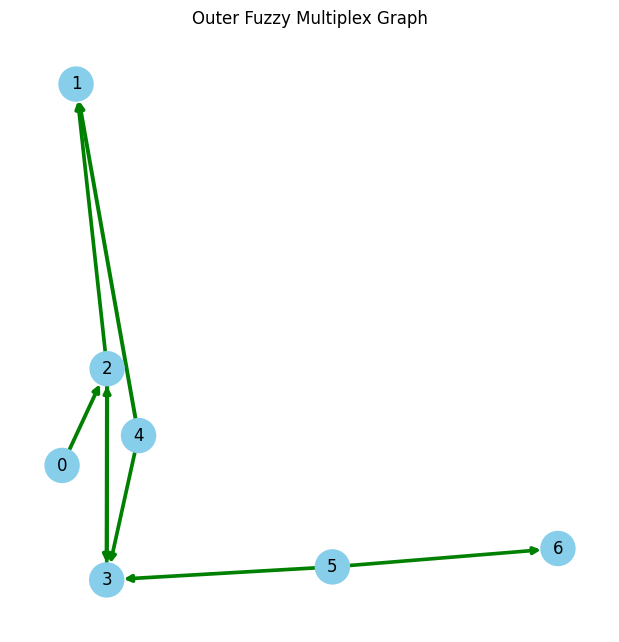

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.87 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

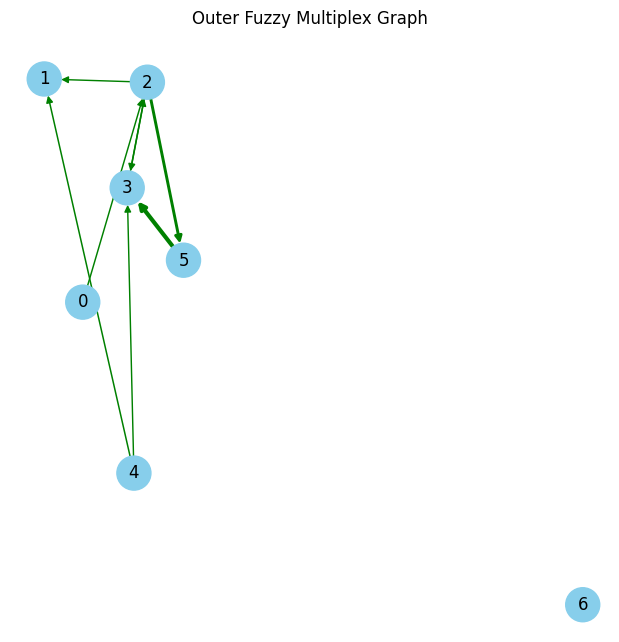

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.22  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

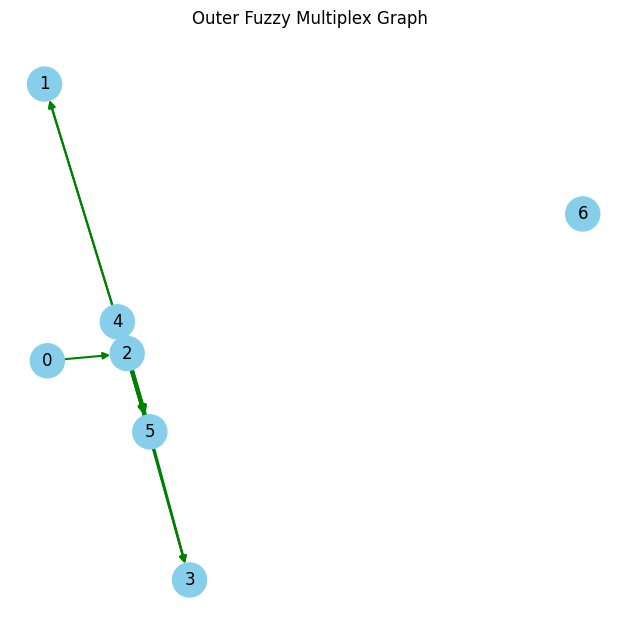

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.33  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.32  0.00  0.36  0.00  1.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.34  0.00  0.32  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.32  1.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

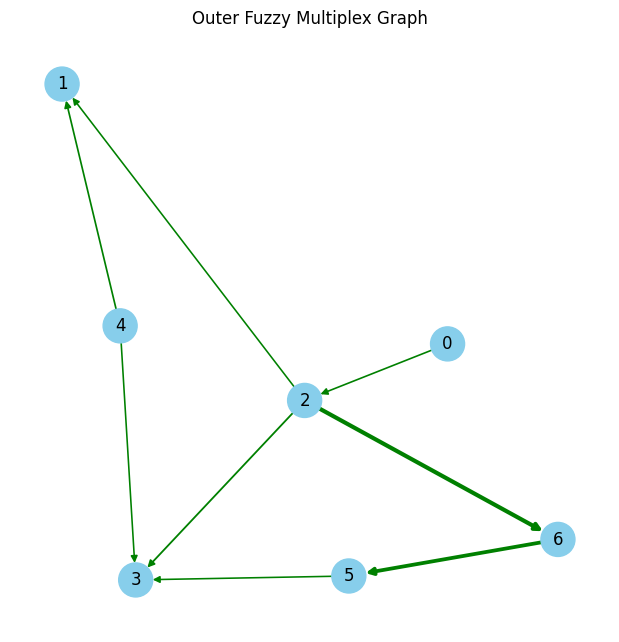

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.26  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.26  0.00  0.29  0.00  0.00  1.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.27  0.00  0.26  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.93  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

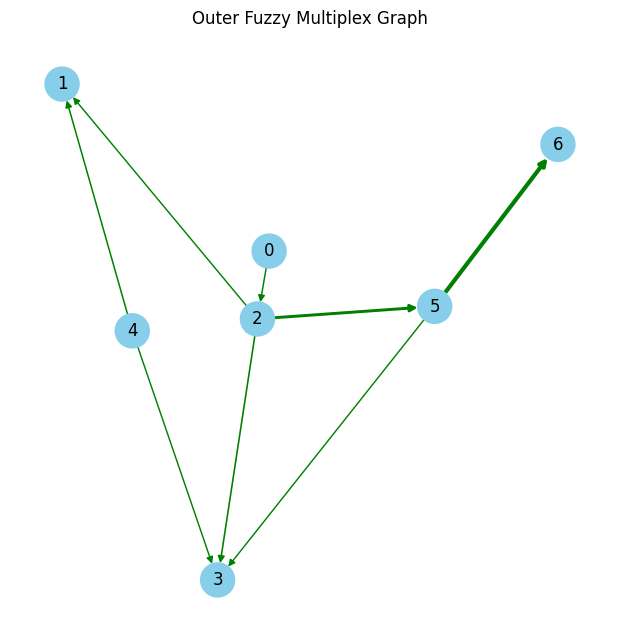

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.23  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

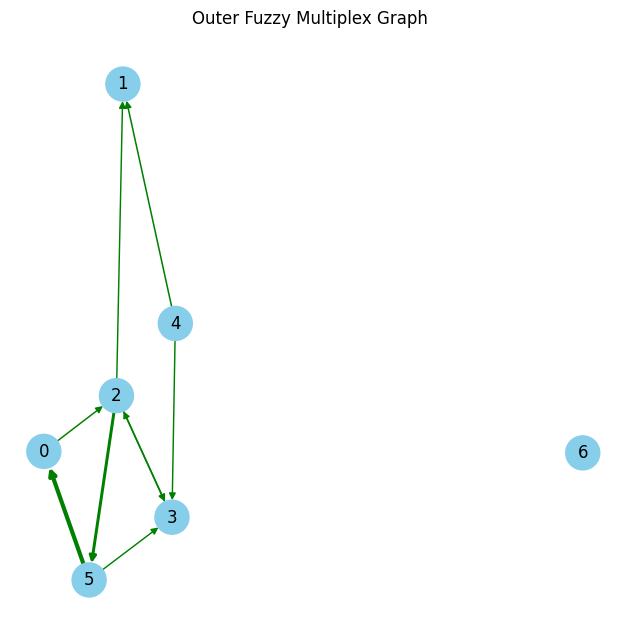

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.81  0.00 
N 3 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.23  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

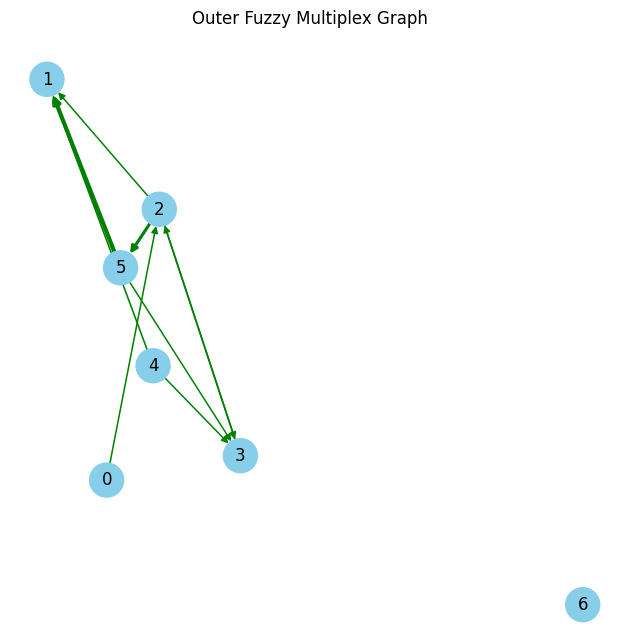

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.24  0.00  0.27  0.00  0.83  0.00 
N 3 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.24  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

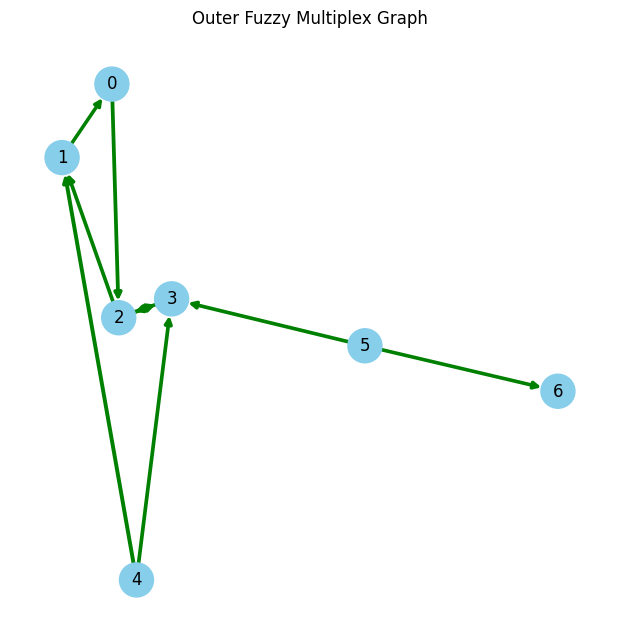

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.85  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.87 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

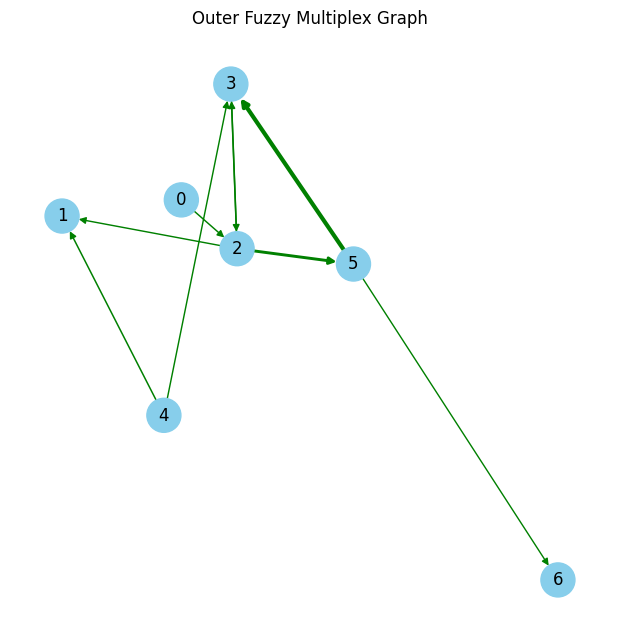

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.22  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.22 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

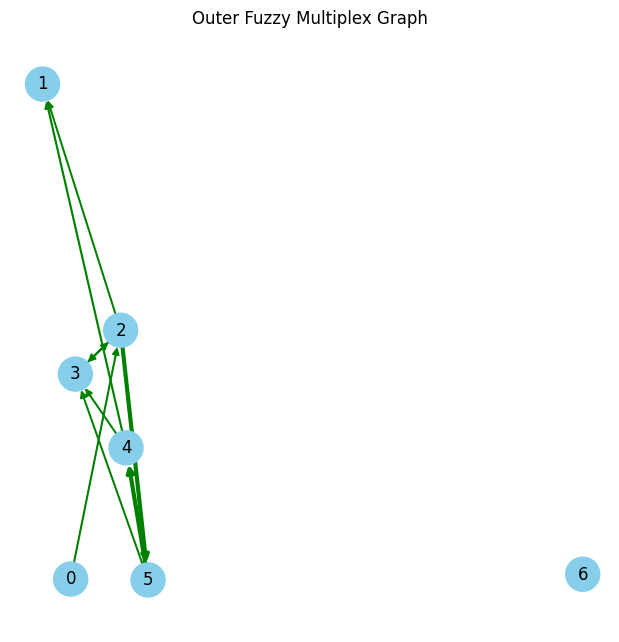

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.33  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.32  0.00  0.36  0.00  1.00  0.00 
N 3 |  0.00  0.00  0.32  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.34  0.00  0.32  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.32  1.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

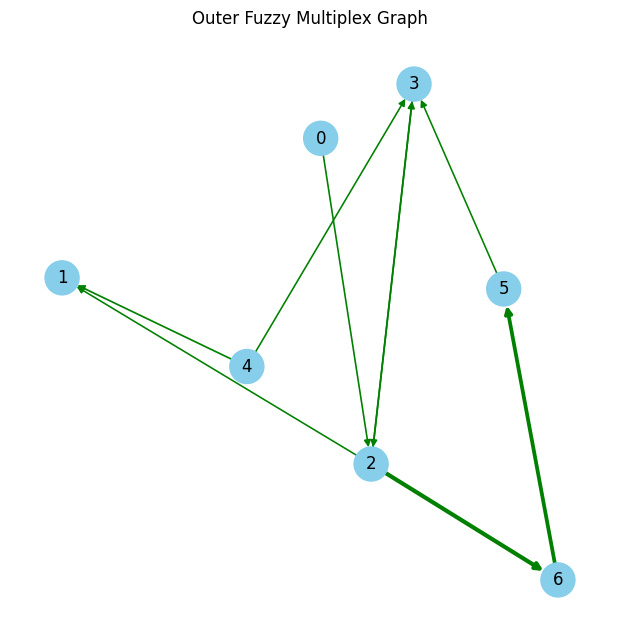

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.26  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.26  0.00  0.29  0.00  0.00  1.00 
N 3 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.27  0.00  0.26  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.93  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

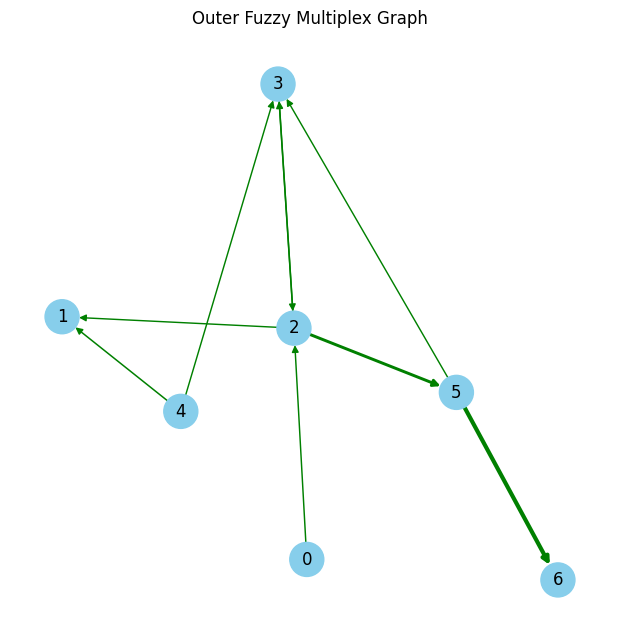

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.80  0.00 
N 3 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.23  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

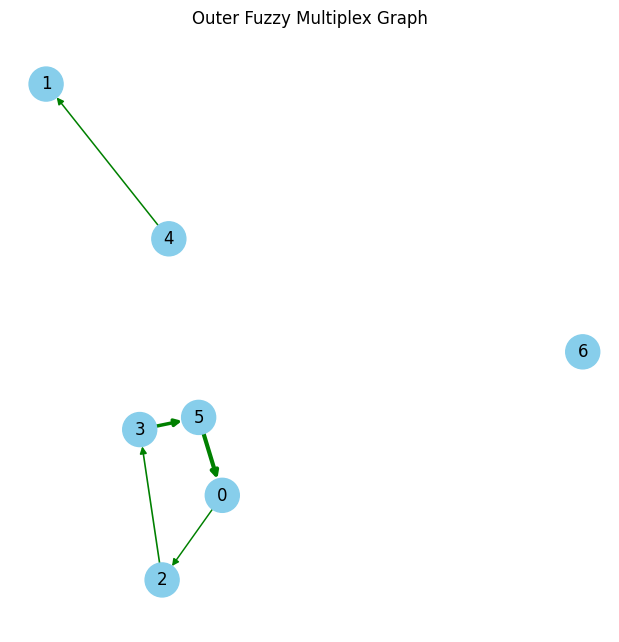

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.89  0.00 
N 4 |  0.00  0.25  0.00  0.00  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

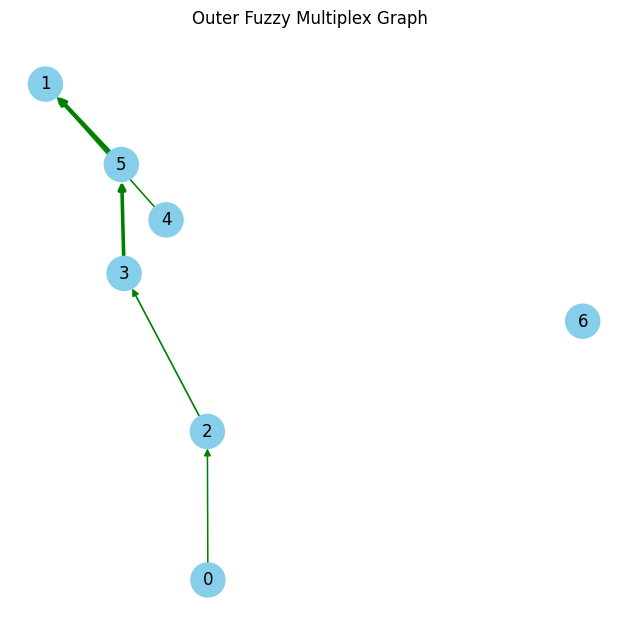

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.91  0.00 
N 4 |  0.00  0.26  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

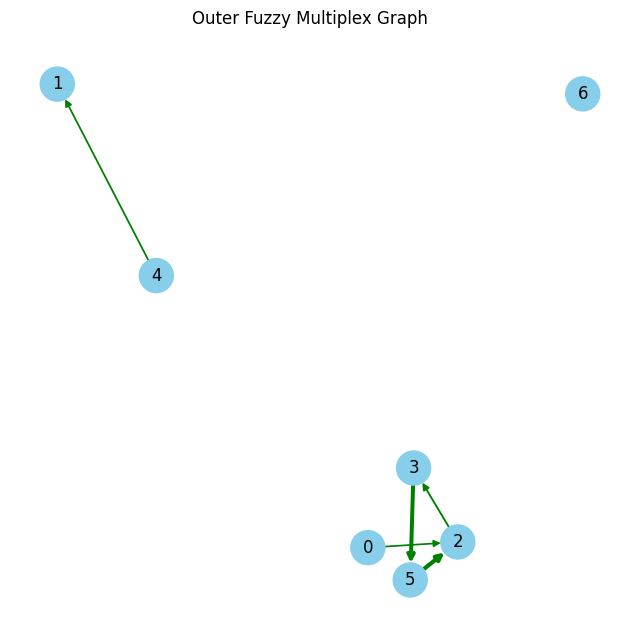

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.97  0.00 
N 4 |  0.00  0.28  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

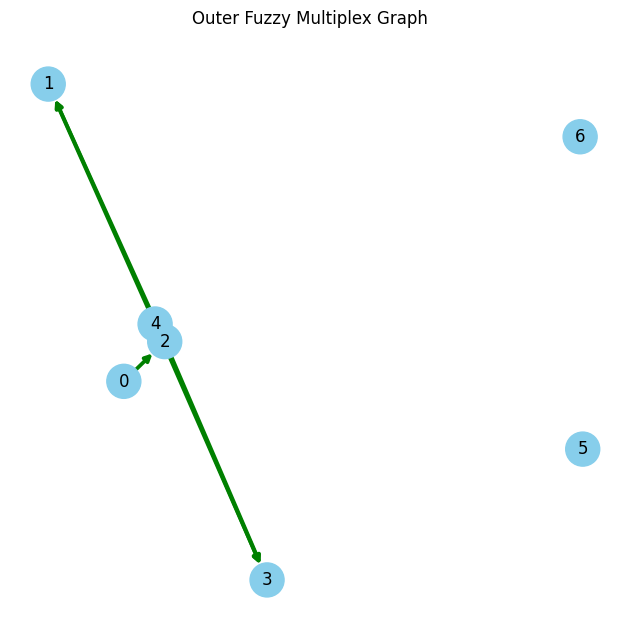

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

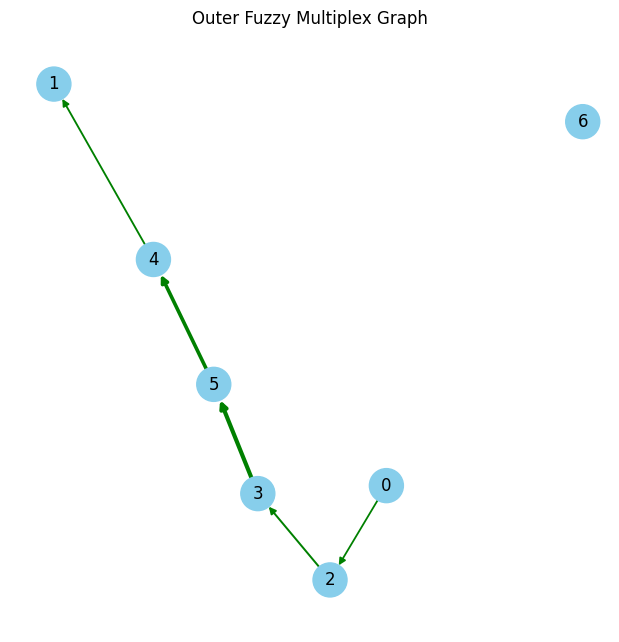

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 
N 4 |  0.00  0.30  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.91  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

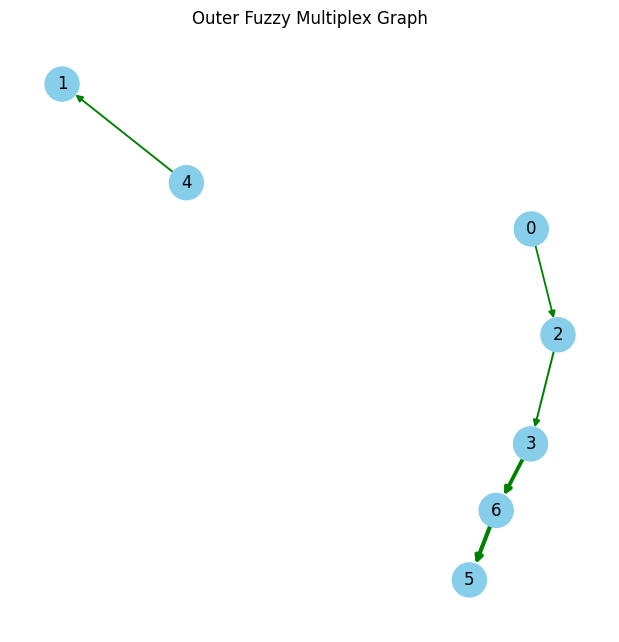

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.94 
N 4 |  0.00  0.30  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

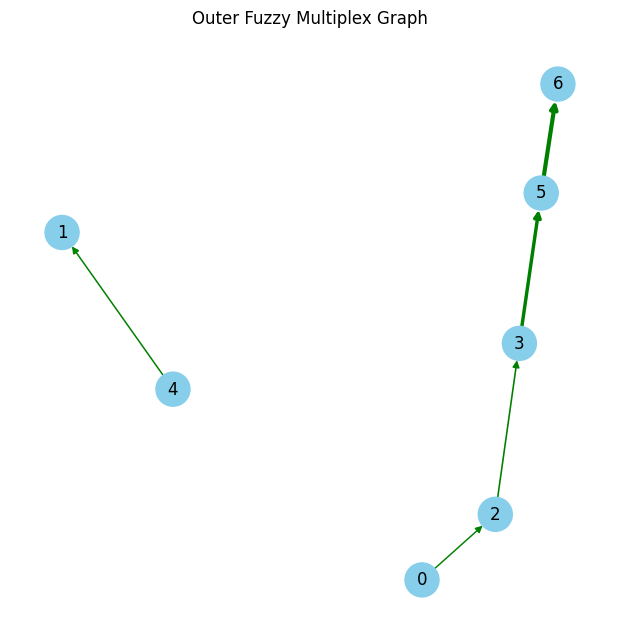

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.88  0.00 
N 4 |  0.00  0.24  0.00  0.00  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

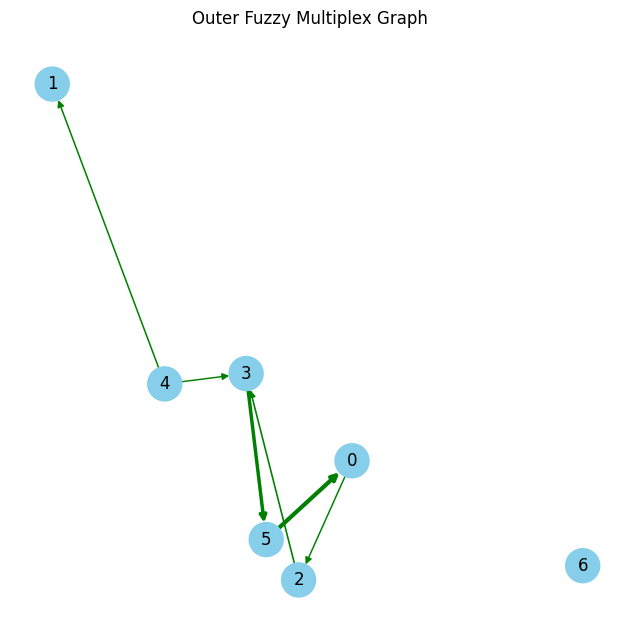

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.89  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

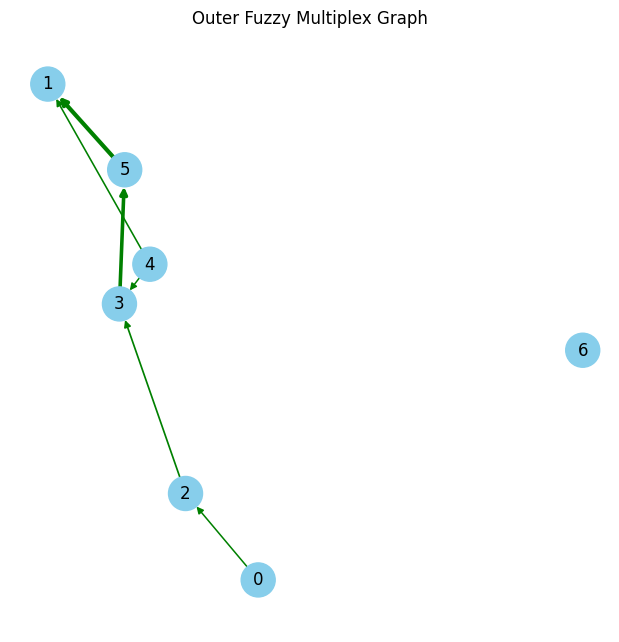

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.91  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

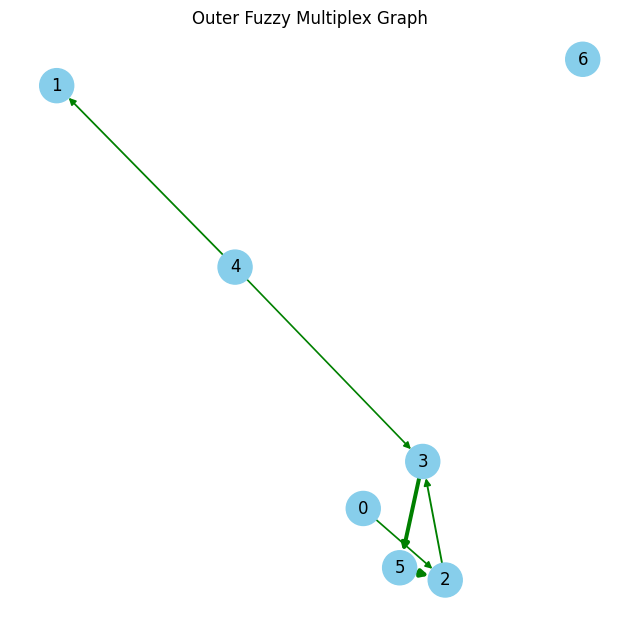

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.97  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

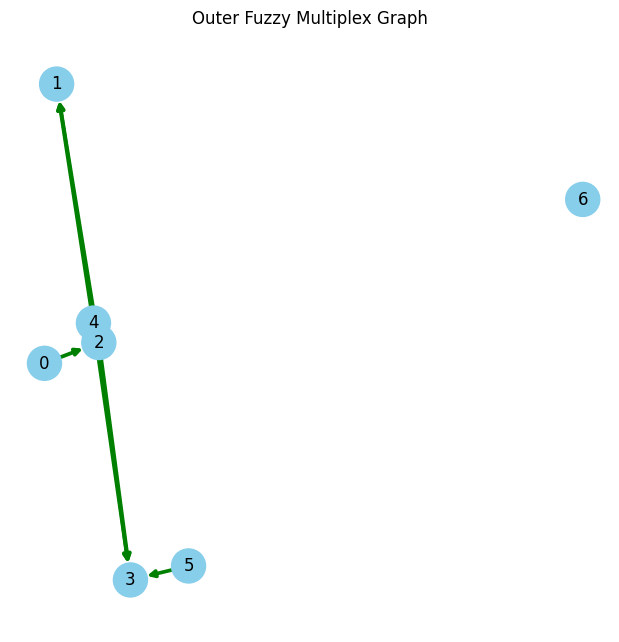

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

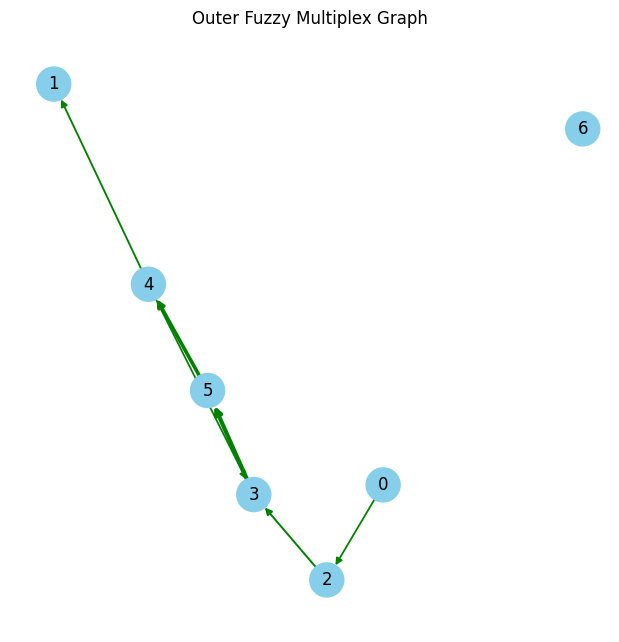

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 
N 4 |  0.00  0.30  0.00  0.28  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.91  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

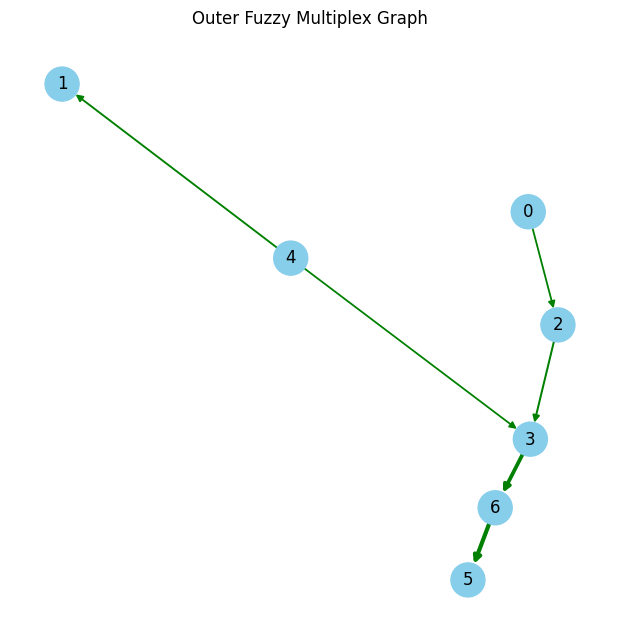

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.94 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

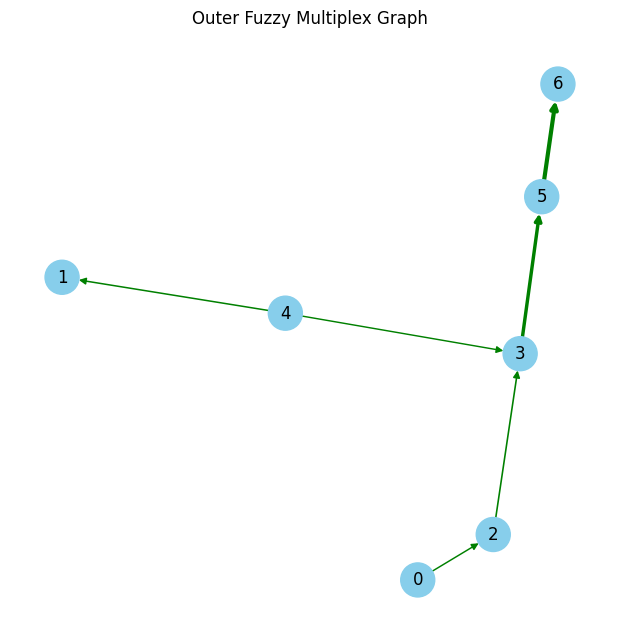

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.88  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

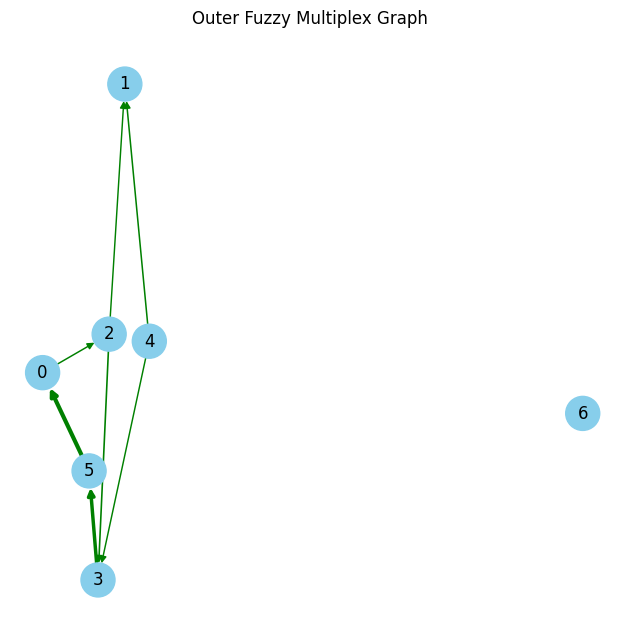

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.89  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

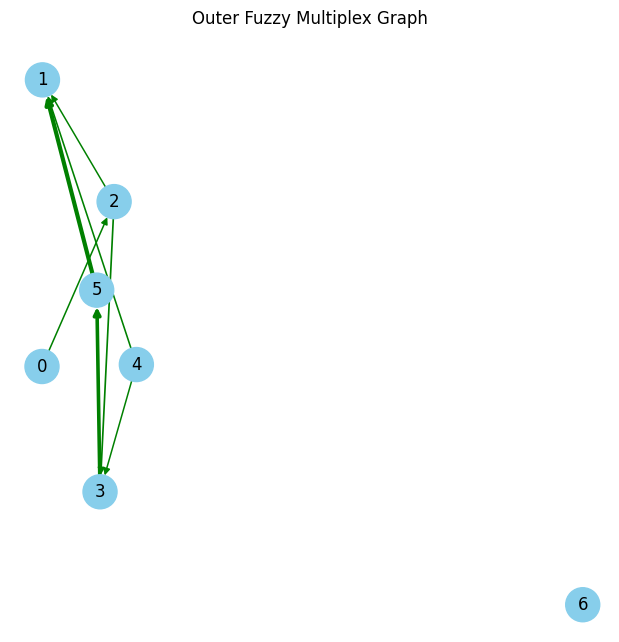

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.24  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.91  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

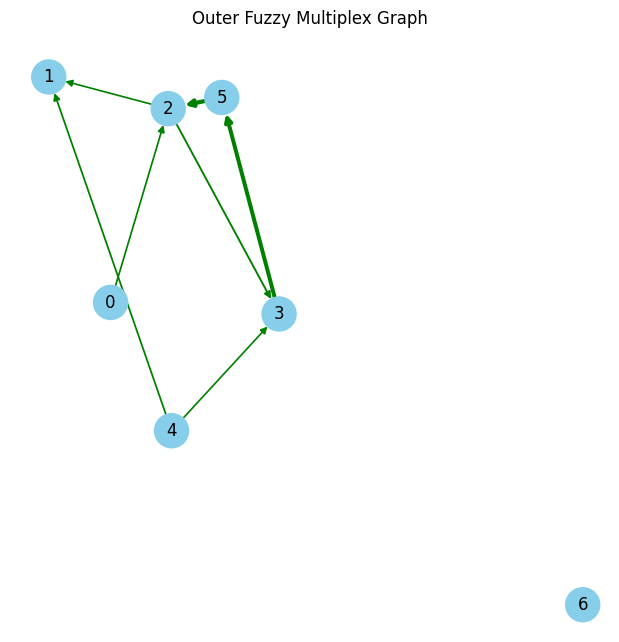

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.27  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.97  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

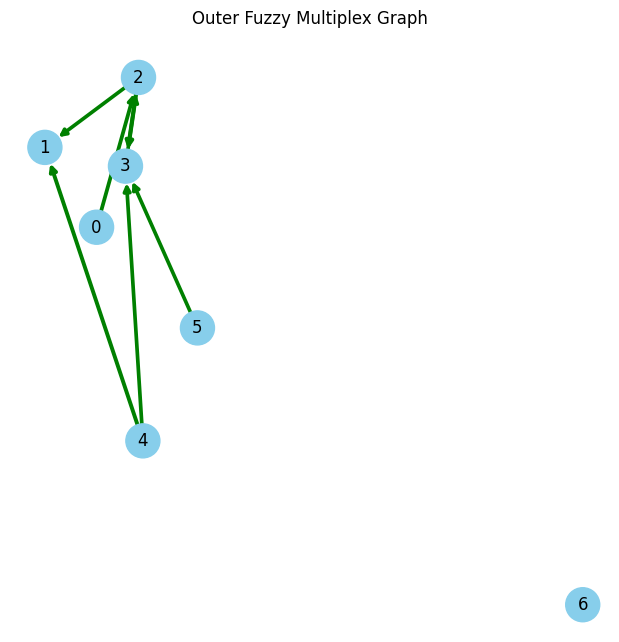

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

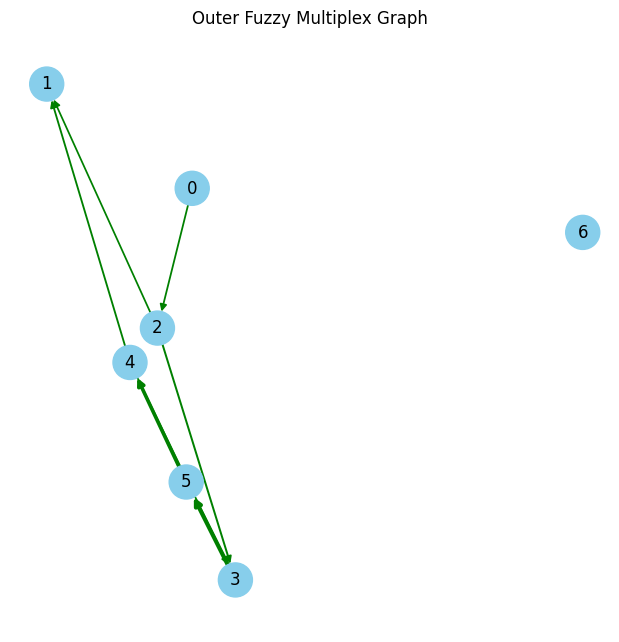

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 
N 4 |  0.00  0.30  0.00  0.28  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.91  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

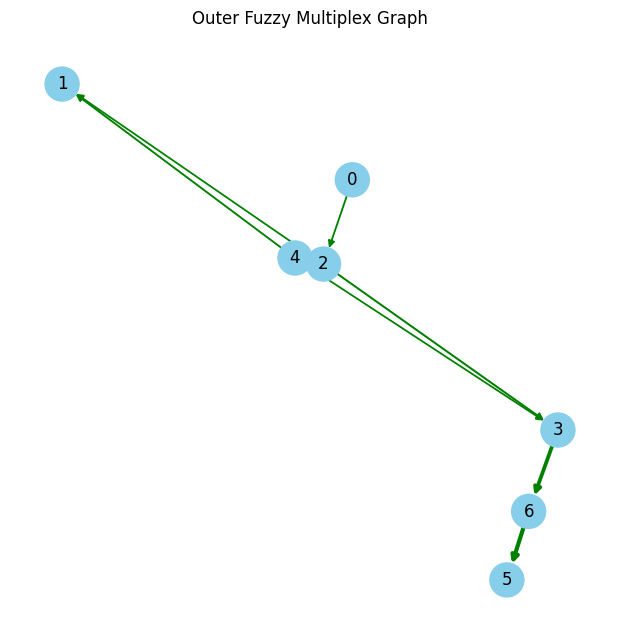

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.94 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

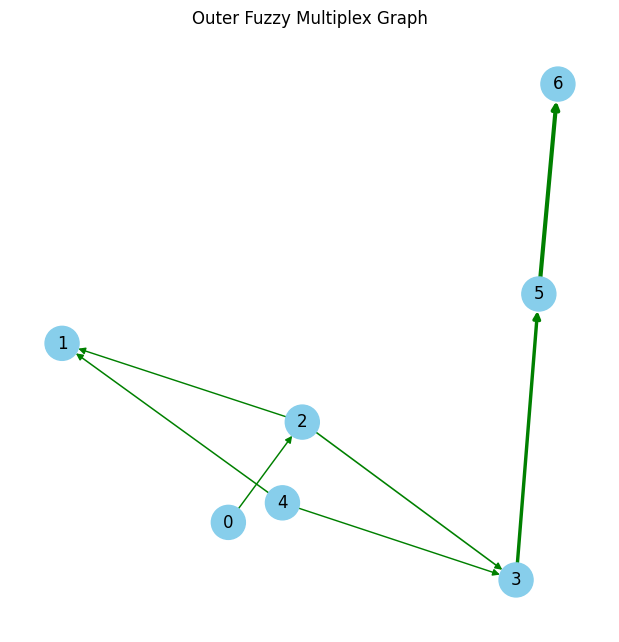

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.88  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

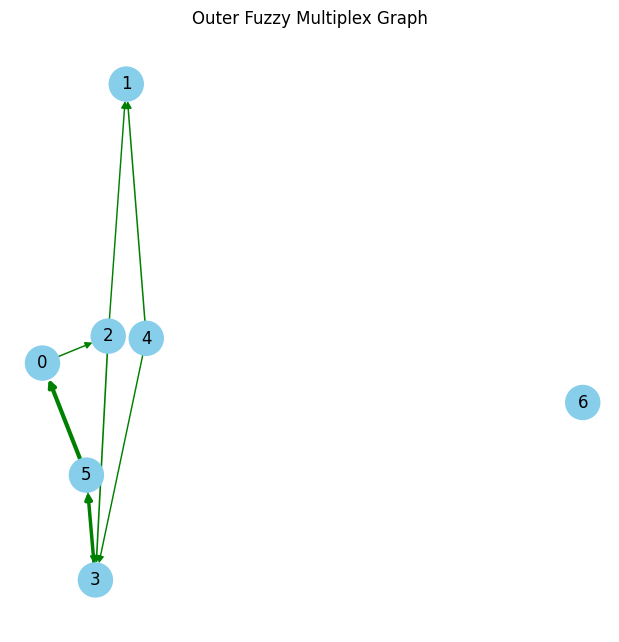

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.89  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.23  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

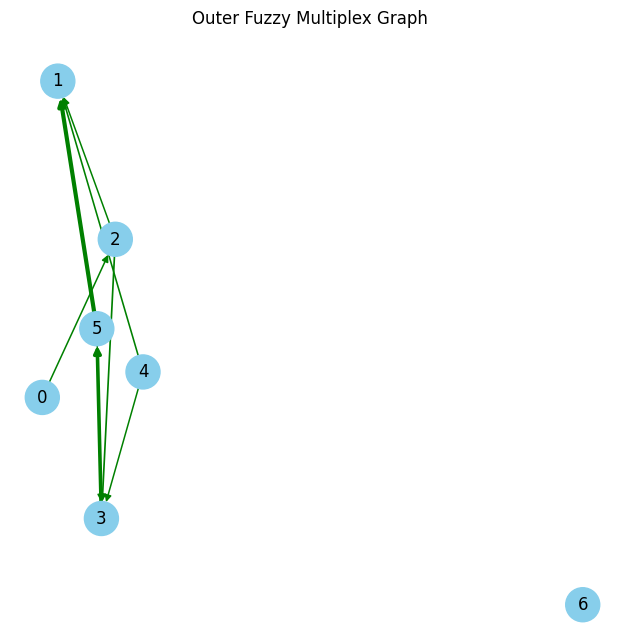

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.24  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.91  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.24  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

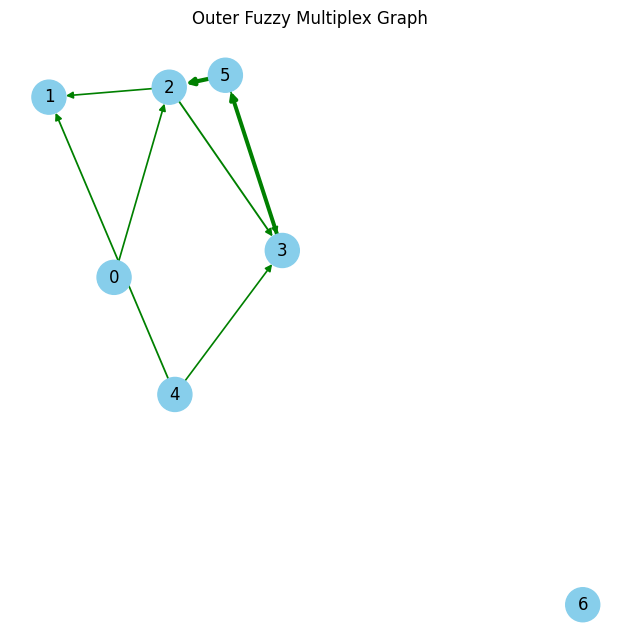

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.27  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.97  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.27  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

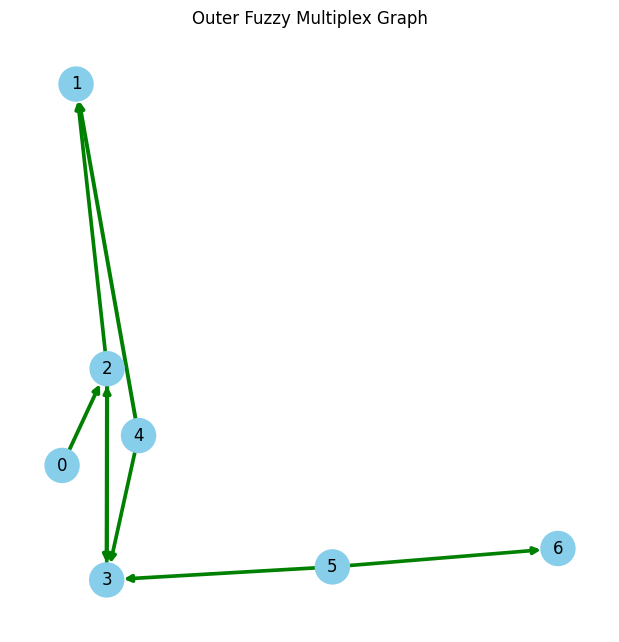

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.87 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

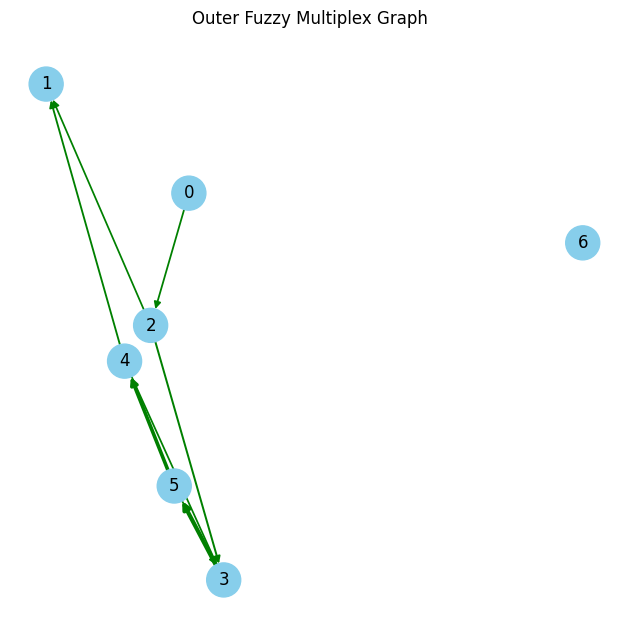

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 
N 4 |  0.00  0.30  0.00  0.28  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.91  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

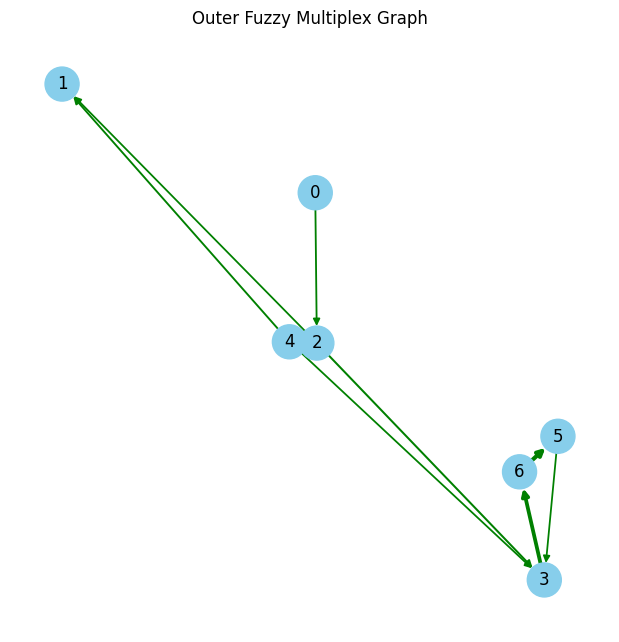

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.94 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

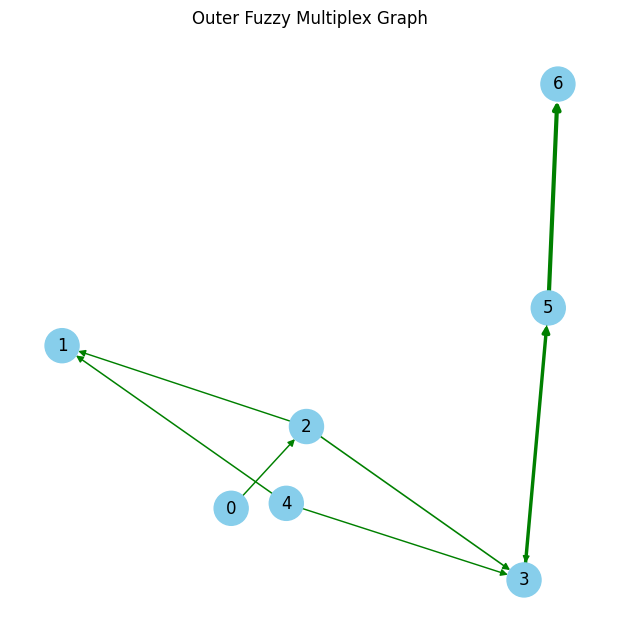

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 8 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.88  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.23  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

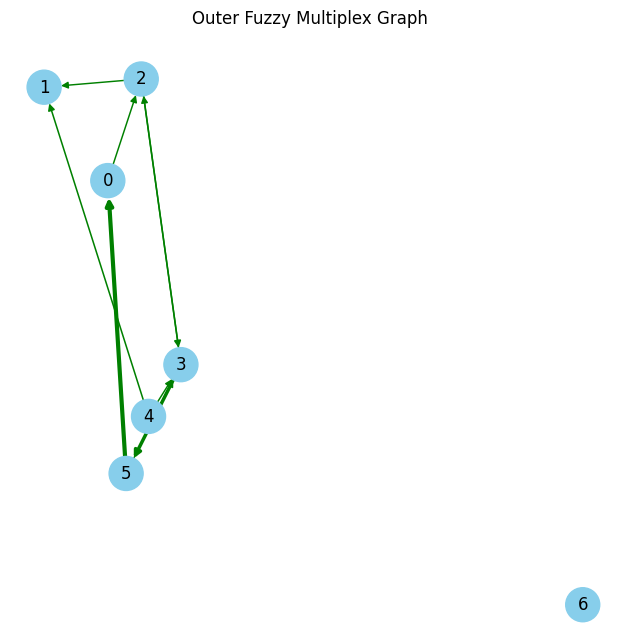

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.23  0.00  0.00  0.89  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.00  0.00 
N 5 |  1.00  0.00  0.00  0.23  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

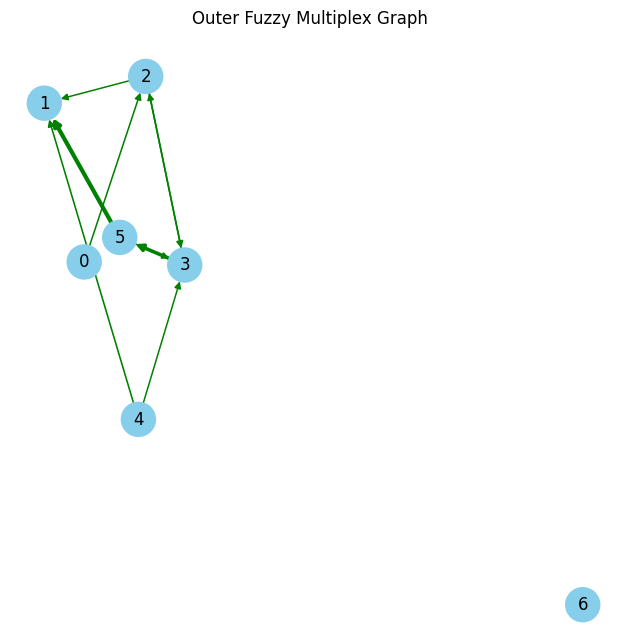

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.24  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.24  0.00  0.00  0.91  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.00  0.00 
N 5 |  0.00  1.00  0.00  0.24  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

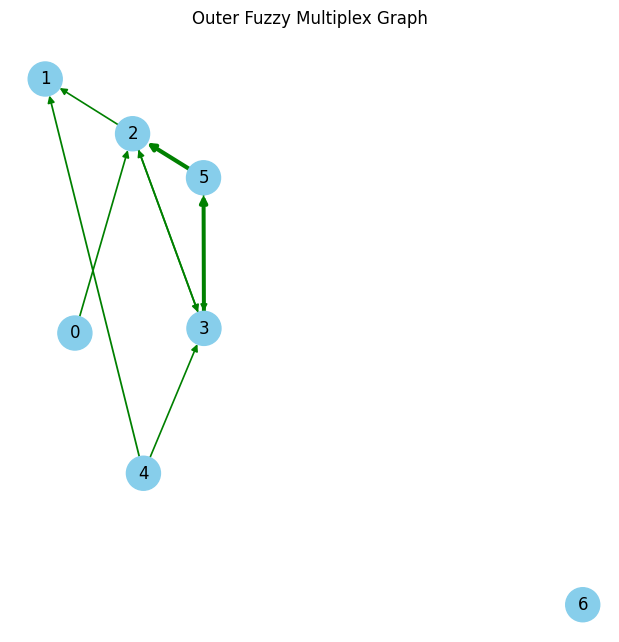

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.27  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.26  0.00  0.00  0.97  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.00  0.00 
N 5 |  0.00  0.00  1.00  0.27  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

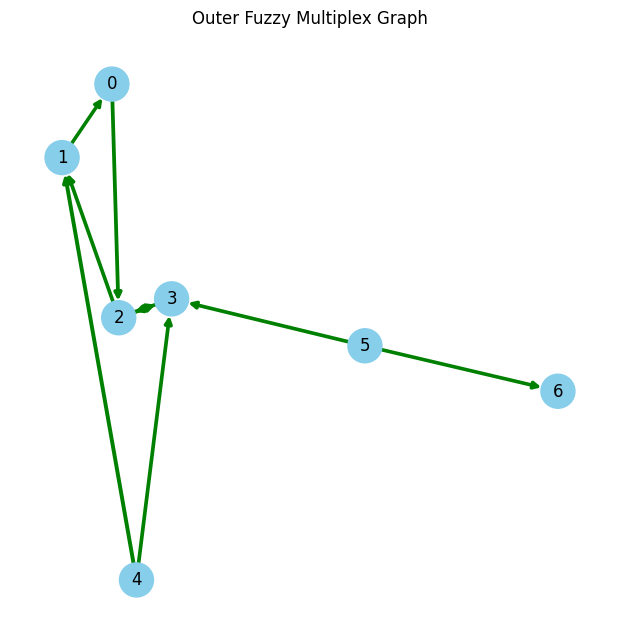

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.85  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.87  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.87 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

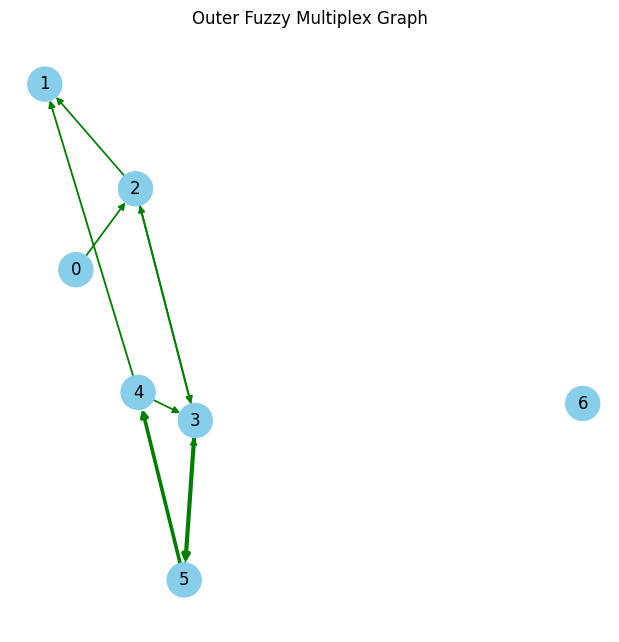

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.28  0.00  0.00  1.00  0.00 
N 4 |  0.00  0.30  0.00  0.28  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.91  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

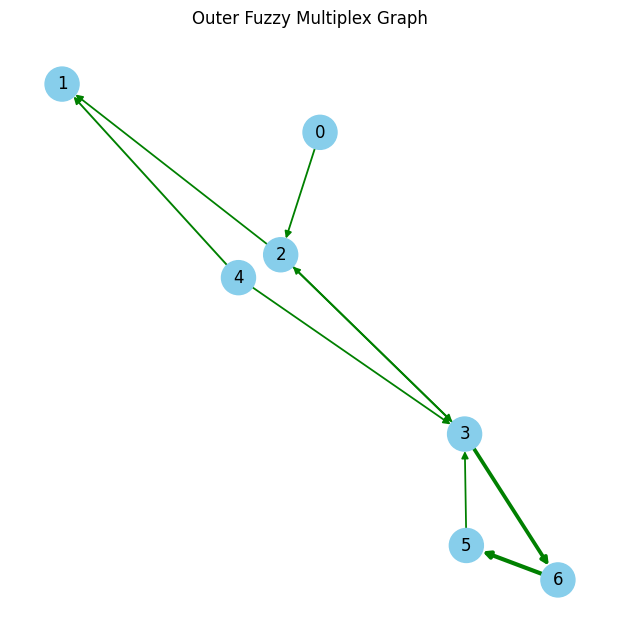

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.29  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.28  0.00  0.32  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.28  0.00  0.00  0.00  0.94 
N 4 |  0.00  0.30  0.00  0.29  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.28  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  1.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

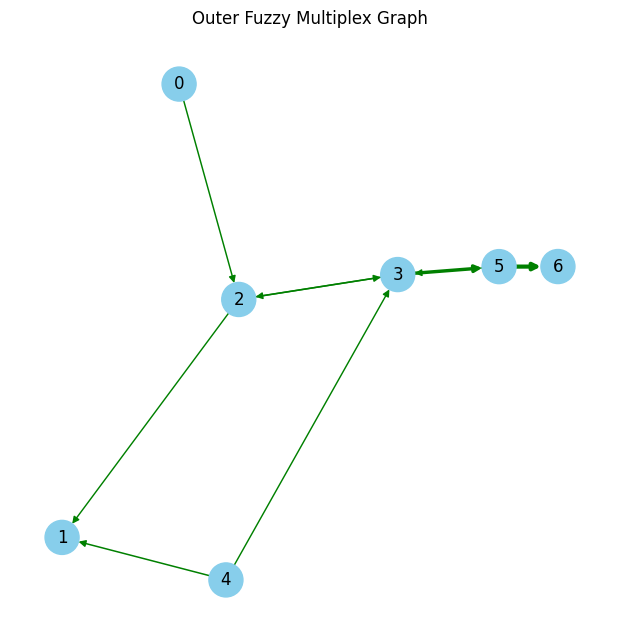

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 9 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.23  0.00  0.00  0.88  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.23  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

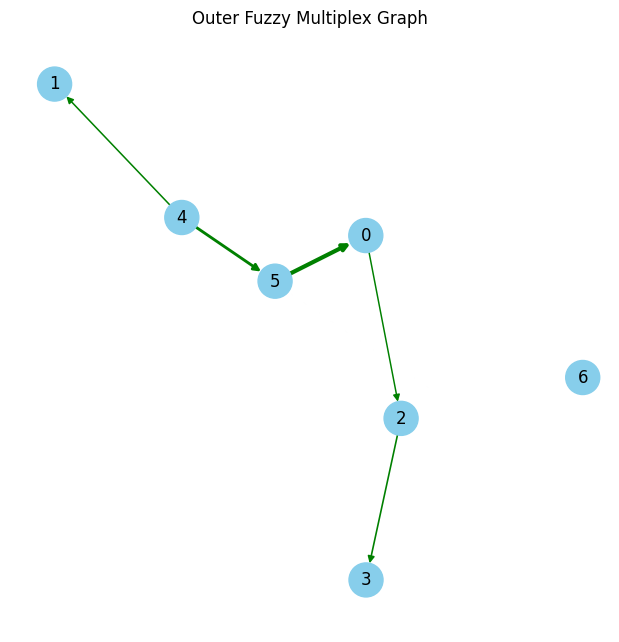

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.00  0.00  0.79  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

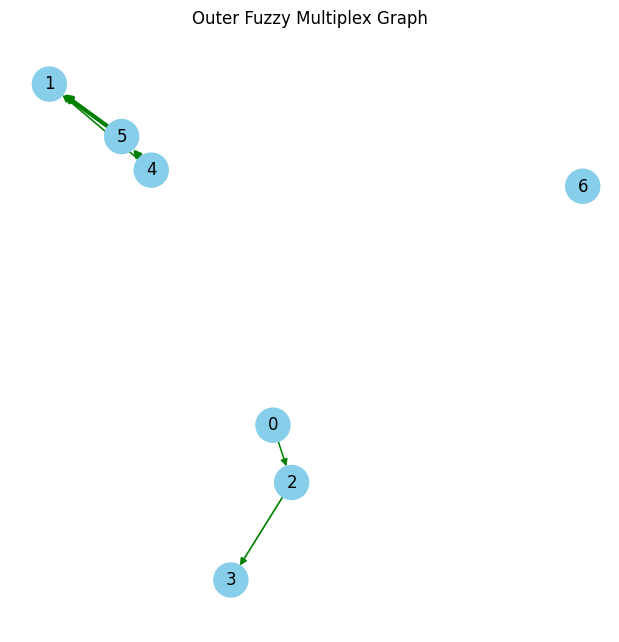

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.00  0.00  0.81  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

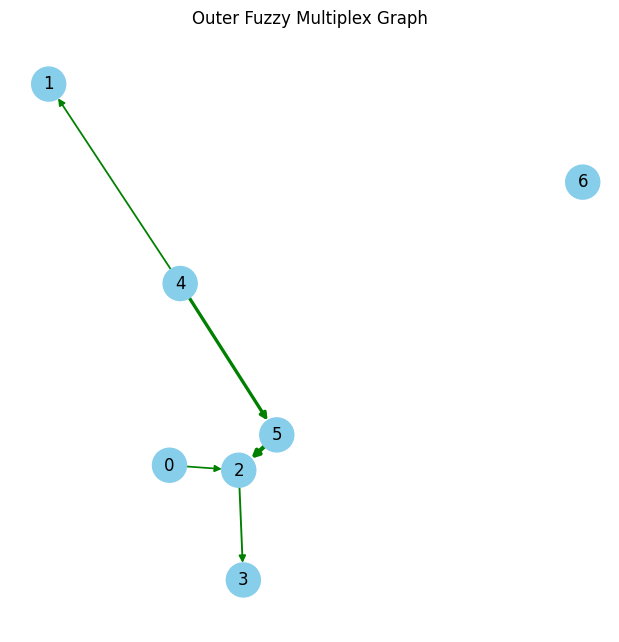

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.00  0.00  0.86  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

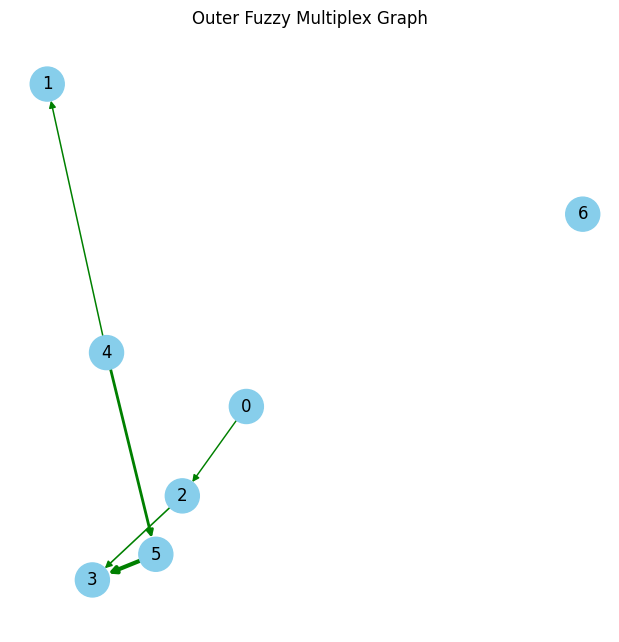

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.00  0.00  0.78  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

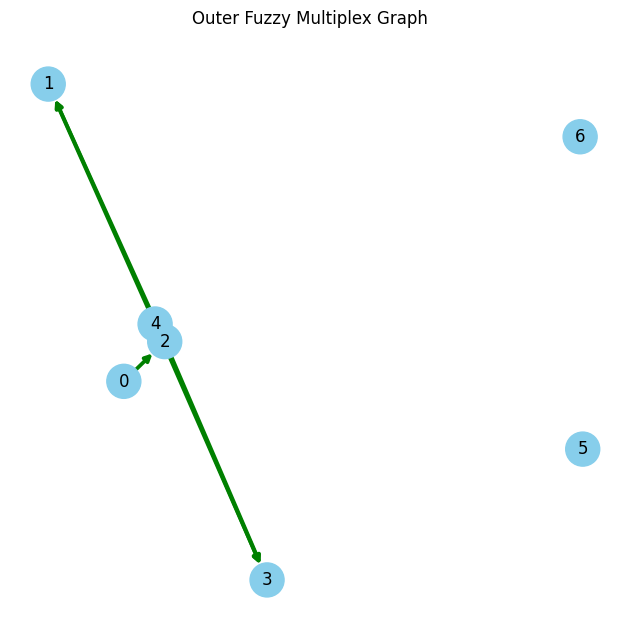

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

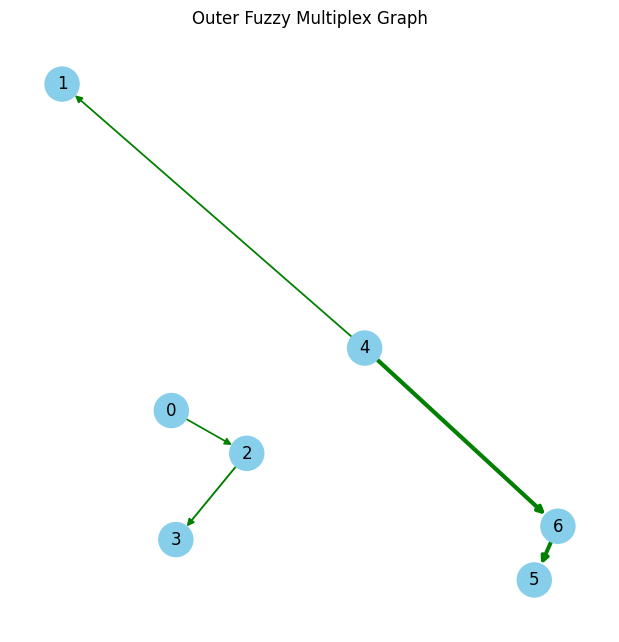

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.28  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.31  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.29  0.00  0.00  0.00  0.00  1.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.97  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

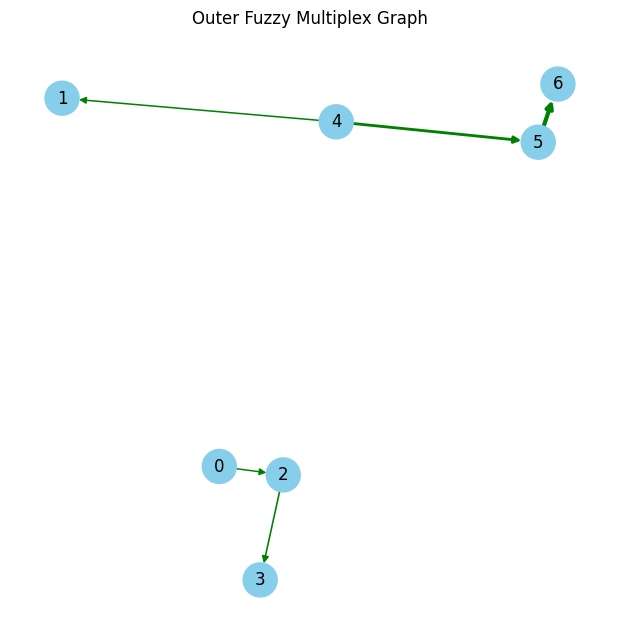

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 5 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.00  0.00  0.79  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

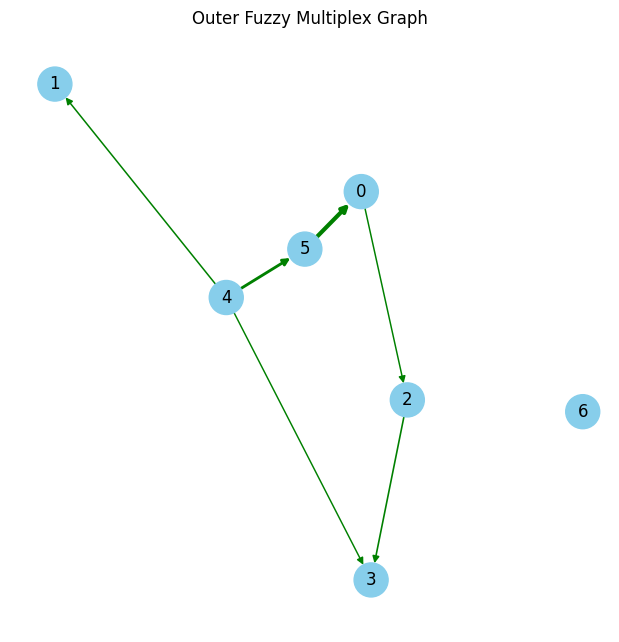

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.79  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

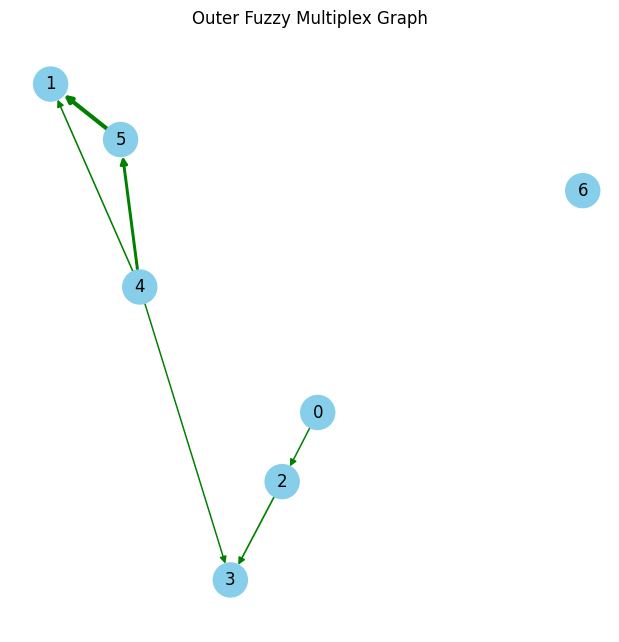

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.25  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.27  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.26  0.00  0.24  0.00  0.81  0.00 
N 5 |  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

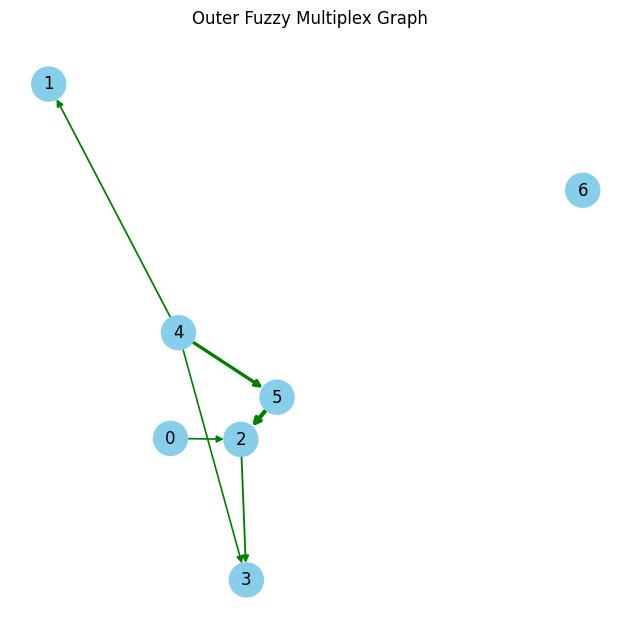

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.27  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.30  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.28  0.00  0.27  0.00  0.86  0.00 
N 5 |  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

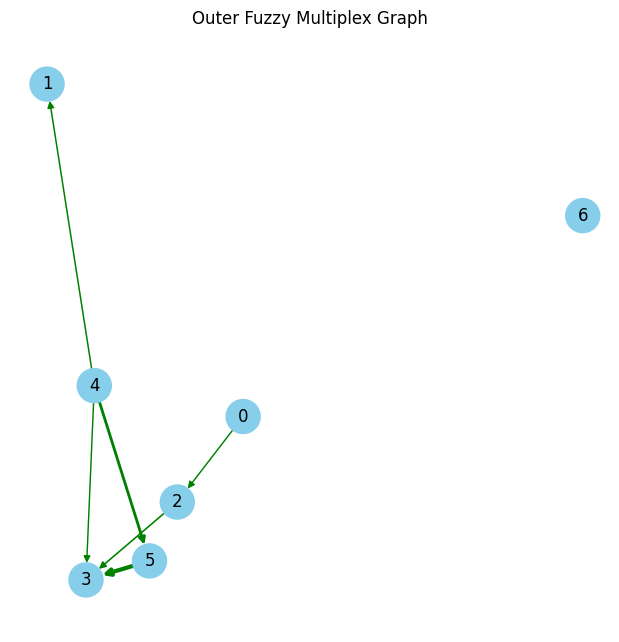

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.78  0.00 
N 5 |  0.00  0.00  0.00  1.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

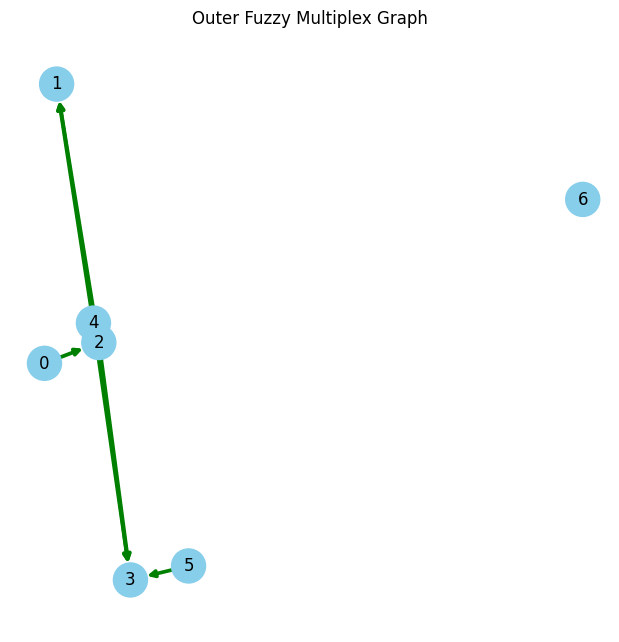

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.91  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.88  0.00  1.00  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.94  0.00  0.89  0.00  0.00  0.00 
N 5 |  0.00  0.00  0.00  0.88  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

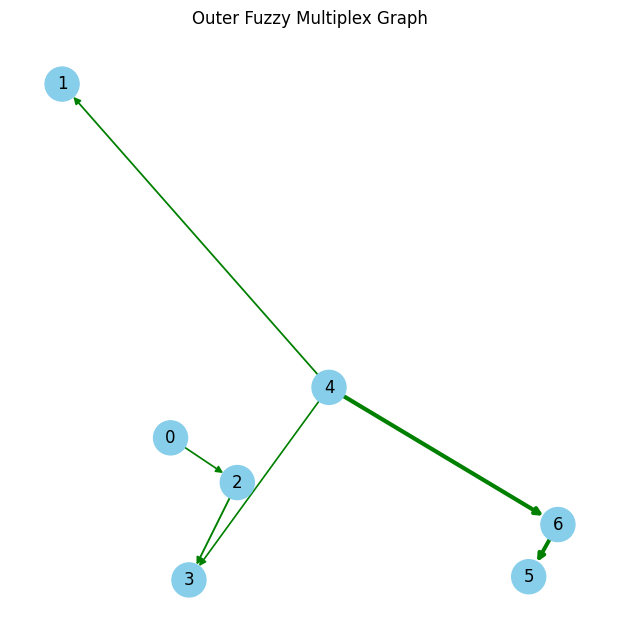

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.28  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.31  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.29  0.00  0.27  0.00  0.00  1.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.97  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

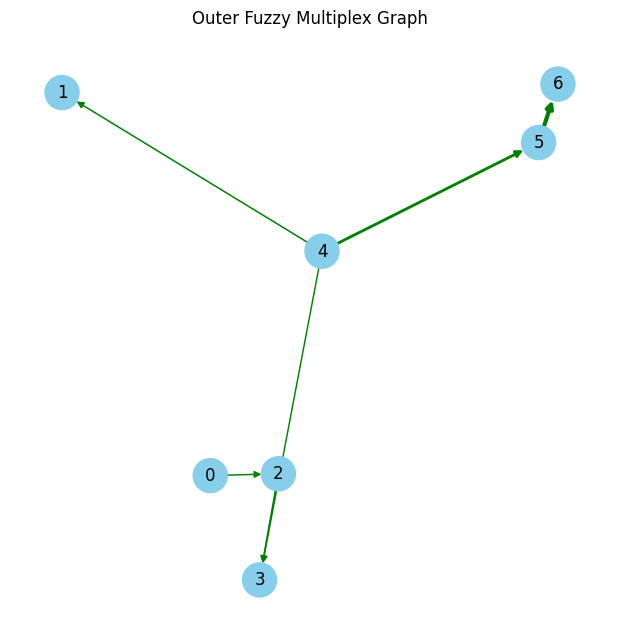

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 6 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.23  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.00  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.24  0.00  0.23  0.00  0.79  0.00 
N 5 |  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

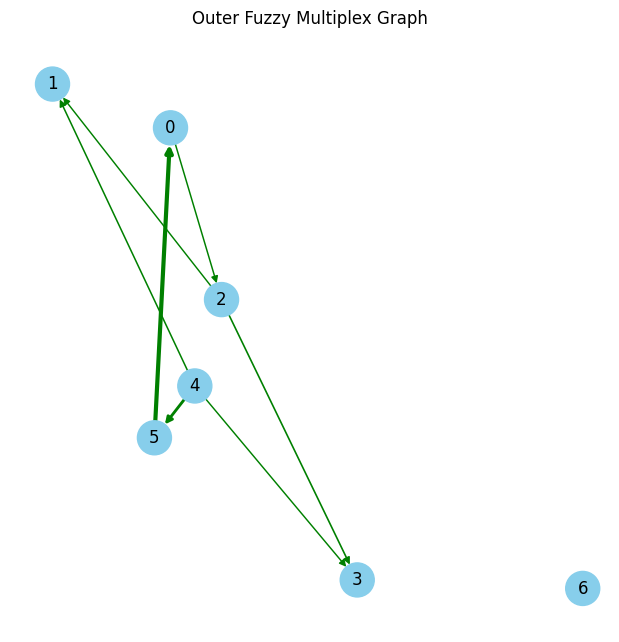

Generic Architecture Inference:
 - Edge (A): 4D
 - Hubs (B): 16D
 - Core (C): [8, 12]D
 [Optimizer] Architecture: ['A', 'B', 'C', 'B', 'B', 'C', 'A']
 [Optimizer] Mapping State Space (Exhaustive)...
 [Optimizer] Success. Mapped 1 valid trajectories.
 [Optimizer] Matrix Updated. Density: 7 edges.

=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===
     N   0 N   1 N   2 N   3 N   4 N   5 N   6
N 0 |  0.00  0.00  0.24  0.00  0.00  0.00  0.00 
N 1 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 2 |  0.00  0.23  0.00  0.26  0.00  0.00  0.00 
N 3 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 4 |  0.00  0.25  0.00  0.23  0.00  0.79  0.00 
N 5 |  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
N 6 |  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

============ TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM =============
KPI Indicator                    | PRIMARY         | TARGET DSM      | DELTA     
---------------------------------------------------------------------------
Fitness Score (0-100)           

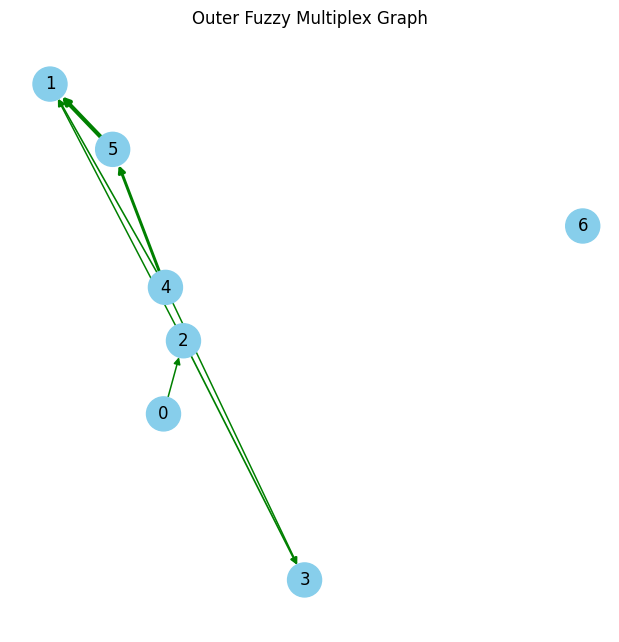

In [ ]:
try:
    D_GRAPH = D_graph
except:
    D_graph=D_GRAPH


def build_coupling_weight(label, m_i, m_j):
    """
    Interpretation: Pascal's Law P = F / A
    Force (F) = Potential delta in metrics (Improvement)
    Area (A) = Complexity/Friction of the destination node
    Valve = Orifice efficiency based on coupling type
    """

    # 1. THE NODAL VECTORS
    v_i = np.array(list(m_i.values())) if isinstance(m_i, dict) else np.array(m_i)
    v_j = np.array(list(m_j.values())) if isinstance(m_j, dict) else np.array(m_j)

    # 2. THE DRIVING FORCE (F)
    # The pressure only builds if the destination offers more "potential"
    # F = || max(0, v_j - v_i) ||
    force = np.linalg.norm(np.maximum(v_j - v_i, 0)) + 1e-9

    # 3. THE SURFACE AREA (A)
    # The 'wider' the destination node (more complex/costly),
    # the more the force is distributed, lowering the pressure.
    surface_area = np.mean(v_j) + 0.1

    # 4. THE VALVE ORIFICE (Efficiency)
    # A-type couplings are 'Wide Nozzles' (High pressure translation)
    # B-type couplings are 'Constricted Nozzles' (Damped flow)
    label_str = str(label) if label is not None else ""
    if "A" in label_str:
        motivator = force # High flow efficiency
    elif "B" in label_str:
        motivator =  1.0  # Damped efficiency
    else:
        motivator = surface_area# Standard atmospheric pressure

    # 5. THE SYSTEM PRESSURE (P)
    # (i) Power driver
    # (iii) Force driver
    # (ii) Pressure
    pressure = motivator * (force / surface_area)

    return max(pressure, 0.0001)
import numpy as np

def infer_node_types(node_metrics, candidate_dims=candidate_dims):
    """
    Generic Tier Inference:
    - Lowest Dim  -> A (Edge)
    - Highest Dim -> C (Core)
    - All Others  -> B (Hub/Median)

    This adapts to any number of unique dimensions.
    """
    # 1. Flatten dimensions
    dims_flat = [d[0] for d in candidate_dims]

    # 2. Identify Boundaries
    min_dim = min(dims_flat)
    max_dim = max(dims_flat)

    # 3. Assign Types based on Relative Position
    node_types = []
    for d in dims_flat:
        if d == min_dim:
            # The smallest nodes are always Edges
            node_types.append("A")
        elif d == max_dim:
            # The largest nodes are always Core
            node_types.append("C")
        else:
            # Anything in the middle is a Hub
            node_types.append("B")

    # Diagnostic
    unique_tiers = sorted(list(set(dims_flat)))
    print(f"Generic Architecture Inference:")
    print(f" - Edge (A): {min_dim}D")
    print(f" - Hubs (B): {max_dim}D")
    print(f" - Core (C): {[u for u in unique_tiers if u != min_dim and u != max_dim]}D")

    return node_types

def build_coupling_matrix(node_types):
    """
    Generic Behavioral Matrix Builder.
    Uses a 'Transition Rulebook' to enforce flow constraints.
    """
    D = len(node_types)
    C = np.full((D, D), "VOID", dtype=object)

    # DEFINING THE FLOW LOGIC (The "Constitution")
    # Format: { Source_Type: { Allowed_Dest_Type: Label } }
    # Any transition not listed here becomes "ABSORBED"



    RULES = {
        "C": {
            "B": "C->B"      # Core feeds Hub
        },
        "B": {
            "B": "B->B",     # Hub processes (Self-Loop)
            "A": "B->A"      # Hub ejects to Edge
        },
        "A": {
            "A": "A->A",     # Edge roams (Local routing)
            "C": "A->C"      # Edge returns to Core (Recycle)
        }
    }

    for i in range(D):
        src = node_types[i]

        for j in range(D):
            dst = node_types[j]

            # 1. Check if Source Type has rules
            if src in RULES:
                allowed_moves = RULES[src]

                # 2. Check specific destination logic
                if dst in allowed_moves:
                    # Special check for Self-Loops if needed
                    # (In this logic, A->A and B->B are allowed, C->C is not in the dict)

                    # Apply Label
                    C[i, j] = allowed_moves[dst]

                    # Refinement: Ensure B->B is strictly i==j (Self-Loop only)
                    # If B goes to OTHER B, that is blocked to prevent "Hub Hopping"
                    if src == "B" and dst == "B" and i != j:
                        C[i, j] = "ABSORBED"

                else:
                    C[i, j] = "ABSORBED"
            else:
                C[i, j] = "ABSORBED"

    return C

def build_dsm_from_walks(D, paths):
    """
    Constructs a DSM (Design Structure Matrix) from walk paths.
    Entry [i,j] is the probability that a process moves from i to j.
    """
    flow = np.zeros((D, D))
    for path in paths:
        for k in range(len(path) - 1):
            u, v = path[k], path[k+1]
            flow[u, v] += 1

    n_paths = len(paths)
    if n_paths > 0:
        flow = flow / n_paths

    np.fill_diagonal(flow, 0.0)
    return flow

# =============================================================================
# 2. THE METRIC-DRIVEN RANDOM WALKER (Consolidated)
# =============================================================================

from collections import deque
all_results = []
class CouplingState:
    """
    Q* DESIGN ENGINE:
    Uses Bellman Optimality to evaluate path potential.
    Q(s, a) = R(s, a) + gamma * max(Q(s', a'))
    """
    def __init__(self, coupling_matrix, node_metrics, gamma=0.85, max_depth=12):
        self.C = coupling_matrix
        self.node_metrics = node_metrics
        self.D = len(node_metrics)
        self.max_depth = max_depth
        self.gamma = gamma # Discount factor (how much we value future potential)

        # Static Type Inference
        dims = [len(m) if isinstance(m, dict) else len(m) for m in node_metrics]
        self.node_types = ["A" if d == min(dims) else "B" if d == max(dims) else "C" for d in dims]

        # PRE-COMPUTE THE Q-TABLE (The 'Brain')
        self.q_table = self._build_q_table()

    def _get_immediate_reward(self, i, j, label):
        """The 'Ohmic' reward: Force / Friction."""
        m_i, m_j = self.node_metrics[i], self.node_metrics[j]
        v_i = np.array(list(m_i.values())) if isinstance(m_i, dict) else np.array(m_i)
        v_j = np.array(list(m_j.values())) if isinstance(m_j, dict) else np.array(m_j)

        # Potential Displacement (Voltage)
        potential = np.linalg.norm(np.maximum(v_j - v_i, 0)) + 1e-9
        # Synergy (Conductance alignment)
        synergy = np.dot(v_i, v_j) / (np.linalg.norm(v_i) * np.linalg.norm(v_j) + 1e-9)

        # Resistance (Viscosity)
        area = np.mean(v_j) + 0.1
        penalty = 3.0 if "B" in str(label) else 1.0

        # Reward = (V * Synergy) / R
        return (potential * (1 + synergy)) / (area * penalty)

    def _build_q_table(self):
        """
        Iteratively solves the Bellman Equation for all nodes.
        This defines the 'Heuristic' for the search.
        """
        # Initialize Q-values with immediate rewards
        Q = np.zeros((self.D, self.D))
        for i in range(self.D):
            for j in range(self.D):
                label = self.C[i, j]
                if label not in ["ABSORBED", "VOID"]:
                    Q[i, j] = self._get_immediate_reward(i, j, label)

        # Iterate to propagate future values (Bellman Update)
        for _ in range(10): # 10 iterations to settle the manifold
            new_Q = Q.copy()
            for i in range(self.D):
                for j in range(self.D):
                    label = self.C[i, j]
                    if label not in ["ABSORBED", "VOID"]:
                        # Q = Reward + Gamma * (Best possible move from next node)
                        max_future = np.max(Q[j, :]) if np.any(Q[j, :]) else 0
                        new_Q[i, j] = Q[i, j] + self.gamma * max_future
            Q = new_Q
        return Q

    def run(self, start_node, end_node, q_threshold=0.2):
        """
        Q-STAR SEARCH:
        Only follows paths where the total path Q-value remains above threshold.
        """
        # Stack: (curr, path, cumulative_q, saturated)
        stack = [(start_node, [start_node], 0.0, False)]
        elite_trajectories = []

        while stack:
            u, path, path_q, saturated = stack.pop()

            if u == end_node:
                elite_trajectories.append((path, path_q))
                continue

            if len(path) >= self.max_depth:
                continue

            # Look up pre-calculated Q-values for all neighbors
            for v in range(self.D):
                label = self.C[u, v]
                if label in ["ABSORBED", "VOID"]: continue

                # Fetch the 'Quality' of this move
                move_q = self.q_table[u, v]

                # --- Q-STAR PRUNING ---
                # If the move doesn't lead to a high-value future, kill the branch
                if move_q < q_threshold:
                    continue

                # Automaton Gates
                is_b_loop = (label == "B->B")
                if saturated and self.node_types[v] != "A": continue
                if v in path and not (u == v and is_b_loop): continue

                stack.append((v, path + [v], path_q + move_q, is_b_loop))

        # Sort by Cumulative Quality
        elite_trajectories.sort(key=lambda x: x[1], reverse=True)
        return [t[0] for t in elite_trajectories]

import numpy as np

class CouplingSttate:
    """
    SELF-GOVERNING Q* ENGINE:
    Rules are integrated as intrinsic manifold properties.
    Uses 'State Saturation' to prevent illegal transmission.
    """
    def __init__(self, coupling_matrix, node_metrics, gamma=0.88):
        self.C = coupling_matrix
        self.M = np.array([list(m.values()) if isinstance(m, dict) else m for m in node_metrics])
        self.D = len(node_metrics)
        self.gamma = gamma
        
        # Self-Rule Mapping (Determined by Feature Density)
        dims = np.array([m.shape[0] for m in self.M])
        # C: Anchor (16D), B: Transformer (8-12D), A: Leaf (4D)
        self.tier_map = np.where(dims >= 16, "C", np.where(dims >= 8, "B", "A"))
        
        self.q_table = self._build_q_table()

    def _get_self_rule_reward(self, i, j):
        """Rules modeled as signal conductivity."""
        ti, tj = self.tier_map[i], self.tier_map[j]
        v_i, v_j = self.M[i], self.M[j]
        
        # 1. THE TOPOLOGICAL VOLTAGE (Spectral Mass)
        force = np.linalg.norm(v_j)
        
        # 2. THE SELF-RULE MULTIPLIER (Transition Physics)
        # Valid: C->C, C->B, B->B, B->A, A->A
        # Invalid: A->C (The 'Backwards' violation)
        valid_flow = True
        if ti == "A" and tj in ["C", "B"]: valid_flow = False
        if ti == "B" and tj == "C": valid_flow = False
        
        # Penalize 'Chaos' (Backwards flow) with exponential decay
        rule_friction = 1.0 if valid_flow else 0.0001
        
        # 3. RESONANCE (Information Synergy)
        synergy = np.dot(v_i, v_j) / (np.linalg.norm(v_i) * np.linalg.norm(v_j) + 1e-9)
        
        # Reward = (Mass * Synergy) * Rule-Conductivity
        return (force * (1 + synergy)) * rule_friction

    def _build_q_table(self):
        """Bellman iterations stabilize the 'Legal' path potential."""
        Q = np.zeros((self.D, self.D))
        for i in range(self.D):
            for j in range(self.D):
                if str(self.C[i,j]).strip() not in ["VOID", "0"]:
                    Q[i, j] = self._get_self_rule_reward(i, j)

        for _ in range(15):
            # Future Reflections check if the path remains 'Legal' to the end
            max_future = np.max(Q, axis=1)
            Q = Q + self.gamma * max_future[:, np.newaxis]
        return Q

    def run_safe_path(self, start=0, end=11):
        """Execute search using Self-Rule Pruning."""
        # Top-down Beam Search
        beams = [([start], 0.0)]
        
        for _ in range(self.D):
            candidates = []
            for path, score in beams:
                u = path[-1]
                if u == end:
                    candidates.append((path, score))
                    continue
                
                for v in range(self.D):
                    if v in path or str(self.C[u,v]).strip() in ["VOID", "0"]: continue
                    
                    # Q* Value provides the 'Safe' Heuristic
                    move_q = self.q_table[u, v]
                    candidates.append((path + [v], score + move_q))
            
            if not candidates: break
            candidates.sort(key=lambda x: x[1], reverse=True)
            beams = candidates[:5] # Keep Top 5 trajectories
            
        return beams[0] # Return most stable legal path

class StrategicBrain(CouplingSttate):
    """
    MINIMAX Q* ENGINE:
    Uses Alpha-Beta pruning to find the path of Maximum Guaranteed Information.
    Protects against 'Bogus' shortcuts by assuming the worst possible future noise.
    """
    
    def run_minimax(self, start=0, end=11, max_depth=8):
        # We start with Alpha (Worst possible) and Beta (Best possible)
        # To find the path that maximizes the minimum guaranteed throughput.
        
        best_path = []
        best_score = -float('inf')

        def minimax(u, path, alpha, beta, depth, is_maximizing):
            if u == end:
                return self.evaluate_path(path), path
            
            if depth == 0:
                # Use Q-Table as the 'Static Evaluation' (The Gut Feeling)
                return np.max(self.q_table[u, :]), path

            if is_maximizing:
                max_eval = -float('inf')
                best_trajectory = path
                
                # Sort neighbors by Q-value to optimize Alpha-Beta pruning
                neighbors = np.argsort(self.q_table[u, :])[::-1]
                
                for v in neighbors:
                    if v in path or str(self.C[u, v]).strip() in ["VOID", "0"]: continue
                    
                    eval_val, res_path = minimax(v, path + [v], alpha, beta, depth - 1, False)
                    if eval_val > max_eval:
                        max_eval = eval_val
                        best_trajectory = res_path
                    
                    alpha = max(alpha, eval_val)
                    if beta <= alpha: # THE ALPHA-BETA PRUNE
                        break 
                return max_eval, best_trajectory

            else:
                # MINIMIZER: Represents the 'Constraint Pressure'
                # It looks for where the rules are most likely to pinch the signal
                min_eval = float('inf')
                best_trajectory = path
                
                neighbors = np.argsort(self.q_table[u, :])
                for v in neighbors:
                    if v in path or str(self.C[u, v]).strip() in ["VOID", "0"]: continue
                    
                    eval_val, res_path = minimax(v, path + [v], alpha, beta, depth - 1, True)
                    if eval_val < min_eval:
                        min_eval = eval_val
                        best_trajectory = res_path
                    
                    beta = min(beta, eval_val)
                    if beta <= alpha:
                        break
                return min_eval, best_trajectory

        score, final_path = minimax(start, [start], -float('inf'), float('inf'), max_depth, True)
        return final_path, score

    def evaluate_path(self, path):
        """Calculates total Information Fidelity along a static path."""
        total_q = 0
        for i in range(len(path) - 1):
            total_q += self.q_table[path[i], path[i+1]]
        return total_q
        #return True
# --- Inner Loop (FCM & Learning) ---
INNER_FCM_STEPS = 1000       # Iterations per node simulation
INNER_LR_X = 1.0             # Learning rate for State X
INNER_LR_Y = 0.01           # Learning rate for State Y
INNER_LR_W = 1.0             # Learning rate for Weights
INNER_SVM_LR = 0.01          # SVM Learning Rate
INNER_GAMMA = 1.0            # Inter-layer neural connection strength

# --- Random Walk & Pathfinding ---
WALK_BETA = 0.3              # Novelty penalty (dampens repeated paths)
WALK_LAMBDA_COST = 1.0       # Penalty weight for cost metrics

# --- Outer Loop (Topology Optimization) ---
OUTER_GENERATIONS = 1        # Iterations per Layer
OUTER_COST_LIMIT = 1000      # Normalization ceiling for scores
INTER_EDGE_THRESH = 0.02     # Min DSM weight to trigger neural link

for ijk in range(D_GRAPH):
    for jik in range(5,10):
        for kij in range(D_GRAPH):
                print(50*'_',ijk,50*'-',jik,50*'=')
                #===============================================================================
                OUTER_N_SIMS = 1000          # More simulations to find the "Hidden Gem" paths
                WALK_MAX_STEPS = 25  
                #MAX_DEPTh# Let the walker explore complex relationships deeply
                DSM_TARGET_EDGES = jik        # Allow HIGHER density (Complexity is allowed!)
                OUTER_DSM_LAYERS = 1         # Balanced hierarchy (Structure -> Systems -> Skin)
                DSM_ADDITIVE_RATE = .5     # Low Learning Rate: Learn slowly, don't panic.
                DSM_FEEDBACK_STR = 0.05      # Weak Feedback: Listen to problems, but don't obsess.
                WALK_TOP_K = 2               # Soft Sparsity: Consider more options per step.
                DSM_FEEDBACK_FILTER = 0.1    # Only react to major issues.
                DSM_PRUNE_THRESH = 0.02      # Keep subtle connections.
                DSM_INIT_RANGE = 0.2         # Start with a blanker slate.
                STARTING_POINT = ijk           # START AT SITE ANALYSIS (Respect the Land).
                END_POINT = kij
                #=============================================================================
                class Fuzzy_Hierarchical_Multiplex:
                    def __init__(self, candidate_dims, D_graph,
                                synthetic_targets,
                                gamma_interlayer=1.0, causal_flag=False,
                                metrics=METRIC_KEYS, metric_mask=METRIC_TARGET):

                        self.candidate_dims = candidate_dims
                        self.D_graph = D_graph
                        self.synthetic_targets = synthetic_targets
                        self.causal_flag = causal_flag
                        self.best_dim_per_node = [len(t)-1 for t in synthetic_targets]
                        self.MM = metric_mask
                        self.MK = metrics
                        self.MKI = metrics + ['score']

                        self.PLM = [[] for _ in range(self.D_graph)]
                        self.PLMS = [[] for _ in range(self.D_graph)]
                        self.nested_reps = [np.zeros(c[0]) for c in candidate_dims]

                        # Inter-layer setup
                        self.inter_layer = InterLayer(D_graph, max_inner_dim=max(candidate_dims), gamma=gamma_interlayer)
                        self.chosen_Gmat = np.random.uniform(0.0, 0.3, (D_graph, D_graph))
                        np.fill_diagonal(self.chosen_Gmat, 0)

                        self.l2_before, self.l2_after = [], []
                        self.max_target_len = max(len(t['target']) for t in synthetic_targets)
                        self.svm_lr = 0.01

                        self.metric_traces = {k: [] for k in metrics}
                        self.metric_traces_per_node = [{} for _ in range(self.D_graph)]

                        # DSM optimization hyperparameters
                        self.dsm_lr = 0.1
                        self.dsm_l1 = 0.02
                        self.dsm_clip = 1.0
                        self.dsm_history = []
                        self.dsm_cost_weight = 0.05

                    def print_dsm_basic(self):
                        D = self.D_graph
                        print("\n=== DESIGN STRUCTURE MATRIX (DSM) : Gmat ===")
                        header = "     " + " ".join([f"N{j:>4}" for j in range(D)])
                        print(header)
                        for i in range(D):
                            row = "N{:>2} | ".format(i)
                            for j in range(D):
                                row += f"{self.chosen_Gmat[i, j]:>5.2f} "
                            print(row)

                    # ---------- INNER LOOP (FCM) ----------
                    def run_inner(self, node_idx, target, D_fcm,
                                steps=INNER_FCM_STEPS, lr_x=INNER_LR_X, lr_y=INNER_LR_Y, lr_W=INNER_LR_W,
                                decorrelate_metrics=False):

                        # --- Initialize activations ---
                        x = np.random.uniform(-0.6, 0.6, D_fcm)
                        y = np.random.uniform(-0.1, 0.1, D_fcm)

                        # L2 tracking
                        self.l2_before.append(np.linalg.norm(self.nested_reps[node_idx][:len(target)] - target))

                        # --- FCM updates ---
                        W = np.random.uniform(-0.6, 0.6, (D_fcm, D_fcm))
                        np.fill_diagonal(W, 0)

                        for _ in range(steps):
                            z = y.dot(W) + x
                            Theta_grad_z = z - target
                            Theta_grad_x = Theta_grad_z
                            Theta_grad_y = Theta_grad_z.dot(W.T)
                            Theta_grad_W = np.outer(y, Theta_grad_z)

                            x -= lr_x * np.clip(Theta_grad_x, -0.05, 0.05)
                            y -= lr_y * np.clip(Theta_grad_y, -0.05, 0.05)
                            W -= lr_W * np.clip(Theta_grad_W, -0.01, 0.01)

                            x = np.clip(x, 0, 1)
                            y = np.clip(y, 0, 1)
                            np.fill_diagonal(W, 0)
                            W = np.clip(W, -1, 1)

                        # --- Update nested representation ---
                        self.nested_reps[node_idx][:len(x)] = x
                        self.l2_after.append(np.linalg.norm(x - target))

                        # --- Extract node features ---
                        # Assuming MetricsEvaluator is a global or imported class
                        metrics_evaluator = MetricsEvaluator(data_matrix=DATA_MATRIX)
                        features = metrics_evaluator.extract_features(node_idx)
                        feat_vals = np.array(list(features.values()))

                        # --- Compute metrics scaled by activations + features ---
                        metric_mask = METRIC_TARGET[node_idx]
                        metric_values = {}

                        for key, formula, mask in zip(METRIC_KEYS, METRIC_FORMULAS, metric_mask):
                            if mask:
                                weighted_input = np.mean(feat_vals)
                                # Outer scale check
                                outer_scale = getattr(self, 'best_node_weights', {}).get(node_idx, 1.0)
                                if isinstance(outer_scale, (list, np.ndarray)):
                                    # fallback if it was stored incorrectly in previous context
                                    outer_scale = 1.0

                                weighted_input *= outer_scale
                                metric_val = formula(weighted_input)
                                metric_values[key] = metric_val

                                # STORE DATAPOINT
                                self.metric_traces[key].append((weighted_input, metric_val))
                            else:
                                metric_values[key] = 0.0

                        # --- Total score ---
                        metric_values['score'] = sum(metric_values.values())

                        # --- Build SVM Training Data ---
                        metric_output_vals = np.array(
                            [v for k, v in metric_values.items() if k not in ['score', 'x', 'feat_vals']]
                        )

                        # Lazy init per-node SVM
                        if not hasattr(self, "node_svms"):
                            self.node_svms = {}

                        if node_idx not in self.node_svms:
                            self.node_svms[node_idx] = SVM(
                                input_dim=len(self.MK),
                                output_dim=self.candidate_dims[node_idx][0],
                                lr=self.svm_lr
                            )

                        svm = self.node_svms[node_idx]

                        # Build SVM Input/Output
                        x_in_full = np.zeros(len(self.MK))
                        x_in_full[:len(metric_output_vals)] = metric_output_vals
                        x_in = x_in_full.reshape(1, -1)

                        y_out_full = np.zeros(self.candidate_dims[node_idx][0])
                        y_out_full[:len(x)] = x
                        y_out = y_out_full.reshape(1, -1)

                        # Train SVM
                        _ = svm.train_step(x_in, y_out)

                        # --- Store PLMS trace ---
                        self.PLMS[node_idx].append((float(weighted_input), metric_output_vals))

                        if len(self.PLMS[node_idx]) % 100 == 0:
                            print(f"Node {node_idx}, samples learned:", len(self.PLMS[node_idx]))

                        # --- Compute inter-layer MI ---
                        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

                        return x, y, W, mi_score, metric_values

                    # ---------- OUTER LOOP (Topology Optimization) ----------
                    def run_outer(self, outer_cost_limit=OUTER_COST_LIMIT, alpha=0.0, additive_rate=DSM_ADDITIVE_RATE):
                        """
                        OPTIMIZED: Replaces iterative simulation with Exhaustive State Space Mapping.
                        """
                        node_metrics_list = self.capped_node_metrics
                        D = self.D_graph

                        # 1. Metric Scoring
                        raw_scores = np.array([m['score'] for m in node_metrics_list])
                        total_raw = raw_scores.sum()
                        if total_raw > outer_cost_limit:
                            scale_factor = outer_cost_limit / total_raw
                            for metrics in node_metrics_list:
                                for key in self.MKI: metrics[key] *= scale_factor
                            raw_scores *= scale_factor

                        # 2. Contribution Calculation
                        fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=False)
                        node_contributions = np.zeros(D)
                        for i in range(D):
                            own_score = raw_scores[i]
                            fmt_contrib = fuzzy_tensor[i, :, :].sum() - fuzzy_tensor[i, i, :].sum()
                            node_contributions[i] = own_score + self.inter_layer.gamma * fmt_contrib
                        self.node_score_contributions = node_contributions

                        # =========================================================
                        # 3. EXHAUSTIVE STATE EVALUATION (The Speedup)
                        # =========================================================

                        # Re-infer architecture state
                        node_types = infer_node_types(node_metrics_list)
                        C_matrix = build_coupling_matrix(node_types)

                        print(f" [Optimizer] Architecture: {node_types}")
                        print(f" [Optimizer] Mapping State Space (Exhaustive)...")

                        # Initialize the Engine
                        # 1. Initialize the Strategic version of the engine
                        # Note: node_types is now handled internally by self-rule tier_map
                        state_engine = StrategicBrain(C_matrix, node_metrics_list)
                        
                        # 2. EXECUTE: Use the Strategic Search instead of the standard Beam/DFS
                        # This prevents the 'Max Depth' stall using Alpha-Beta pruning
                      #  END_POINT = D - 1
                        final_path, fidelity_score = state_engine.run_minimax(
                            start=STARTING_POINT, 
                            end=END_POINT, 
                            max_depth=10  # Constrain depth to find the efficient Hybrid/Agile paths
                        )
                        
                        # 3. (Optional) If your Pareto logic expects a list of paths:
                        valid_paths = [final_path]
                        if not valid_paths:
                            print(" [WARNING] Topology Fragmented. No valid logic flows found.")
                            valid_paths.append(list(range(D))) # Fallback
                        else:
                            print(f" [Optimizer] Success. Mapped {len(valid_paths)} valid trajectories.")

                        # =========================================================
                        # 4. MATRIX CONSTRUCTION & UPDATE
                        # =========================================================

                        # Build Layer
                        G_layer = build_dsm_from_walks(D, valid_paths)

                        # Feedback Injection
                        G_feedback = G_layer.T * DSM_FEEDBACK_STR
                        G_feedback[G_layer < DSM_FEEDBACK_FILTER] = 0.0
                        G_layer_final = G_layer + G_feedback

                        # Global Update
                        self.chosen_Gmat = self.chosen_Gmat + (additive_rate * G_layer_final)

                        # Normalize & Prune
                        if np.max(self.chosen_Gmat) > 0: self.chosen_Gmat /= np.max(self.chosen_Gmat)

                        flat = self.chosen_Gmat.ravel()
                        if len(flat) > DSM_TARGET_EDGES:
                            threshold = np.partition(flat, -DSM_TARGET_EDGES)[-DSM_TARGET_EDGES]
                            self.chosen_Gmat[self.chosen_Gmat < threshold] = 0.0

                        self.chosen_Gmat[self.chosen_Gmat < DSM_PRUNE_THRESH] = 0.0

                        # Logging
                        density = np.count_nonzero(self.chosen_Gmat)
                        print(f" [Optimizer] Matrix Updated. Density: {density} edges.")
                        self.walks = valid_paths
                        self.best_walk = valid_paths[0] if valid_paths else []
                        self.print_dsm_basic()

                        if not hasattr(self, "_node_contributions_history"):
                            self._node_contributions_history = []
                        self._node_contributions_history.append(node_contributions.copy())

                        return node_metrics_list, 0.0, node_contributions

                    def run(self, outer_generations=OUTER_GENERATIONS, num_dsm_layers=OUTER_DSM_LAYERS):
                        best_score = -np.inf

                        # 1. FIX INITIALIZATION:
                        # Use the random initial state as the baseline.
                        # This ensures Layer 0 captures the "Jump" from noise to structure.
                        baseline = self.chosen_Gmat.copy()
                        dsm_decomposer = DSM_Layer_Decomposer(baseline, mode='additive')
                        dsm_decomposer.current_total = baseline.copy()

                        print(f"Starting Optimization: {num_dsm_layers} Layers x {outer_generations} Gens")

                        # Define the "Building Blocks" for the 3 layers (based on your 12-15 node stack)
                        # Layer 0: Structure (Nodes 0-5), Layer 1: Systems (Nodes 6-10), Layer 2: Skin/Ops (Nodes 11-14)
                        nodes_per_layer = np.array_split(range(self.D_graph), num_dsm_layers)

                        for layer_idx in range(num_dsm_layers):
                            print(f"\n>>> COMPILING LAYER {layer_idx + 1}: {['STRUCTURE', 'SYSTEMS', 'SKIN'][layer_idx]} <<<")

                            # Determine the nodes active in this specific layer
                            active_nodes = nodes_per_layer[layer_idx]

                            for gen in range(outer_generations):
                                # 1. Inner Loop (Targeting active nodes for this layer)
                                node_metrics_list = []
                                for node_idx in range(self.D_graph):
                                    full_target = self.synthetic_targets[node_idx]['target']
                                    D_fcm = self.candidate_dims[node_idx][0]
                                    target = full_target[:D_fcm]

                                    # We simulate everything, but the "Learning" is focused on the active layer
                                    _, _, _, _, metrics = self.run_inner(node_idx, target, D_fcm)
                                    node_metrics_list.append(metrics)

                                self.capped_node_metrics = node_metrics_list

                                # 2. Outer Loop (Topology Optimization)
                                # We pass the layer_idx to run_outer if you want to adjust the WALK_TOP_K
                                # or additive_rate per layer (e.g., higher for structure, lower for skin)
                                _, capped_score, _ = self.run_outer()

                                best_score = max(best_score, capped_score)
                                print(f" [Gen {gen+1}] Score: {capped_score:.4f}", end='\r')

                            print("")

                            # 3. SNAPSHOT: The Decomposer captures the "Delta" for this layer
                            # This is where the MUX/DEMUX logic is voucher-ed.
                            dsm_decomposer.add_snapshot(self.chosen_Gmat)

                        self.dsm_layers = dsm_decomposer.layers
                        print("\nOptimization Complete. All 3 Layers Compiled.")
                        return best_score

                    # ---------- VISUALIZATIONS & ANALYSIS ----------

                    def plot_pointwise_minmax_elite(self, top_k=21):
                        plt.figure(figsize=(14, 3))
                        for i in range(self.D_graph):
                            dim_i = self.candidate_dims[i][0]
                            base = self.nested_reps[i][:dim_i]
                            reps = np.clip(base + np.random.normal(0, 0.05, (top_k, len(base))), 0, 1)
                            y_min, y_max = reps.min(axis=0), reps.max(axis=0)
                            y_sel = base

                            y_true = self.synthetic_targets[i]['target'][:len(y_sel)]
                            if len(y_true) < len(y_sel):
                                y_true = np.pad(y_true, (0, len(y_sel) - len(y_true)), "constant")
                            else:
                                y_true = y_true[:len(y_sel)]

                            plt.subplot(1, self.D_graph, i + 1)
                            plt.fill_between(range(len(y_min)), y_min, y_max, color='skyblue', alpha=0.4, label='Elite Interval')
                            plt.plot(y_sel, 'k-', lw=2, label='Estimated')
                            plt.plot(y_true, 'r--', lw=2, label='True')
                            plt.ylim(0, 1.05)
                            plt.title(f"Node {i + 1}")
                            if i == 0: plt.legend()
                        plt.tight_layout()
                        plt.show()

                    def plot_nested_activations(self):
                        plt.figure(figsize=(12, 3))
                        for i, rep in enumerate(self.nested_reps):
                            dim_i = self.candidate_dims[i][0]
                            rep_i = rep[:dim_i]
                            plt.subplot(1, self.D_graph, i + 1)
                            plt.bar(range(len(rep_i)), rep_i, color=plt.cm.plasma(rep_i))
                            plt.ylim(0, 1)
                            plt.title(f"Node {i + 1}")
                        plt.tight_layout()
                        plt.show()

                    def plot_outer_fuzzy_graph(self):
                        G = nx.DiGraph()
                        for i in range(self.D_graph): G.add_node(i)
                        for i in range(self.D_graph):
                            for j in range(self.D_graph):
                                if i != j and abs(self.chosen_Gmat[i, j]) > 0.02:
                                    G.add_edge(i, j, weight=self.chosen_Gmat[i, j])

                        node_sizes = [self.best_dim_per_node[i] * 200 for i in range(self.D_graph)]
                        edge_colors = ['green' if d['weight'] > 0 else 'red' for _, _, d in G.edges(data=True)]
                        edge_widths = [abs(d['weight']) * 3 for _, _, d in G.edges(data=True)]

                        pos = nx.spring_layout(G)
                        plt.figure(figsize=(6, 6))
                        nx.draw(G, pos, node_size=node_sizes, node_color='skyblue',
                                edge_color=edge_colors, width=edge_widths, arrows=True, with_labels=True)
                        plt.title("Outer Fuzzy Multiplex Graph")
                        plt.show()

                    def print_interactions(self, return_tensor=True, verbose=True):
                        D_graph = self.D_graph
                        inter_dim = self.inter_layer.inter_dim
                        inter_tensor = np.zeros((D_graph, D_graph, inter_dim))

                        acts = self.inter_layer.build_activations(self.chosen_Gmat, self.nested_reps)
                        if not acts:
                            if verbose:
                                print("No active edges above threshold.")
                            return inter_tensor if return_tensor else None

                        for (i, j), vec in acts.items():
                            inter_tensor[i, j, :] = vec
                            if verbose:
                                act_str = ", ".join([f"{v:.3f}" for v in vec])
                                print(f"Node {i} -> Node {j}: [{act_str}]")
                        return inter_tensor if return_tensor else None

                    def compute_fuzzy_metric_tensor(self, normalize=True, verbose=False):
                        metrics_keys = self.MK
                        D = self.D_graph
                        num_metrics = len(metrics_keys)
                        tensor = np.zeros((D, D, num_metrics))

                        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

                        node_metrics = []
                        for i, rep in enumerate(self.nested_reps):
                            metrics = metrics_evaluator.compute_node_metrics(i, y=rep)
                            node_metrics.append(np.array([metrics[k] for k in metrics_keys]))
                        node_metrics = np.array(node_metrics)

                        for i in range(D):
                            for j in range(D):
                                if i == j:
                                    tensor[i, j, :] = node_metrics[j]
                                else:
                                    weight = np.clip(abs(self.chosen_Gmat[i, j]), 0, 1)
                                    tensor[i, j, :] = weight * node_metrics[j]

                        if normalize:
                            tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-12)

                        if verbose:
                            print("Fuzzy Metric Tensor shape:", tensor.shape)

                        return tensor

                    def plot_fuzzy_metric_tensor_heatmaps(self, fuzzy_tensor=None, metrics_keys=None):
                        if metrics_keys is None:
                            metrics_keys = self.MK
                        if fuzzy_tensor is None:
                            fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)

                        D = self.D_graph
                        num_metrics = len(metrics_keys)

                        fig, axes = plt.subplots(1, num_metrics, figsize=(4 * num_metrics, 4))
                        if num_metrics == 1: axes = [axes]

                        im = None
                        for k, key in enumerate(metrics_keys):
                            data = fuzzy_tensor[:, :, k]
                            im = axes[k].imshow(data, cmap='viridis', vmin=0, vmax=1)
                            for i in range(D):
                                for j in range(D):
                                    axes[k].text(j, i, f"{data[i, j]:.2f}", ha='center', va='center', color='white', fontsize=9)
                            axes[k].set_xticks(range(D))
                            axes[k].set_yticks(range(D))
                            axes[k].set_xticklabels([f'Node {j}' for j in range(D)])
                            axes[k].set_yticklabels([f'Node {i}' for i in range(D)])
                            axes[k].set_title(f'FMT - {key}')

                        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Normalized Metric Value')
                        plt.tight_layout()
                        plt.show()

                    def compute_fmt_with_elite_bounds(self, top_k=21):
                        metrics_keys = self.MK
                        D = self.D_graph
                        num_metrics = len(metrics_keys)
                        tensor_bounds = np.zeros((D, D, num_metrics, 2))

                        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

                        for i in range(D):
                            base = self.nested_reps[i]
                            reps = np.clip(base + np.random.normal(0, 0.05, (top_k, len(base))), 0, 1)

                            metrics_matrix = np.zeros((top_k, num_metrics))
                            for idx, rep in enumerate(reps):
                                m = metrics_evaluator.compute_node_metrics(i, y=rep)
                                metrics_matrix[idx, :] = [m[k] for k in metrics_keys]

                            lower_i = metrics_matrix.min(axis=0)
                            upper_i = metrics_matrix.max(axis=0)

                            for j in range(D):
                                tensor_bounds[i, j, :, 0] = lower_i
                                tensor_bounds[i, j, :, 1] = upper_i

                        return tensor_bounds

                    def plot_fmt_with_bounds(self, fmt_tensor_bounds):
                        D = self.D_graph
                        metrics_keys = self.MK
                        M_actual = len(metrics_keys)

                        mean_vals = (fmt_tensor_bounds[:, :, :, 0] + fmt_tensor_bounds[:, :, :, 1]) / 2
                        mean_vals = mean_vals.mean(axis=1)  # mean across targets
                        mean_vals = mean_vals.mean(axis=0, keepdims=True)  # mean across nodes

                        if hasattr(self, 'best_alpha') and hasattr(self, 'best_w_contrib'):
                            mean_weight = (self.best_alpha * self.best_w_contrib).mean()
                            mean_vals = mean_vals * mean_weight

                        fig, ax = plt.subplots(figsize=(1.2 * M_actual + 4, 2))
                        im = ax.imshow(mean_vals, cmap='viridis', aspect='auto')

                        vmin, vmax = mean_vals.min(), mean_vals.max()
                        for i in range(mean_vals.shape[0]):
                            for k in range(M_actual):
                                val = mean_vals[i, k]
                                color = 'white' if val < (vmin + 0.5 * (vmax - vmin)) else 'black'
                                ax.text(k, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=8)

                        ax.set_xticks(range(M_actual))
                        ax.set_xticklabels(metrics_keys[:M_actual], rotation=45, ha='right')
                        ax.set_yticks([0])
                        ax.set_yticklabels(['Mean across nodes'])
                        ax.set_title("Weighted FMT with Bounds")
                        fig.colorbar(im, ax=ax, label='Weighted Mean Metric Value')
                        plt.tight_layout()
                        plt.show()

                    def plot_node_score_contribution(self, metrics_keys=None):
                        if metrics_keys is None:
                            metrics_keys = self.MK
                        D = self.D_graph
                        node_contributions = np.array(self.node_score_contributions)

                        if hasattr(self, 'weighted_fmt'):
                            fuzzy_tensor = np.array(self.weighted_fmt)
                        else:
                            fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)

                        fuzzy_tensor_norm = (fuzzy_tensor - fuzzy_tensor.min()) / (fuzzy_tensor.max() - fuzzy_tensor.min() + 1e-12)
                        fmt_matrix = fuzzy_tensor_norm.sum(axis=2)
                        np.fill_diagonal(fmt_matrix, 0)

                        raw_matrix = np.zeros((D, D))
                        np.fill_diagonal(raw_matrix, node_contributions)

                        total_matrix = raw_matrix + fmt_matrix

                        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
                        matrices = [raw_matrix, fmt_matrix, total_matrix]
                        titles = ["Raw Node Contribution", "Normalized FMT Contribution", "Total Contribution"]

                        im = None
                        for ax, mat, title in zip(axes, matrices, titles):
                            im = ax.imshow(mat, cmap='viridis', vmin=0, vmax=1)
                            for i in range(D):
                                for j in range(D):
                                    ax.text(j, i, f"{mat[i, j]:.2f}", ha='center', va='center', color='white', fontsize=8)
                            ax.set_title(title)
                            ax.set_xticks(range(D))
                            ax.set_xticklabels([f"Node {i + 1}" for i in range(D)])
                            ax.set_yticks(range(D))
                            ax.set_yticklabels([f"Node {i + 1}" for i in range(D)])

                        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Contribution Value')
                        plt.tight_layout()
                        plt.show()

                    def plot_fmt_with_run_metrics(self, metrics_keys=None):
                        if metrics_keys is None:
                            metrics_keys = self.MK
                        D = self.D_graph
                        M_actual = len(metrics_keys)

                        if not hasattr(self, 'capped_node_metrics'):
                            raise ValueError("No node metrics available. Run run_outer() first.")

                        weighted_fmt = np.zeros((D, D, M_actual))
                        for i in range(D):
                            for j in range(D):
                                for k, key in enumerate(metrics_keys):
                                    val = self.capped_node_metrics[j][key]
                                    if i != j:
                                        val *= np.clip(abs(self.chosen_Gmat[i, j]), 0, 1)
                                    weighted_fmt[i, j, k] = val

                        for i in range(D):
                            for k in range(M_actual):
                                if not METRIC_TARGET[i][k]:
                                    weighted_fmt[i, :, k] = 0.0

                        mean_vals = weighted_fmt.mean(axis=1)

                        fig, ax = plt.subplots(figsize=(1.2 * M_actual + 4, 0.35 * D + 4))
                        im = ax.imshow(mean_vals, cmap='viridis', aspect='auto')

                        vmin, vmax = mean_vals.min(), mean_vals.max()
                        for i in range(D):
                            for k in range(M_actual):
                                val = mean_vals[i, k]
                                color = 'white' if val < (vmin + 0.5 * (vmax - vmin)) else 'black'
                                ax.text(k, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=8)

                        ax.set_xticks(range(M_actual))
                        ax.set_xticklabels(metrics_keys[:M_actual], rotation=45, ha='right')
                        ax.set_yticks(range(D))
                        ax.set_yticklabels([f"Node {i}" for i in range(D)])
                        ax.set_title("Weighted FMT Metrics (Actual Run Output)")
                        fig.colorbar(im, ax=ax, label='Weighted Metric Value')
                        plt.tight_layout()
                        plt.show()

                    def collect_fmt_datapoints(self):
                        self.fmt_datapoints = {k: [] for k in self.MK}
                        for node_idx in range(self.D_graph):
                            if len(self.PLMS[node_idx]) == 0:
                                continue
                            for weighted_input_val, metric_vals in self.PLMS[node_idx]:
                                for m, key in enumerate(self.MK):
                                    if m < len(metric_vals):
                                        self.fmt_datapoints[key].append((weighted_input_val, metric_vals[m]))

                    def collect_metric_traces_per_node(self):
                        self.metric_traces_per_node = [{} for _ in range(self.D_graph)]
                        for node_idx in range(self.D_graph):
                            self.metric_traces_per_node[node_idx] = {k: [] for k in self.MK}
                            if len(self.PLMS[node_idx]) == 0:
                                continue
                            for weighted_input_val, metric_vals in self.PLMS[node_idx]:
                                for m, key in enumerate(self.MK):
                                    if m < len(metric_vals):
                                        self.metric_traces_per_node[node_idx][key].append((weighted_input_val, metric_vals[m]))

                    def plot_fmt_per_datapoint(self, top_k=21, span=0.3, grid_size=100):
                        if not hasattr(self, 'fmt_datapoints'):
                            self.collect_fmt_datapoints()

                        for key, formula in zip(self.MK, METRIC_FORMULAS):
                            if key not in self.fmt_datapoints or len(self.fmt_datapoints[key]) == 0:
                                continue

                            data = np.array(self.fmt_datapoints[key])
                            x_data, y_data = data[:, 0], data[:, 1]

                            x_curve = np.linspace(x_data.min() - span, x_data.max() + span, grid_size)
                            y_curve = np.array([formula(x) for x in x_curve])

                            plt.figure(figsize=(6, 4))
                            plt.scatter(x_data, y_data, alpha=0.6, label="FMT datapoints")
                            plt.plot(x_curve, y_curve, 'r', lw=2, label="Metric equation")
                            plt.xlabel("Weighted Input")
                            plt.ylabel(f"{key} (FMT)")
                            plt.title(f"FMT per datapoint - Metric: {key}")
                            plt.legend()
                            plt.grid(alpha=0.3)
                            plt.tight_layout()
                            plt.show()

                    def plot_metric_equations_per_node(self, grid_size=100, span=0.3):
                        if not hasattr(self, 'metric_traces_per_node'):
                            self.collect_metric_traces_per_node()

                        for node_idx in range(self.D_graph):
                            node_traces = self.metric_traces_per_node[node_idx]
                            if all(len(v) == 0 for v in node_traces.values()):
                                continue

                            plt.figure(figsize=(6, 4))
                            for key, formula in zip(self.MK, METRIC_FORMULAS):
                                if key not in node_traces or len(node_traces[key]) == 0:
                                    continue
                                data = np.array(node_traces[key])
                                x_data, y_data = data[:, 0], data[:, 1]

                                x_curve = np.linspace(x_data.min() - span, x_data.max() + span, grid_size)
                                y_curve = np.array([formula(x) for x in x_curve])

                                plt.scatter(x_data, y_data, alpha=0.6, label=f"{key} datapoints")
                                plt.plot(x_curve, y_curve, 'r', lw=2, label=f"{key} equation")

                            plt.xlabel("Weighted Input")
                            plt.ylabel("Metric Value")
                            plt.title(f"Node {node_idx} - Metric Equations")
                            plt.legend()
                            plt.grid(alpha=0.3)
                            plt.tight_layout()
                            plt.show()


                # =============================================================================
                # MAIN EXECUTION BLOCK
                # =============================================================================

                if __name__ == "__main__":
                    # Ensure necessary globals exist before running; otherwise this block is illustrative
                    try:
                        optimizer = Fuzzy_Hierarchical_Multiplex(
                            candidate_dims, D_graph,
                            synthetic_targets,
                            gamma_interlayer=0,
                            causal_flag=False
                        )

                        # Run Optimization
                        metrics_list = optimizer.run()

                        # Visualizations
                    # optimizer.plot_pointwise_minmax_elite()
                        #optimizer.plot_nested_activations()

                        # Compute FMT with elite bounds
                        #fmt_elite_bounds = optimizer.compute_fmt_with_elite_bounds(top_k=top_k + 10)

                        # Plot as heatmaps
                        #optimizer.plot_fmt_with_run_metrics()

                        # Compute fuzzy multiplex tensor
                        #fmt_tensor = optimizer.compute_fuzzy_metric_tensor(normalize=False)
                        #optimizer.plot_fuzzy_metric_tensor_heatmaps(fmt_tensor)

                        # Plot Contributions & Graph
                        #optimizer.plot_node_score_contribution()
                        optimizer.plot_outer_fuzzy_graph()

                        # Interactions
                    # tensor = optimizer.print_interactions()
                        #print("Tensor shape:", tensor.shape, '\n', tensor)

                        # Datapoints & Equations
                        #optimizer.collect_fmt_datapoints()
                        #optimizer.plot_fmt_per_datapoint()
                        #optimizer.collect_metric_traces_per_node()
                    # optimizer.plot_metric_equations_per_node()

                        # DSM Tracking Demo
                        dsm_tracker = DSM_Tracker(optimizer)

                        # Run extra DSM update
                        optimizer.run_outer()
                        dsm_tracker.update_dsms()

                        # Retrieve matrices
                        primary, residual = dsm_tracker.get_matrices()
                        #print("Primary DSM:\n", primary)
                        #rint("Residual DSM:\n", residual)

                    except NameError as e:
                        print(f"Error: Missing external dependency definition. \n{e}")
                        print("Please ensure D_graph, DATA_MATRIX, METRIC_KEYS, etc. are defined.")

            # primary, residual = dsm_tracker.get_matrices()

                import networkx as nx
                import numpy as np

                import networkx as nx
                import numpy as np

                class TopologicalEvaluator:
                    def __init__(self, dsm, node_metrics, node_types=None):
                        """
                        :param dsm: The adjacency matrix (np.array)
                        :param node_metrics: List of dicts containing 'cost', 'quality', etc.
                        :param node_types: List of 'A' or 'B' types (inferred if None)
                        """
                        self.dsm = np.array(dsm)
                        self.metrics = node_metrics
                        self.node_types = node_types if node_types else self._infer_types()
                        self.G = self._build_graph()

                    def _infer_types(self):
                        return ["A" if m.get('quality', 0) >= m.get('cost', 0) else "B" for m in self.metrics]

                    def _build_graph(self):
                        G = nx.DiGraph()
                        for i in range(len(self.dsm)):
                            for j in range(len(self.dsm)):
                                if self.dsm[i, j] > 0:
                                    G.add_edge(i, j, weight=self.dsm[i, j])
                        return G

                    def calculate_system_pressure(self):
                        """Calculates total pressure based on P = F/A logic across the topology."""
                        total_p = 0
                        edge_data = []

                        for u, v in self.G.edges():
                            # Force (Potential delta)
                            v_u = np.array(list(self.metrics[u].values()))
                            v_v = np.array(list(self.metrics[v].values()))
                            force = np.linalg.norm(np.maximum(v_v - v_u, 0)) + 1e-9

                            # Area (Friction of destination)
                            area = np.mean(v_v) + 0.1

                            # Pressure
                            p = self.dsm[u, v] * (force / area)
                            total_p += p
                            edge_data.append({'link': (u, v), 'pressure': p})

                        return total_p, edge_data

                    def evaluate_topology(self):
                        # 1. Component Analysis
                        sccs = list(nx.strongly_connected_components(self.G))
                        cycles = [list(c) for c in sccs if len(c) > 1]

                        # 2. Hierarchical Depth
                        condensed = nx.condensation(self.G)
                        layers = list(nx.topological_generations(condensed))

                        # 3. System Pressure
                        total_p, edge_pressures = self.calculate_system_pressure()

                        # 4. NODE METRIC FITNESS (New Implementation)
                        # Calculate how much leverage nodes have based on connectivity
                        try:
                            centrality = nx.degree_centrality(self.G)
                        except:
                            centrality = {i: 0 for i in range(len(self.metrics))}

                        metric_score = 0
                        for i, m in enumerate(self.metrics):
                            # Net utility of the node
                            val = m.get('quality', 0) - m.get('cost', 0)
                            # Boost score if the node is topologically significant
                            metric_score += val * (1 + centrality.get(i, 0))

                        # 5. Final Fitness Calculation
                        # Combines Structural Depth (Stability) - Pressure (Friction) + Metric Performance (Value)
                        fitness = (len(layers) * 5) - (total_p * 0.25) + (metric_score * 10)

                        return {
                            "hierarchy_depth": len(layers),
                            "cycle_count": len(cycles),
                            "system_pressure": round(total_p, 4),
                            "net_metric_value": round(metric_score, 4),
                            "fitness_score": round(fitness, 2),
                            "bottlenecks": sorted(edge_pressures, key=lambda x: x['pressure'], reverse=True)[:3]
                        }

                import numpy as np

                # 1. GENERATE ACTUAL STATE DATA
                # We must turn the generator functions into a snapshot of data
                generators = GENERATOR_MAP
                current_state = {node: gen() for node, gen in generators.items()}

                # 2. TRANSFORM STATE INTO EVALUATOR-FRIENDLY METRICS
                # The evaluator looks for 'quality' and 'cost'. We map your architectural KPIs:
                # Quality = performance-based metrics (safety, aesthetics, completeness)
                # Cost = resource-based metrics (budget, tonnage, violations)
                evaluator_metrics = []
                METRIC_MAP = metric_feature_map
                node_list = list(METRIC_MAP.keys())

                for node in node_list:
                    node_data = current_state.get(node, {})
                    feat_key = METRIC_MAP[node][0]
                    category = METRIC_MAP[node][1]

                    val = node_data.get(feat_key, 0.5)

                    # Logic: If it's a 'Prevention' or 'Alpha' category, it's Quality.
                    # If it's 'Efficiency' or 'Total Cost', it relates to Cost.
                    if category in ["Regulatory_Alpha", "Clinical_Safety", "Loss_Ratio_Prevention"]:
                        evaluator_metrics.append({"quality": val, "cost": 0.1}) # Low baseline cost
                    else:
                        evaluator_metrics.append({"quality": 0.5, "cost": val / 1000.0}) # Scale budget to 0-1 range

                # 3. RUN EVALUATOR
                # Ensure 'primary' (your DSM) is indexed in the same order as node_list
                evaluator = TopologicalEvaluator(primary, evaluator_metrics)
                report = evaluator.evaluate_topology()


                # 4. OUTPUT RESULTS
                        # Unify all analysis and print logic into a single command
                import numpy as np

                def run_unified_audit(primary_matrix, target_dsm, evaluator_metrics, node_list):
                    """
                    Unified Topological Audit comparing the 'Primary' system against the 'Target DSM'.
                    """
                    # 1. Setup Evaluators for both matrices
                    # We are comparing Primary (The baseline/current state) vs DSM (The target/proposed state)
                    eval_primary = TopologicalEvaluator(primary_matrix, evaluator_metrics)
                    eval_target = TopologicalEvaluator(target_dsm, evaluator_metrics)

                    # 2. Process Reports
                    res_p = eval_primary.evaluate_topology()
                    res_t = eval_target.evaluate_topology()

                    # 3. UNIFIED OUTPUT TABLE
                    print(f"\n{' TOPOLOGICAL SYSTEM AUDIT: PRIMARY VS. TARGET DSM ':=^75}")
                    print(f"{'KPI Indicator':<32} | {'PRIMARY':<15} | {'TARGET DSM':<15} | {'DELTA':<10}")
                    print("-" * 75)

                    metrics_map = [
                        ("Fitness Score (0-100)", res_p['fitness_score'], res_t['fitness_score']),
                        ("System Pressure (Pa)", res_p['system_pressure'], res_t['system_pressure']),
                        ("Sequential Hierarchy Depth", res_p['hierarchy_depth'], res_t['hierarchy_depth']),
                        ("Coupled Feedback Cycles", res_p['cycle_count'], res_t['cycle_count'])
                    ]

                    for label, p_val, t_val in metrics_map:
                        print(f"{label:<32} | {p_val:<15.2f} | {t_val:<15.2f} | {t_val - p_val:+.2f}")

                    print("=" * 75)

                    # 4. PRIMARY BOTTLENECK
                    if res_p['bottlenecks']:
                        p_top = res_p['bottlenecks'][0]
                        p_src, p_dst = p_top['link']
                        print(f"PRIMARY BOTTLENECK: {node_list[p_src]} → {node_list[p_dst]}")
                        print(f"Friction Magnitude: {p_top['pressure']:.4f}")

                    print("-" * 75)

                    # 5. TARGET DSM BOTTLENECK
                    if res_t['bottlenecks']:
                        t_top = res_t['bottlenecks'][0]
                        t_src, t_dst = t_top['link']
                        print(f"TARGET DSM BOTTLENECK: {node_list[t_src]} → {node_list[t_dst]}")
                        print(f"Friction Magnitude: {t_top['pressure']:.4f}")

                # --- EXECUTION ---
                # This compares the Primary matrix against the target DSM directly.
                run_unified_audit(primary, DSM, evaluator_metrics, node_list)
                import numpy as np
                import pandas as pd
                import networkx as nx

                import numpy as np
                import pandas as pd
                import networkx as nx

                class GenericServiceSimulator:
                    def __init__(self, touchpoints, generator_map):
                        self.TOUCHPOINTS = touchpoints
                        self.GENERATOR_MAP = generator_map

                    def evaluate_dsm(self, dsm_matrix, label="Generic Run"):
                        # [Existing logic for Graph building, SCCs, and Simulation...]
                        D = dsm_matrix.shape[0]
                        G = nx.DiGraph()
                        for i in range(D):
                            G.add_node(self.TOUCHPOINTS[i])
                            for j in range(D):
                                if dsm_matrix[i, j] > 0:
                                    G.add_edge(self.TOUCHPOINTS[i], self.TOUCHPOINTS[j])

                        # Identify Components
                        sccs = list(nx.strongly_connected_components(G))
                        node_to_module = {}
                        module_details = {}
                        detected_feedback_loops = []

                        for idx, comp in enumerate(sccs):
                            comp_list = list(comp)
                            comp_list.sort(key=lambda x: self.TOUCHPOINTS.index(x))

                            for node in comp_list:
                                node_to_module[node] = idx

                            is_coupled = len(comp_list) > 1
                            cluster_name = " + ".join(comp_list) if is_coupled else comp_list[0]

                            # Detect Loops
                            if is_coupled:
                                for u in comp_list:
                                    for v in comp_list:
                                        if G.has_edge(u, v):
                                            if self.TOUCHPOINTS.index(u) > self.TOUCHPOINTS.index(v):
                                                detected_feedback_loops.append({
                                                    "cluster": cluster_name,
                                                    "description": f"Feedback: {u} -> {v}"
                                                })

                            module_details[idx] = {
                                "name": cluster_name,
                                "type": "Coupled Cluster" if is_coupled else "Linear Unit",
                                "members": comp_list,
                                "size": len(comp_list)
                            }

                        # Leveling
                        MG = nx.DiGraph()
                        MG.add_nodes_from(range(len(sccs)))
                        for u, v in G.edges():
                            mu, mv = node_to_module[u], node_to_module[v]
                            if mu != mv:
                                MG.add_edge(mu, mv)

                        try:
                            levels = list(nx.topological_generations(MG))
                        except nx.NetworkXUnfeasible:
                            levels = [list(MG.nodes())]

                        # Execution
                        execution_log = []
                        process_time_steps = 0
                        total_rework_risk = 0.0

                        for level_idx, modules_in_level in enumerate(levels, 1):
                            process_time_steps += 1
                            for mod_idx in modules_in_level:
                                details = module_details[mod_idx]

                                if details["size"] > 1:
                                    total_rework_risk += (details["size"] ** 1.5) * 0.15

                                for tp in details["members"]:
                                    data = self.GENERATOR_MAP[tp]()
                                    for k, v in data.items():
                                        execution_log.append({
                                            "Run Label": label,
                                            "Time Step": level_idx,
                                            "Cluster Name": details["name"],
                                            "Node": tp,
                                            "Metric": k,
                                            "Value": v
                                        })

                        results = {
                            "label": label,
                            "total_nodes": D,
                            "total_time_steps": process_time_steps,
                            "rework_risk_score": round(total_rework_risk, 2),
                            "feedback_loops": detected_feedback_loops,
                            "structure": module_details,
                            "execution_df": pd.DataFrame(execution_log)
                        }

                        # *** NEW: Calculate Fitness Immediately ***
                        results["fitness_analysis"] = self.calculate_design_fitness(results)
                        return results

                    def calculate_design_fitness(self, results):
                        """
                        Derives a fitness score, classifies the design archetype,
                        and stores critical performance metrics.
                        """
                        N = results['total_nodes']
                        steps = results['total_time_steps']
                        risk = results['rework_risk_score']

                        # 1. PARALLELISM SCORE (Efficiency)
                        # Avoid division by zero
                        safe_steps = steps if steps > 0 else 1
                        parallelism_ratio = N / safe_steps

                        # Cap generic parallelism bonuses at 20 points
                        speed_score = min(parallelism_ratio * 10, 20)

                        # 2. STABILITY SCORE (Safety)
                        # Higher risk reduces score drastically
                        # Perfect score is 10. Risk of 5 reduces it to ~1.6
                        stability_score = 10 / (1 + (risk * 0.5))

                        # 3. COMPOSITE FITNESS
                        # Balanced mix: Speed (40%) and Stability (60%)
                        raw_fitness = (speed_score * 0.4) + (stability_score * 0.6)

                        # 4. DESIGN IMPLICATION (Archetype Classification)
                        implication = "Unknown"
                        if parallelism_ratio >= 1.5 and risk > 1.0:
                            implication = "Agile / High Velocity" # Fast but risky
                        elif parallelism_ratio < 1.2 and risk < 0.5:
                            implication = "Waterfall / Bureaucratic" # Stable but slow
                        elif parallelism_ratio >= 1.5 and risk < 0.5:
                            implication = "Ideal Architecture" # Fast & Stable (Rare)
                        elif parallelism_ratio < 1.2 and risk > 1.0:
                            implication = "Chaotic / Bottlenecked" # Slow & Risky (Worst case)
                        else:
                            implication = "Hybrid / Moderate"

                        # 5. CONSTRUCT RESULT DICTIONARY
                        return {
                            # --- The Requested Fields ---
                            "design_archetype": implication, # The classification
                            "total_steps": steps,            # Raw duration
                            "rework_risk": round(risk, 4),   # Raw risk

                            # --- Calculation Details ---
                            "parallelism_ratio": round(parallelism_ratio, 2),
                            "speed_points": round(speed_score, 2),
                            "stability_points": round(stability_score, 2),
                            "composite_score": round(raw_fitness, 2)
                        }

                # ==========================================
                # UPDATED PRINT HELPER
                # ==========================================
                def print_fitness_comparison(res_a, res_b):
                    print(f"\n{'='*80}")
                    print(f" DESIGN FITNESS COMPARISON")
                    print(f"{'='*80}")

                    # Headers
                    print(f"{'Metric':<30} | {res_a['label']:<22} | {res_b['label']:<22}")
                    print(f"{'-'*30} | {'-'*22} | {'-'*22}")

                    fit_a = res_a['fitness_analysis']
                    fit_b = res_b['fitness_analysis']

                    # Core Stats from the new dictionary structure
                    print(f"{'Design Archetype':<30} | {fit_a['design_archetype']:<22} | {fit_b['design_archetype']:<22}")
                    print(f"{'Total Steps':<30} | {fit_a['total_steps']:<22} | {fit_b['total_steps']:<22}")
                    print(f"{'Rework Risk':<30} | {fit_a['rework_risk']:<22} | {fit_b['rework_risk']:<22}")
                    print(f"{'-'*30} | {'-'*22} | {'-'*22}")
                    print(f"{'Parallelism Ratio':<30} | {fit_a['parallelism_ratio']:<22} | {fit_b['parallelism_ratio']:<22}")
                    print(f"{'Composite Fitness (0-10)':<30} | {fit_a['composite_score']:<22} | {fit_b['composite_score']:<22}")
                    print(f"{'='*80}")

                # ==========================================
                # 1. DEFINE GENERIC INPUTS
                # ==========================================

                # Generic Touchpoints (Nodes A through E)
                generic_touchpoints = TOUCHPOINTS
                # Generic Generator Map (Abstract Work)
                # - Node A: Input Source (High variance inputs)
                # - Node B/C: Processing (Efficiency metrics)
                # - Node D/E: Output/Control (Quality metrics)
                generic_generator_map = GENERATOR_MAP

                # ==========================================
                # 2. DEFINE GENERIC ARCHITECTURES (DSMs)
                # ==========================================
                N = D_graph

                # A. SERIAL PROCESS (0->1->2->3->4)
                serial_dsm = np.zeros((N, N))
                for i in range(N-1):
                    serial_dsm[i, i+1] = 1

                # B. INTEGRATED PROCESS (Coupled Core)
                # Node B (1), C (2), D (3) form a feedback loop
                integrated_dsm = serial_dsm.copy()
                integrated_dsm[3, 1] = 1 # D feeds back to B

                # ==========================================
                # 3. RUN SIMULATION
                # ==========================================

                sim = GenericServiceSimulator(generic_touchpoints, generic_generator_map)

                # Run Serial
                res_serial = sim.evaluate_dsm(DSM, label="Serial Flow")

                # Run Integrated
                res_integrated = sim.evaluate_dsm(primary, label="Integrated Core")

                # ==========================================
                # 4. VIEW RESULTS
                # ==========================================

                print(f"--- COMPARISON (Nodes: {len(generic_touchpoints)}) ---")
                print(f"Serial Duration:     {res_serial['total_time_steps']} steps (Risk: {res_serial['rework_risk_score']})")
                print(f"Integrated Duration: {res_integrated['total_time_steps']} steps (Risk: {res_integrated['rework_risk_score']})")

                print("\n--- DETAILED EXECUTION LOG (INTEGRATED) ---")
                df = res_integrated['execution_df']
                # Show how Node B, C, D ran in the same Time Step
                target_nodes = TOUCHPOINTS[1:4]

                results = sim.evaluate_dsm(primary, label="Feedback Analysis")

                print(f"Filtering for: {target_nodes}")
                print(df[df['Node'].isin(target_nodes)][['Time Step', 'Node', 'Metric', 'Value']].head(6))
                print("--- STRUCTURAL ANALYSIS ---")
                print(f"Rework Risk Score: {results['rework_risk_score']}")

                print("\n[1] IDENTIFIED MODULES/CLUSTERS:")
                for idx, details in results['structure'].items():
                    print(f"  Module {idx}: {details['name']} ({details['type']})")

                print("\n[2] DETECTED FEEDBACK LOOPS:")
                if results['feedback_loops']:
                    for loop in results['feedback_loops']:
                        print(f"  Warning: {loop['description']}")
                        print(f"           (Found inside cluster: '{loop['cluster']}')")
                else:
                    print("  None detected.")

                print("\n[3] EXECUTION SNAPSHOT (Coupled Block):")
                df = results['execution_df']
                # Filter for the coupled cluster name dynamically
                coupled_cluster_name = [d['name'] for d in results['structure'].values() if d['type'] == 'Coupled Cluster']
                if coupled_cluster_name:
                    print(df[df['Cluster Name'] == coupled_cluster_name[0]].head(3).to_string(index=False))



                res_serial = sim.evaluate_dsm(DSM, label="Linear Baseline")
                res_integrated = sim.evaluate_dsm(primary, label="Integrated Loop")

                # --- Compare Fitness ---
                print_fitness_comparison(res_serial, res_integrated)

                print(f"\n[Detailed Implication for Integrated Run]")
                print(f"Why this score? Because we found {len(res_integrated['feedback_loops'])} feedback loops.")
                if res_integrated['fitness_analysis']['composite_score'] < res_serial['fitness_analysis']['composite_score']:
                    print(">> CONCLUSION: The gain in speed did not justify the cost of coordination risk.")
                else:
                    print(">> CONCLUSION: The design is robust enough to handle the complexity.")


                all_results.append(sim.evaluate_dsm(primary, label="Integrated (Core)"))



## DATA <--> METRICS <--> TP/DSM <--> GENERIC_SIMULATOR

In [ ]:
import matplotlib.pyplot as plt

class ParetoAnalyzer:
    @staticmethod
    def identify_pareto_efficient(costs):
        """
        Finds the Pareto-efficient points in a cloud of data.
        :param costs: (n_points, 2) array where columns are (Steps, Risk).
                      Assumes LOWER is better for both.
        :return: Boolean mask of efficient points.
        """
        is_efficient = np.ones(costs.shape[0], dtype=bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                # Keep points where no other point is strictly better
                # A point j dominates i if:
                # step[j] <= step[i] AND risk[j] <= risk[i]
                # AND at least one is strictly smaller.
                is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)  | \
                                             np.any(costs[is_efficient] == c, axis=1)
                is_efficient[i] = True  # Keep self
        return is_efficient

    @staticmethod
    def plot_tradeoff_landscape(results_list):
        """
        Visualizes Steps vs Risk with the Pareto Front highlighted.
        """
        # 1. Extract Data
        data = []
        labels = []
        archetypes = []

        for res in results_list:
            fit = res['fitness_analysis']
            # We want to MINIMIZE Steps and MINIMIZE Risk
            data.append([fit['total_steps'], fit['rework_risk']])
            labels.append(res['label'])
            archetypes.append(fit['design_archetype'])

        points = np.array(data)

        # 2. Calculate Frontier
        # Simple sorting method for 2D Pareto:
        # Sort by X (Steps). The Pareto front are points where Y (Risk) is lower than all previous Ys.
        sorted_indices = np.argsort(points[:, 0])
        sorted_points = points[sorted_indices]

        pareto_front = []
        current_min_risk = float('inf')

        pareto_indices = []

        for idx in sorted_indices:
            step, risk = points[idx]
            if risk < current_min_risk:
                pareto_front.append([step, risk])
                pareto_indices.append(idx)
                current_min_risk = risk

        pareto_front = np.array(pareto_front)

        # 3. Plotting
        plt.figure(figsize=(12, 7))

        # Color map for archetypes
        unique_archs = list(set(archetypes))
        colors = plt.cm.get_cmap('tab10', len(unique_archs))
        color_map = {arch: colors(i) for i, arch in enumerate(unique_archs)}

        # Scatter all points
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=[color_map[archetypes[i]]],
                        s=100, alpha=0.7, edgecolors='gray')

            # Annotate interesting points (Pareto or outliers)
            if i in pareto_indices:
                plt.text(point[0], point[1]+0.05, labels[i], fontsize=9, fontweight='bold')

        # Draw Pareto Line
        if len(pareto_front) > 0:
            plt.plot(pareto_front[:, 0], pareto_front[:, 1], 'r--', linewidth=2, label='Pareto Frontier', alpha=0.6)
            plt.fill_between(pareto_front[:, 0], pareto_front[:, 1], points[:, 1].max(), color='red', alpha=0.05)

        # Legend creation
        from matplotlib.lines import Line2D
        legend_elements = [Line2D([0], [0], color='r', linestyle='--', label='Pareto Frontier')]
        for arch, col in color_map.items():
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=col, label=arch, markersize=10))

        plt.title("Design Space Trade-offs: Efficiency vs Stability", fontsize=14)
        plt.xlabel("Total Time Steps (Lower is Faster)", fontsize=12)
        plt.ylabel("Rework Risk Score (Lower is Safer)", fontsize=12)
        plt.legend(handles=legend_elements)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # 4. Print Table
        print(f"\n{'='*60}")
        print(f" PARETO EFFICIENT DESIGNS (The 'Sweet Spots')")
        print(f"{'='*60}")
        print(f"{'Design Label':<20} | {'Steps':<8} | {'Risk':<8} | {'Archetype'}")
        print(f"{'-'*20} | {'-'*8} | {'-'*8} | {'-'*15}")

        for idx in pareto_indices:
            fit = results_list[idx]['fitness_analysis']
            print(f"{results_list[idx]['label']:<20} | {fit['total_steps']:<8} | {fit['rework_risk']:<8} | {fit['design_archetype']}")
        print(f"{'='*60}")
ParetoAnalyzer.plot_tradeoff_landscape(all_results)
